# Final Project Submission

- Student name: Vinayak Modgil 
- Student pace: self paced / part time / full time: Full Time
- Scheduled project review date/time:
- Instructor name: Yish Lim
- Blog post URL:
- Video of 5-min Non-Technical Presentation:

# Table of Contents
- [Introduction](#Introduction)
- [Data Collection](#Data-Collection)
- [Data Cleaning](#Data-Cleaning)
- [Data Exploration](#Data-Exploration)
- [Data Modeling](#Data-Modeling)
- [Data Interpretation](#Data-Interpretation)
- [Recommendations and Conclusions](#Recommendations-and-Conclusions)

# Introduction

Crash data shows information about each traffic crash on city streets within the City of Chicago limits and under the jurisdiction of Chicago Police Department (CPD). Data are shown as is from the electronic crash reporting system (E-Crash) at CPD, excluding any personally identifiable information. A dataset housing this information can be found [here](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if).

## Business Statement
It is very crucial for the Vehicle Safety Board to determine the cause of an accident. With this paricular dataset, the city of Chicago has been chosen for the analysis of the accidents occuring in the city. 

## Analysis Methodology

The dataset has information on about 520,000 car crashes in the city of Chicago, for which about 60% have a known contributory cause. Information on these craashes include many important factors that led to the crashes and the aftermath of the crashes.I will clean and explore the data to be utilized with a clasification machine learning model to predict the most known contributory cause.

More specifically, I will dive deep into exploring and tuning the models so that the best known contributory cause can be known. From there, I will make predictions and conclusions which will finally lead to the most prevailing cause of an accident occuring in the city of Chicago.

# Data Collection

## Importing necessary packages

In [1]:
#data wrangling and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import scipy.stats as stats

#feature engineering packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

#feature selection packages
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropConstantFeatures

#modeling packages
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

#modeling evaluation packages
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.metrics import get_scorer

#optimization packages
from sklearn.model_selection import GridSearchCV

In [2]:
#notebook settings
pd.set_option("display.max_columns", 40)
pd.options.display.float_format = '{:,}'.format

import warnings
warnings.filterwarnings('ignore')

## Global Functions

In [3]:
from sklearn.impute import SimpleImputer

impute_mean = SimpleImputer(strategy = "mean")
impute_median = SimpleImputer(strategy = "median")
impute_mode = SimpleImputer(strategy = "most_frequent")
impute_cont_const = SimpleImputer(strategy = "constant", fill_value = 0)
impute_cat_const = SimpleImputer(strategy = "constant", fill_value= "missing")


def clean_df(df):
    '''
    Takes dataset df as input and returns a clean dataset 
    with null values taken care of.
    
    - df: A dataframe
    '''
    # Dividing datasets in continuous and catergorical variables
    cont_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]
    cat_features = [col for col in df.columns if df[col].dtype in [np.object]]
    
    
    #filling injuries continuous variables with mean
    injuries = ["INJURIES_TOTAL", "INJURIES_FATAL", "INJURIES_INCAPACITATING", "INJURIES_NON_INCAPACITATING"
               , "INJURIES_REPORTED_NOT_EVIDENT", "INJURIES_NO_INDICATION", "INJURIES_UNKNOWN"]
    
    df[injuries] = impute_mean.fit_transform(df[injuries])
    
    # filling latitude and longitude continuous variables with 0
    lat_long = ["LATITUDE", "LONGITUDE"]
    
    df[lat_long] = impute_cont_const.fit_transform(df[lat_long])
    
    df[["BEAT_OF_OCCURRENCE"]] = impute_mode.fit_transform(df[["BEAT_OF_OCCURRENCE"]])
    
    #filling num units continuous variable with median
    num_units = ["NUM_UNITS"]
    df[num_units] = impute_cont_const.fit_transform(df[num_units])
    
    # Filling null categorical values with "missing"
    cat_vars = ["RD_NO", "CRASH_DATE_EST_I", "LANE_CNT", "REPORT_TYPE", "INTERSECTION_RELATED_I",
               "NOT_RIGHT_OF_WAY_I", "HIT_AND_RUN_I", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", "DOORING_I", "WORK_ZONE_I",
               "WORK_ZONE_TYPE", "WORKERS_PRESENT_I", "MOST_SEVERE_INJURY", "LOCATION", "STREET_DIRECTION", "STREET_NAME"]
    
    df[cat_vars] = impute_cat_const.fit_transform(df[cat_vars])    
    
    
    return df

In [4]:
def rows_to_drop(df, y=None):
    '''
    Cleans rows which are not needed
    '''
    if y!= None:
        df_with_index = df.set_index(y)
        
        df_with_index.drop(labels=["UNABLE TO DETERMINE", "NOT APPLICABLE"], axis=0, inplace=True)
        df_with_index.reset_index(inplace=True)
    return df_with_index

In [5]:
def rows_to_drop_unknown(df, y=None):
    '''
    Cleans rows which are not needed
    '''
    if y!= None:
        df_with_index = df.set_index(y)
        
        df_with_index.drop(labels=["UNKNOWN"], axis=0, inplace=True)
        df_with_index.reset_index(inplace=True)
    return df_with_index

In [6]:
def drop_quasi_const(df):
    '''
    Function taken from Feature Engineering course on Udemy to drop all
    the constant and quasi-constant features.
    - df: A dataframe
    '''
    #Create an empty list
    quasi_const_feat = []
    
    #Iterate over every feature
    for feature in df.columns:
        
        #Find the predominant value, the value that is 
        # shared by most observations
        predominant = (df[feature].value_counts() /
                       np.float(len(df))).sort_values(ascending=False).values[0]
        
        #Evaluate the predominant feature: do more than 99% of the observations
        #show 1 value?
        if predominant > 0.998:
            
            #if yes, append it to the empt list
            quasi_const_feat.append(feature)
            
    df.drop(labels=quasi_const_feat, axis=1, inplace=True)
    return df
            
    

In [7]:
def col_summary(df, num_col=None, cat_cols=None, y_col = "CRASH_TYPE", label_count = 25, thresh = 0.025):
    '''
    this function gives a brief summary of a single col 
    in the dataset df. Also, it shows the essential plots
    required for the column w.r.t the dependent variable.
    
    arguments:
    df - given dataset
    num_col - numerical column in the dataset
    cat_cols - categorical columns in the dataset
    y_col - dependent variable
    label_count - number of labels to draw in bar graph
    '''
    if num_col != None:
        #print the column name
        print(f'Column Name: {num_col}') 
        #print the number of unique values
        print(f'Number of unique values: {df[num_col].nunique()}') 
        #print the number of duplicate values
        print(f'There are {df[num_col].duplicated().sum()} duplicates')
        #print the number of null values
        print(f'There are {df[num_col].isna().sum()} null values')
        #print the number of values equal to 0
        print(f'There are {(df[num_col] == 0).sum()} zeros')
        print('\n')
        #print the value counts percentage
        print('Value Counts Percentage', '\n', 
              df[num_col].value_counts(normalize=True, dropna=False).round(2)*100)
        print('\n')
        #print descriptive statistics
        print('Descriptive Metrics:','\n',
              df[num_col].describe())
        #plot boxplot, histogram         
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
        
        histogram = df[num_col].hist(ax=ax[0, 0])
        ax[0, 0].set_title(f'Distribution of {num_col}');
        
        scatter = df.plot(kind='scatter', x=num_col, y=y_col,ax=ax[0, 1]);
        ax[0, 1].set_title(f'{y_col} vs {num_col}');

        boxplot = df.boxplot(column=num_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {num_col}');

        sm.graphics.qqplot(df[num_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {num_col}');
        plt.tight_layout()

        plt.show()
        return
    
    else:
        
        for col in cat_cols:
            print('============================')
            #print the column name
            print(f'Column Name: {col}')
            print('\n')
            #print the number of unique values
            print(f'Number of unique values: {df[col].nunique()}')
            print('\n')
            #print the number of duplicate values
            print(f'There are {df[col].duplicated().sum()} duplicates')
            print('\n')
            #print the number of null values
            print(f'There are {df[col].isna().sum()} null values')
            print('\n')
            #print the number of values equal to '0'
            print(f'There are {(df[col] == "0").sum()} zeros')
            print('\n')
            #print the value counts percentage
            print('Value Counts Percentage', '\n', 
                  df[col].value_counts(dropna=False).round(2))
            print('\n')

            #plot barplot, histogram     
            fig, ax = plt.subplots(figsize=(15,10))
                        
            bar_graph = df[col].value_counts(normalize=True, 
                                             dropna=False)[:label_count].plot.bar(label=f'{col} Percentage')
            ax.axhline(y=thresh, color='red', linestyle='--', 
                        label=f'{thresh*100}% Threshold')
            ax.set_title(f'{col} Value Counts')
            ax.set_xlabel(f'{col} Labels')
            ax.set_ylabel('Percentage')
            ax.legend()

            plt.tight_layout()

            plt.show()

        return    

In [8]:
def plot_confusion(y_true, y_pred):
    #Create an instance of confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #Plot it on a heatmap 
    sns.heatmap(cm, annot=True, fmt="0.2g", cmap = sns.color_palette("Blues"))
    print
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    

In [9]:
#function to look at plots and stats of column with or without outliers
def model_eval(model, X_train, y_train, X_test, y_test, 
               prev_model=None, prev_X_train=None, prev_y_train=None,
               prev_X_test=None, prev_y_test=None):
    '''
    This function takes in a fit model and provides classification evaluation
    metrics on that model. Optionally, a previous model can be supplied to give
    improvement metrics between the current model and the previous model.
    Keyword Arguments:
    - model: A fit model
    - X_train, y_train, X_test, y_test: Training and testing dataframes which
    the "model" stated above was fit on.
    - prev_model: Another fit model
    - prev_X_train, prev_y_train, prev_X_test, prev_y_test: Training and 
    testing dataframes which the previous model was fit on.
    '''
    #current model predictions on testing dataframe
    y_hat_test = model.predict(X_test)
    #get scores of current model on testing dataframe
    recall_model = get_scorer('recall')(model, X_test, y_test).round(2)
    f1_model = get_scorer('f1')(model, X_test, y_test).round(2)
    accuracy_model = get_scorer('accuracy')(model, X_test, y_test).round(2)
    auc_model = get_scorer('roc_auc')(model, X_test, y_test).round(2)
    
    recall_model_train = get_scorer('recall')(model, X_train, y_train).round(2)
    #if statement to check for availability of a previous model and training
    #and testing dataframes
    if prev_model != None:
        if prev_X_train is None:
            #if prevoius model has a different training and testing dataframes
            
            #get previous model predictions and scores
            y_hat_test_prev = prev_model.predict(X_test)

            recall_prev = get_scorer('recall')(prev_model, X_test, y_test).round(2)
            f1_prev = get_scorer('f1')(prev_model, X_test, y_test).round(2)
            accuracy_prev = get_scorer('accuracy')(prev_model, X_test, y_test).round(2)
            auc_prev = get_scorer('roc_auc')(prev_model, X_test, y_test).round(2)

            print('MODEL EVAL VS PREVIOUS (TEST)')
            print('=================================================================')
            
            #create dataframe comparing current and previous model
            df = pd.DataFrame(index=['Recall','F1','Accuracy','AUC'], 
                              columns=['Previous Model','Current Model','Delta'])

            df.loc['Recall','Current Model'] = recall_model
            df.loc['Recall','Previous Model'] = recall_prev
            df.loc['F1','Current Model'] = f1_model
            df.loc['F1','Previous Model'] = f1_prev
            df.loc['Accuracy','Current Model'] = accuracy_model
            df.loc['Accuracy','Previous Model'] = accuracy_prev
            df.loc['AUC','Current Model'] = auc_model
            df.loc['AUC','Previous Model'] = auc_prev
            df.loc['Recall','Delta'] = (recall_model - recall_prev).round(2)
            df.loc['F1','Delta'] = (f1_model - f1_prev).round(2)
            df.loc['Accuracy','Delta'] = (accuracy_model - accuracy_prev).round(2)
            df.loc['AUC','Delta'] = (auc_model - auc_prev).round(2)

            display(df)
            print('\n')

            #display current model scores, reports and graphs
            print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
            print('=================================================================')
            print('\n')
            
            print(f'Recall on Training: {recall_model_train}')
            print(f'Recall on Test: {recall_model}')
            print('\n')
            
            print('Classification Reports-------------------------------------------')
            print(classification_report(y_test, y_hat_test))

            print('Test Graphs------------------------------------------------------')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8))

            plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=["NO INJURY",'INJURY'], 
                                  ax=ax[0]);

            plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()
            
            #display previous model graphs
            print("PREVIOUS MODEL")
            print('=================================================================')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8));

            plot_confusion_matrix(prev_model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['NO INJURY','INJURY'], 
                                  ax=ax[0]);

            plot_roc_curve(prev_model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            plt.tight_layout()
        else:
            #if previous model has the same dataframes as current model
            y_hat_test_prev = prev_model.predict(prev_X_test)

            recall_prev = get_scorer('recall')(prev_model, prev_X_test, 
                                               prev_y_test).round(2)
            f1_prev = get_scorer('f1')(prev_model, prev_X_test, 
                                       prev_y_test).round(2)
            accuracy_prev = get_scorer('accuracy')(prev_model, prev_X_test, 
                                                   prev_y_test).round(2)
            auc_prev = get_scorer('roc_auc')(prev_model, prev_X_test, 
                                             prev_y_test).round(2)

            print('MODEL EVAL VS PREVIOUS (TEST)')
            print('=================================================================')

            df = pd.DataFrame(index=['Recall','F1','Accuracy','AUC'], 
                              columns=['Previous Model','Current Model','Delta'])

            df.loc['Recall','Current Model'] = recall_model
            df.loc['Recall','Previous Model'] = recall_prev
            df.loc['F1','Current Model'] = f1_model
            df.loc['F1','Previous Model'] = f1_prev
            df.loc['Accuracy','Current Model'] = accuracy_model
            df.loc['Accuracy','Previous Model'] = accuracy_prev
            df.loc['AUC','Current Model'] = auc_model
            df.loc['AUC','Previous Model'] = auc_prev
            df.loc['Recall','Delta'] = (recall_model - recall_prev).round(2)
            df.loc['F1','Delta'] = (f1_model - f1_prev).round(2)
            df.loc['Accuracy','Delta'] = (accuracy_model - accuracy_prev).round(2)
            df.loc['AUC','Delta'] = (auc_model - auc_prev).round(2)

            display(df)
            print('\n')


            print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
            print('=================================================================')
            print('\n')
            
            print(f'Recall on Training: {recall_model_train}')
            print(f'Recall on Test: {recall_model}')
            print('\n')
            
            print('Classification Reports-------------------------------------------')
            print(classification_report(y_test, y_hat_test))

            print('Test Graphs------------------------------------------------------')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8))

            plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['NO INJURY','INJURY'], 
                                  ax=ax[0]);

            plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            print("PREVIOUS MODEL")
            print('=================================================================')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8));

            plot_confusion_matrix(prev_model, prev_X_test, prev_y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['NO INJURY',"INJURY"], 
                                  ax=ax[0]);

            plot_roc_curve(prev_model, prev_X_test, prev_y_test, 
                           ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            plt.tight_layout()
    else:
        #if there is no previous model, get current model metrics and graphs
        print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
        print('=================================================================')
        print('\n')
        print('Classification Reports-------------------------------------------')
        print(classification_report(y_test, y_hat_test))
               
        print('Test Graphs------------------------------------------------------')
        fig, ax = plt.subplots(ncols=2, figsize=(15,8))

        plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                     normalize='true', 
                              display_labels=['NO INJURY','INJURY'], 
                              ax=ax[0]);

        plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
        plt.show()

  
    return

## Import Data

In [10]:
#df_cars = pd.read_csv("data/Traffic_Crashes_-_Vehicles.csv")
df_crashes = pd.read_csv("data/Traffic_Crashes_-_Crashes.csv")
df_crashes.head()

CRASH_RECORD_ID     RD_NO  \
0  4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...  JC343143   
1  009e9e67203442370272e1a13d6ee51a4155dac65e583d...  JA329216   
2  ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...  JD292400   
3  f8960f698e870ebdc60b521b2a141a5395556bc3704191...  JD293602   
4  8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...  JD290451   

  CRASH_DATE_EST_I              CRASH_DATE  POSTED_SPEED_LIMIT  \
0              NaN  07/10/2019 05:56:00 PM                  35   
1              NaN  06/30/2017 04:00:00 PM                  35   
2              NaN  07/10/2020 10:25:00 AM                  30   
3              NaN  07/11/2020 01:00:00 AM                  30   
4              NaN  07/08/2020 02:00:00 PM                  20   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0            NO CONTROLS           NO CONTROLS             CLEAR   
1      STOP SIGN/FLASHER  FUNCTIONING PROPERLY             CLEAR   
2         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
3            NO CONTROLS           NO CONTROLS             CLEAR   
4            NO CONTROLS           NO CONTROLS             CLEAR   

  LIGHTING_CONDITION      FIRST_CRASH_TYPE                  TRAFFICWAY_TYPE  \
0           DAYLIGHT               TURNING                          ONE-WAY   
1           DAYLIGHT               TURNING                      NOT DIVIDED   
2           DAYLIGHT              REAR END                         FOUR WAY   
3           DARKNESS  PARKED MOTOR VEHICLE  DIVIDED - W/MEDIAN (NOT RAISED)   
4           DAYLIGHT  PARKED MOTOR VEHICLE                         DRIVEWAY   

  LANE_CNT           ALIGNMENT ROADWAY_SURFACE_COND ROAD_DEFECT  \
0      NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
1      4.0  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
2      NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
3      NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
4      NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   

                  REPORT_TYPE                        CRASH_TYPE  \
0                    ON SCENE            NO INJURY / DRIVE AWAY   
1                    ON SCENE  INJURY AND / OR TOW DUE TO CRASH   
2                    ON SCENE            NO INJURY / DRIVE AWAY   
3  NOT ON SCENE (DESK REPORT)            NO INJURY / DRIVE AWAY   
4                    ON SCENE            NO INJURY / DRIVE AWAY   

  INTERSECTION_RELATED_I NOT_RIGHT_OF_WAY_I HIT_AND_RUN_I  ...  \
0                    NaN                NaN           NaN  ...   
1                      Y                NaN           NaN  ...   
2                    NaN                NaN           NaN  ...   
3                    NaN                NaN             Y  ...   
4                    NaN                NaN           NaN  ...   

  STATEMENTS_TAKEN_I DOORING_I WORK_ZONE_I WORK_ZONE_TYPE  WORKERS_PRESENT_I  \
0                NaN       NaN         NaN            NaN                NaN   
1                NaN       NaN         NaN            NaN                NaN   
2                NaN       NaN         NaN            NaN                NaN   
3                NaN       NaN         NaN            NaN                NaN   
4                NaN       NaN         NaN            NaN                NaN   

  NUM_UNITS       MOST_SEVERE_INJURY  INJURIES_TOTAL INJURIES_FATAL  \
0       2.0  NO INDICATION OF INJURY             0.0            0.0   
1       2.0  NO INDICATION OF INJURY             0.0            0.0   
2       3.0  NO INDICATION OF INJURY             0.0            0.0   
3       2.0  NO INDICATION OF INJURY             0.0            0.0   
4       2.0  NO INDICATION OF INJURY             0.0            0.0   

  INJURIES_INCAPACITATING INJURIES_NON_INCAPACITATING  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                   

## Data Schema

**Taken From:** [Chicago car crash website](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)
- `CRASH_RECORD_ID`
This number can be used to link to the same crash in the Vehicles and People datasets. This number also serves as a unique ID in this dataset.

- `RD_NO`
Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes.

- `CRASH_DATE_EST_I`	
Crash date estimated by desk officer or reporting party (only used in cases where crash is reported at police station days after the crash)

- `CRASH_DATE`	
Date and time of crash as entered by the reporting officer

- `POSTED_SPEED_LIMIT`	
Posted speed limit, as determined by reporting officer

- `TRAFFIC_CONTROL_DEVICE`	
Traffic control device present at crash location, as determined by reporting officer

- `DEVICE_CONDITION`	
Condition of traffic control device, as determined by reporting officer

- `WEATHER_CONDITION`	
Weather condition at time of crash, as determined by reporting officer

- `LIGHTING_CONDITION`	
Light condition at time of crash, as determined by reporting officer

- `FIRST_CRASH_TYPE`	
Type of first collision in crash

- `TRAFFICWAY_TYPE`	
Trafficway type, as determined by reporting officer

- `LANE_CNT`	
Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection)

- `ALIGNMENT`	
Street alignment at crash location, as determined by reporting officer

- `ROADWAY_SURFACE_COND`	
Road surface condition, as determined by reporting officer

- `ROAD_DEFECT`	
Road defects, as determined by reporting officer

- `REPORT_TYPE`	
Administrative report type (at scene, at desk, amended)

- `CRASH_TYPE`	
A general severity classification for the crash. Can be either Injury and/or Tow Due to Crash or No Injury / Drive Away

- `INTERSECTION_RELATED_I`	
A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection.

- `NOT_RIGHT_OF_WAY_I`	
Whether the crash begun or first contact was made outside of the public right-of-way.

- `HIT_AND_RUN_I`	
Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid

- `DAMAGE`	
A field observation of estimated damage.

- `DATE_POLICE_NOTIFIED`	
Calendar date on which police were notified of the crash

- `PRIM_CONTRIBUTORY_CAUSE`	
The factor which was most significant in causing the crash, as determined by officer judgment

- `SEC_CONTRIBUTORY_CAUSE`	
The factor which was second most significant in causing the crash, as determined by officer judgment

- `STREET_NO`	
Street address number of crash location, as determined by reporting officer

- `STREET_DIRECTION`	
Street address direction (N,E,S,W) of crash location, as determined by reporting officer

- `STREET_NAME`	
Street address name of crash location, as determined by reporting officer

- `BEAT_OF_OCCURRENCE`	
Chicago Police Department Beat ID. Boundaries available at https://data.cityofchicago.org/d/aerh-rz74

- `PHOTOS_TAKEN_I`	
Whether the Chicago Police Department took photos at the location of the crash

- `STATEMENTS_TAKEN_I`	
Whether statements were taken from unit(s) involved in crash

- `DOORING_I`	
Whether crash involved a motor vehicle occupant opening a door into the travel path of a bicyclist, causing a crash

- `WORK_ZONE_I`	
Whether the crash occurred in an active work zone

- `WORK_ZONE_TYPE`	
The type of work zone, if any

- `WORKERS_PRESENT_I`	
Whether construction workers were present in an active work zone at crash location

- `NUM_UNITS`	
Number of units involved in the crash. A unit can be a motor vehicle, a pedestrian, a bicyclist, or another non-passenger roadway user. Each unit represents a mode of traffic with an independent trajectory.

- `MOST_SEVERE_INJURY`	
Most severe injury sustained by any person involved in the crash

- `INJURIES_TOTAL`	
Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer

- `INJURIES_FATAL`	
Total persons sustaining fatal injuries in the crash

- `INJURIES_INCAPACITATING`	
Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries.

- `INJURIES_NON_INCAPACITATING`	
Total persons sustaining non-incapacitating injuries in the crash as determined by the reporting officer. Any injury, other than fatal or incapacitating injury, which is evident to observers at the scene of the crash. Includes lump on head, abrasions, bruises, and minor lacerations.

- `INJURIES_REPORTED_NOT_EVIDENT`	
Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria.

- `INJURIES_NO_INDICATION`	
Total persons sustaining no injuries in the crash as determined by the reporting officer

- `INJURIES_UNKNOWN`	
Total persons for whom injuries sustained, if any, are unknown

- `CRASH_HOUR`	
The hour of the day component of CRASH_DATE.

- `CRASH_DAY_OF_WEEK`	
The day of the week component of CRASH_DATE. Sunday=1

- `CRASH_MONTH`	
The month component of CRASH_DATE.

- `LATITUDE`	
The latitude of the crash location, as determined by reporting officer, as derived from the reported address of crash

- `LONGITUDE`	
The longitude of the crash location, as determined by reporting officer, as derived from the reported address of crash

- `LOCATION`	
The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software
Point

## Investigate Data

In [11]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533613 entries, 0 to 533612
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                533613 non-null  object 
 1   RD_NO                          529261 non-null  object 
 2   CRASH_DATE_EST_I               40442 non-null   object 
 3   CRASH_DATE                     533613 non-null  object 
 4   POSTED_SPEED_LIMIT             533613 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         533613 non-null  object 
 6   DEVICE_CONDITION               533613 non-null  object 
 7   WEATHER_CONDITION              533613 non-null  object 
 8   LIGHTING_CONDITION             533613 non-null  object 
 9   FIRST_CRASH_TYPE               533613 non-null  object 
 10  TRAFFICWAY_TYPE                533613 non-null  object 
 11  LANE_CNT                       198967 non-null  object 
 12  ALIGNMENT                     

> **Observations**
> - Many columns to explore for null value imputation
> - Column names are already standardized
> - Data types will require further evaluation during engineering

In [12]:
#evaluate numerical data descriptive statistics
df_crashes.describe()

POSTED_SPEED_LIMIT           STREET_NO  BEAT_OF_OCCURRENCE  \
count           533,613.0           533,613.0           533,608.0   
mean    28.30869750174752  3,663.269457453248 1,238.3603281809867   
std     6.424878360535593 2,910.2447183927966   706.9756822999486   
min                   0.0                 0.0               111.0   
25%                  30.0             1,215.0               712.0   
50%                  30.0             3,199.0             1,135.0   
75%                  30.0             5,599.0             1,822.0   
max                  99.0           451,100.0             6,100.0   

               NUM_UNITS      INJURIES_TOTAL        INJURIES_FATAL  \
count          533,608.0           532,526.0             532,526.0   
mean   2.033712013313144 0.18022406417714815 0.0010835151710902379   
std   0.4466709233550213  0.5524534191825451   0.03563885252762115   
min                  1.0                 0.0                   0.0   
25%                  2.0                 0.0                   0.0   
50%                  2.0                 0.0                   0.0   
75%                  2.0                 0.0                   0.0   
max                 18.0                21.0                   4.0   

       INJURIES_INCAPACITATING  INJURIES_NON_INCAPACITATING  \
count                532,526.0                    532,526.0   
mean      0.019676034597371772          0.10063170624532887   
std        0.16412042482110625          0.41009341218903655   
min                        0.0                          0.0   
25%                        0.0                          0.0   
50%                        0.0                          0.0   
75%                        0.0                          0.0   
max                        7.0                         21.0   

       INJURIES_REPORTED_NOT_EVIDENT  INJURIES_NO_INDICATION  \
count                      532,526.0               532,526.0   
mean             0.05883280816335728       2.019732369874898   
std              0.31165871499396974      1.1687499865936186   
min                              0.0                     0.0   
25%                              0.0                     1.0   
50%                              0.0                     2.0   
75%                              0.0                     2.0   
max                             15.0                    61.0   

       INJURIES_UNKNOWN         CRASH_HOUR  CRASH_DAY_OF_WEEK  \
count         532,526.0          533,613.0          533,613.0   
mean                0.0 13.249231184397681  4.125532923673149   
std                 0.0  5.517232054949403   1.97793398152501   
min                 0.0                0.0                1.0   
25%                 0.0                9.0                2.0   
50%                 0.0               14.0                4.0   
75%                 0.0               17.0                6.0   
max                 0.0               23.0                7.0   

            CRASH_MONTH           LATITUDE          LONGITUDE  
count         533,613.0          530,564.0          530,564.0  
mean  6.595834434318504  41.85484980001919 -87.67296420721395  
std   3.389520115976073 0.3362168577258209 0.6834324832227673  
min                 1.0                0.0       -87.93587692  
25%                 4.0 41.781668578499996       -87.72122784  
50%                 7.0       41.875165793     -87.6733553745  
75%                10.0       41.923987119      -87.632783564  
max                12.0       42.022779861                0.0

>  **Observations**
> - Few of these numerical features should be transformed into a categorical feature.
> - `INJURIES_TOTAL`, `INJURIES_FATAL`, `INJURIES_INCAPACITATING`, `INJURIES_NON_INCAPACITATING`, `INJURIES_REPORTED_NOT_EVIDENT`, `INJURIES_NO_INDICATION`, `INJURIES_UNKNOWN`, `CRASH_HOUR` has a minimumum of 0 which may be placeholder for unknown. 

# Data Cleaning

In [13]:
df_crashes_clean = df_crashes.copy()

In [14]:
df_crashes_clean.isnull().sum()

CRASH_RECORD_ID                       0
RD_NO                              4352
CRASH_DATE_EST_I                 493171
CRASH_DATE                            0
POSTED_SPEED_LIMIT                    0
TRAFFIC_CONTROL_DEVICE                0
DEVICE_CONDITION                      0
WEATHER_CONDITION                     0
LIGHTING_CONDITION                    0
FIRST_CRASH_TYPE                      0
TRAFFICWAY_TYPE                       0
LANE_CNT                         334646
ALIGNMENT                             0
ROADWAY_SURFACE_COND                  0
ROAD_DEFECT                           0
REPORT_TYPE                       13313
CRASH_TYPE                            0
INTERSECTION_RELATED_I           412702
NOT_RIGHT_OF_WAY_I               508370
HIT_AND_RUN_I                    373279
DAMAGE                                0
DATE_POLICE_NOTIFIED                  0
PRIM_CONTRIBUTORY_CAUSE               0
SEC_CONTRIBUTORY_CAUSE                0
STREET_NO                             0


In [15]:
# Using the global function clean_df to impute null values
df_crashes_clean = clean_df(df_crashes_clean)
df_crashes_clean.isnull().sum()

CRASH_RECORD_ID                  0
RD_NO                            0
CRASH_DATE_EST_I                 0
CRASH_DATE                       0
POSTED_SPEED_LIMIT               0
TRAFFIC_CONTROL_DEVICE           0
DEVICE_CONDITION                 0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
TRAFFICWAY_TYPE                  0
LANE_CNT                         0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
REPORT_TYPE                      0
CRASH_TYPE                       0
INTERSECTION_RELATED_I           0
NOT_RIGHT_OF_WAY_I               0
HIT_AND_RUN_I                    0
DAMAGE                           0
DATE_POLICE_NOTIFIED             0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
STREET_NO                        0
STREET_DIRECTION                 0
STREET_NAME                      0
BEAT_OF_OCCURRENCE               0
PHOTOS_TAKEN_I      

## Feature Evaluation

In [16]:
#Create a list of all columns
num_cols = [col for col in df_crashes_clean.columns if df_crashes_clean[col].dtype in [np.float64, np.int64]]
cat_cols= [col for col in df_crashes_clean.columns if df_crashes_clean[col].dtype in [np.object]]
print(f"There are {len(num_cols)} numerical columns : \n {num_cols}")
print("\n")
print(f"There are {len(cat_cols)} categorical columns : \n {cat_cols}")

There are 16 numerical columns : 
 ['POSTED_SPEED_LIMIT', 'STREET_NO', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE']


There are 33 categorical columns : 
 ['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'MOST_SEVERE_INJURY', 'LOCATI

In [17]:
# Display first 5 rows of numeric columns
df_crashes_clean.head()

CRASH_RECORD_ID     RD_NO  \
0  4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...  JC343143   
1  009e9e67203442370272e1a13d6ee51a4155dac65e583d...  JA329216   
2  ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...  JD292400   
3  f8960f698e870ebdc60b521b2a141a5395556bc3704191...  JD293602   
4  8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...  JD290451   

  CRASH_DATE_EST_I              CRASH_DATE  POSTED_SPEED_LIMIT  \
0          missing  07/10/2019 05:56:00 PM                  35   
1          missing  06/30/2017 04:00:00 PM                  35   
2          missing  07/10/2020 10:25:00 AM                  30   
3          missing  07/11/2020 01:00:00 AM                  30   
4          missing  07/08/2020 02:00:00 PM                  20   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0            NO CONTROLS           NO CONTROLS             CLEAR   
1      STOP SIGN/FLASHER  FUNCTIONING PROPERLY             CLEAR   
2         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
3            NO CONTROLS           NO CONTROLS             CLEAR   
4            NO CONTROLS           NO CONTROLS             CLEAR   

  LIGHTING_CONDITION      FIRST_CRASH_TYPE                  TRAFFICWAY_TYPE  \
0           DAYLIGHT               TURNING                          ONE-WAY   
1           DAYLIGHT               TURNING                      NOT DIVIDED   
2           DAYLIGHT              REAR END                         FOUR WAY   
3           DARKNESS  PARKED MOTOR VEHICLE  DIVIDED - W/MEDIAN (NOT RAISED)   
4           DAYLIGHT  PARKED MOTOR VEHICLE                         DRIVEWAY   

  LANE_CNT           ALIGNMENT ROADWAY_SURFACE_COND ROAD_DEFECT  \
0  missing  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
1      4.0  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
2  missing  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
3  missing  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
4  missing  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   

                  REPORT_TYPE                        CRASH_TYPE  \
0                    ON SCENE            NO INJURY / DRIVE AWAY   
1                    ON SCENE  INJURY AND / OR TOW DUE TO CRASH   
2                    ON SCENE            NO INJURY / DRIVE AWAY   
3  NOT ON SCENE (DESK REPORT)            NO INJURY / DRIVE AWAY   
4                    ON SCENE            NO INJURY / DRIVE AWAY   

  INTERSECTION_RELATED_I NOT_RIGHT_OF_WAY_I HIT_AND_RUN_I  ...  \
0                missing            missing       missing  ...   
1                      Y            missing       missing  ...   
2                missing            missing       missing  ...   
3                missing            missing             Y  ...   
4                missing            missing       missing  ...   

  STATEMENTS_TAKEN_I DOORING_I WORK_ZONE_I WORK_ZONE_TYPE  WORKERS_PRESENT_I  \
0            missing   missing     missing        missing            missing   
1            missing   missing     missing        missing            missing   
2            missing   missing     missing        missing            missing   
3            missing   missing     missing        missing            missing   
4            missing   missing     missing        missing            missing   

  NUM_UNITS       MOST_SEVERE_INJURY  INJURIES_TOTAL INJURIES_FATAL  \
0       2.0  NO INDICATION OF INJURY             0.0            0.0   
1       2.0  NO INDICATION OF INJURY             0.0            0.0   
2       3.0  NO INDICATION OF INJURY             0.0            0.0   
3       2.0  NO INDICATION OF INJURY             0.0            0.0   
4       2.0  NO INDICATION OF INJURY             0.0            0.0   

  INJURIES_INCAPACITATING INJURIES_NON_INCAPACITATING  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                   

Column Name: POSTED_SPEED_LIMIT
Number of unique values: 42
There are 533571 duplicates
There are 0 null values
There are 6894 zeros


Value Counts Percentage 
 30                74.0
35   7.000000000000001
25                 6.0
20                 4.0
15                 4.0
10                 2.0
0                  1.0
40                 1.0
5                  1.0
45                 1.0
55                 0.0
3                  0.0
50                 0.0
9                  0.0
99                 0.0
39                 0.0
1                  0.0
60                 0.0
24                 0.0
2                  0.0
32                 0.0
65                 0.0
34                 0.0
33                 0.0
6                  0.0
11                 0.0
36                 0.0
70                 0.0
14                 0.0
7                  0.0
22                 0.0
12                 0.0
18                 0.0
26                 0.0
31                 0.0
38                 0.0
63         

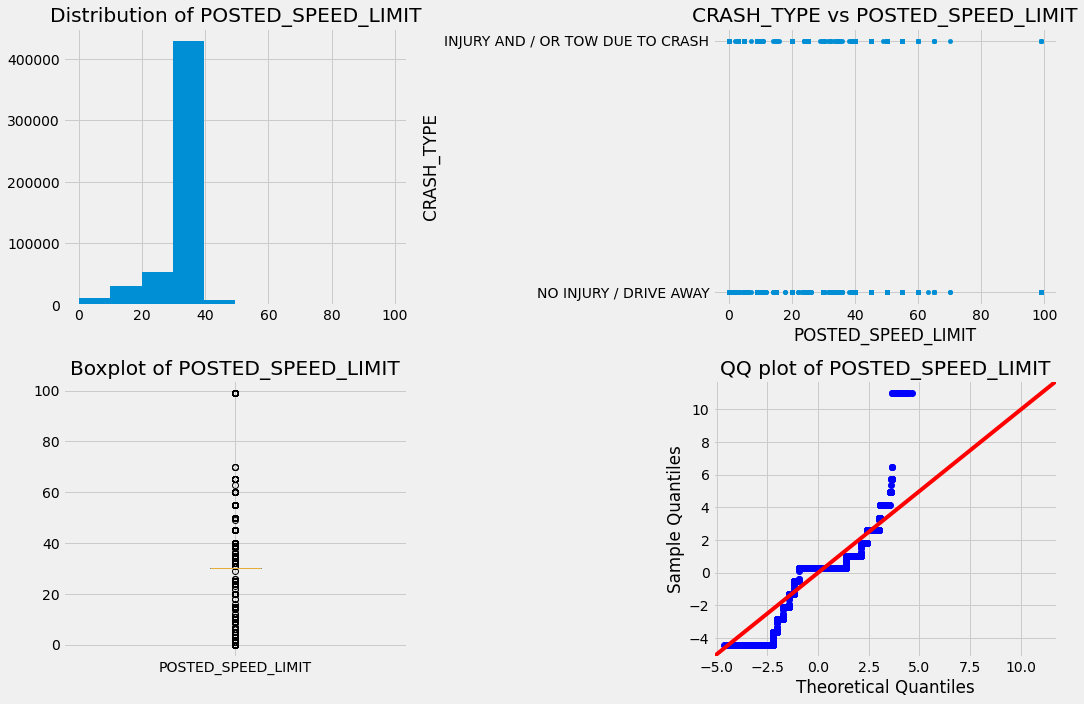

In [18]:
# posted speed limit summary
col_summary(df_crashes_clean, num_col="POSTED_SPEED_LIMIT")

> **Observations**
> - Does not seem to have extreme outliers

> **Actions**
> - Keep all the values in the column

Column Name: STREET_NO
Number of unique values: 11217
There are 522396 duplicates
There are 0 null values
There are 2 zeros


Value Counts Percentage 
 100     1.0
1600    1.0
800     1.0
200     1.0
300     1.0
         ..
688     0.0
10286   0.0
2283    0.0
6696    0.0
12503   0.0
Name: STREET_NO, Length: 11217, dtype: float64


Descriptive Metrics: 
 count             533,613.0
mean     3,663.269457453248
std     2,910.2447183927966
min                     0.0
25%                 1,215.0
50%                 3,199.0
75%                 5,599.0
max               451,100.0
Name: STREET_NO, dtype: float64


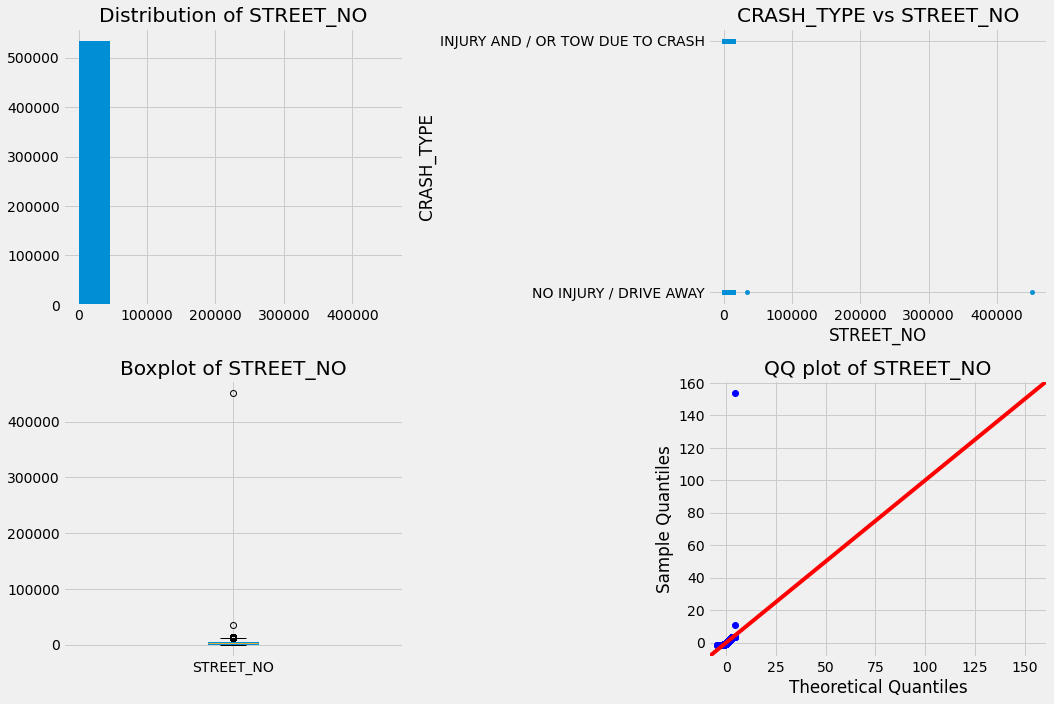

In [19]:
# Street no summary
col_summary(df_crashes_clean, num_col="STREET_NO")

> **Observations**
> - `STREET_NO` should be changed to a categorical variable as it is a unique identifier.

> **Actions**
> - Recast `STREET_NO` as categorical

Column Name: BEAT_OF_OCCURRENCE
Number of unique values: 275
There are 533338 duplicates
There are 0 null values
There are 0 zeros


Value Counts Percentage 
 1,834.0   1.0
114.0     1.0
1,831.0   1.0
122.0     1.0
813.0     1.0
           ..
1,125.0   0.0
1,653.0   0.0
1,652.0   0.0
1,655.0   0.0
6,100.0   0.0
Name: BEAT_OF_OCCURRENCE, Length: 275, dtype: float64


Descriptive Metrics: 
 count             533,613.0
mean    1,238.3659093762708
std       706.9747211922776
min                   111.0
25%                   712.0
50%                 1,135.0
75%                 1,822.0
max                 6,100.0
Name: BEAT_OF_OCCURRENCE, dtype: float64


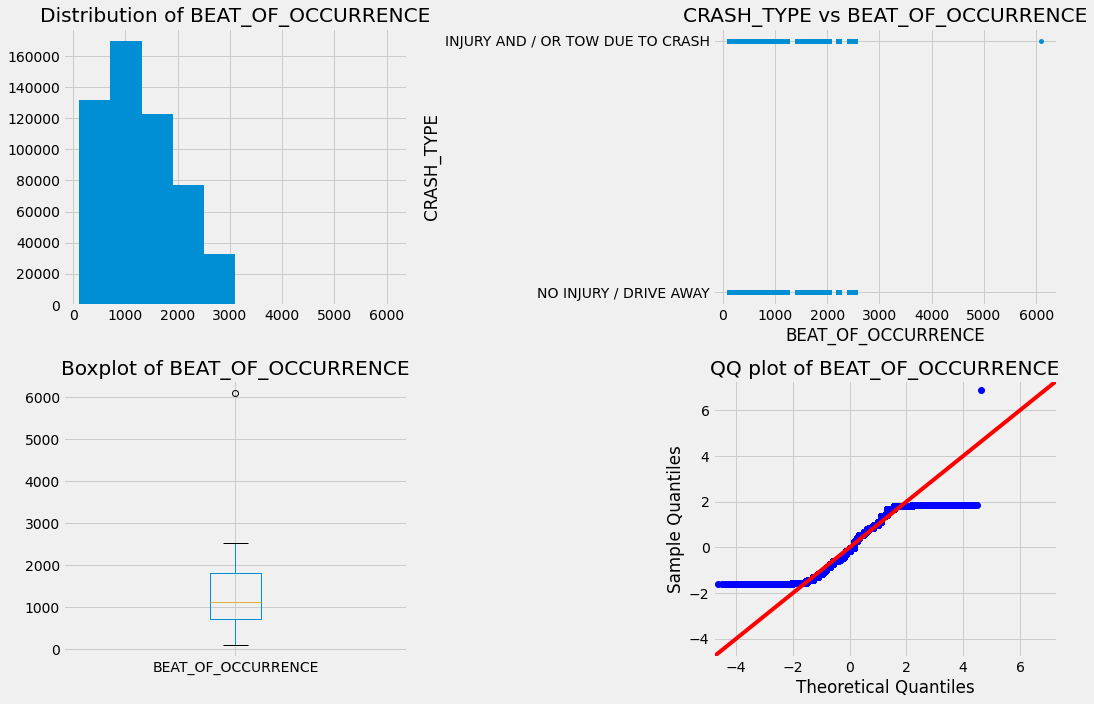

In [20]:
#Summary of BEAT_OF_OCCURRENCE
col_summary(df_crashes_clean, num_col="BEAT_OF_OCCURRENCE")

> **Observations**
> - Needs to be changed to a categorical variable as it is an identifier.
> **Actions**
> - Recast `BEAT_OF_OCCURRENCE` as a categorical variable.

Column Name: NUM_UNITS
Number of unique values: 17
There are 533596 duplicates
There are 0 null values
There are 5 zeros


Value Counts Percentage 
 2.0    88.0
3.0     5.0
1.0     5.0
4.0     1.0
5.0     0.0
6.0     0.0
7.0     0.0
8.0     0.0
9.0     0.0
10.0    0.0
11.0    0.0
0.0     0.0
12.0    0.0
14.0    0.0
15.0    0.0
18.0    0.0
16.0    0.0
Name: NUM_UNITS, dtype: float64


Descriptive Metrics: 
 count            533,613.0
mean     2.033692957255539
std     0.4467122099720147
min                    0.0
25%                    2.0
50%                    2.0
75%                    2.0
max                   18.0
Name: NUM_UNITS, dtype: float64


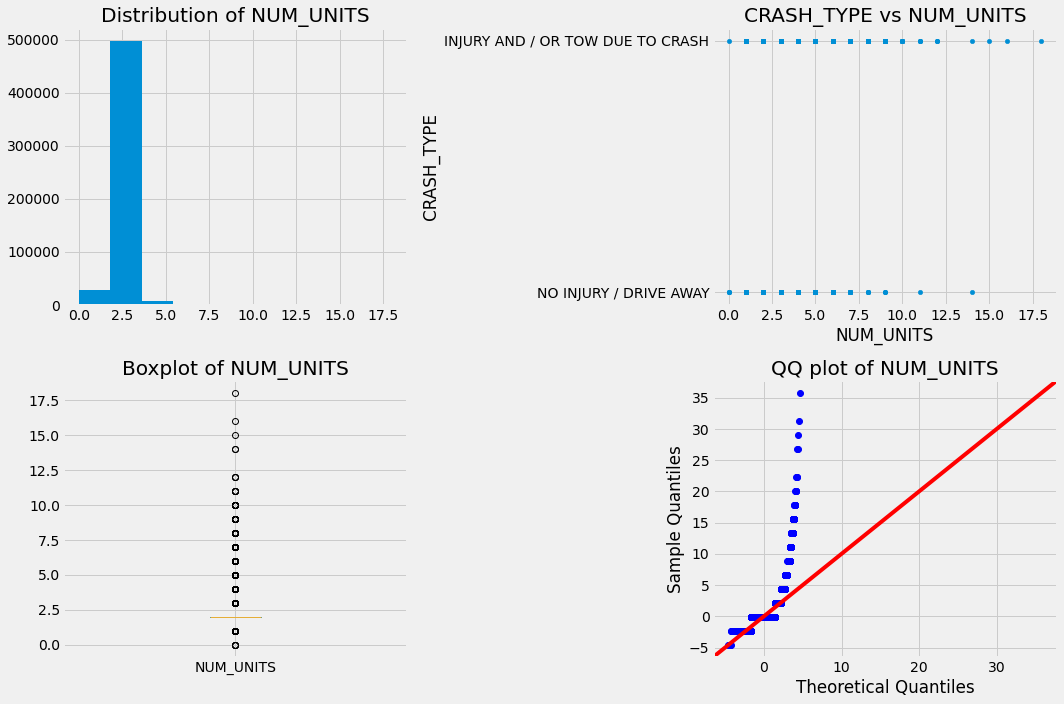

In [21]:
#Summary of NUM_UNITS
col_summary(df_crashes_clean, num_col = "NUM_UNITS")

> **Observations**
> - There are outliers present here.

> **Actions**
> - Remove outliers from `NUM_UNITS`

Column Name: INJURIES_TOTAL
Number of unique values: 19
There are 533594 duplicates
There are 0 null values
There are 462695 zeros


Value Counts Percentage 
 0.0                   87.0
1.0                   10.0
2.0                    2.0
3.0                    1.0
4.0                    0.0
0.18022406417714815    0.0
5.0                    0.0
6.0                    0.0
7.0                    0.0
8.0                    0.0
9.0                    0.0
10.0                   0.0
15.0                   0.0
11.0                   0.0
13.0                   0.0
21.0                   0.0
12.0                   0.0
19.0                   0.0
16.0                   0.0
Name: INJURIES_TOTAL, dtype: float64


Descriptive Metrics: 
 count             533,613.0
mean    0.18022406417714817
std      0.5518904417749386
min                     0.0
25%                     0.0
50%                     0.0
75%                     0.0
max                    21.0
Name: INJURIES_TOTAL, dtype: float64


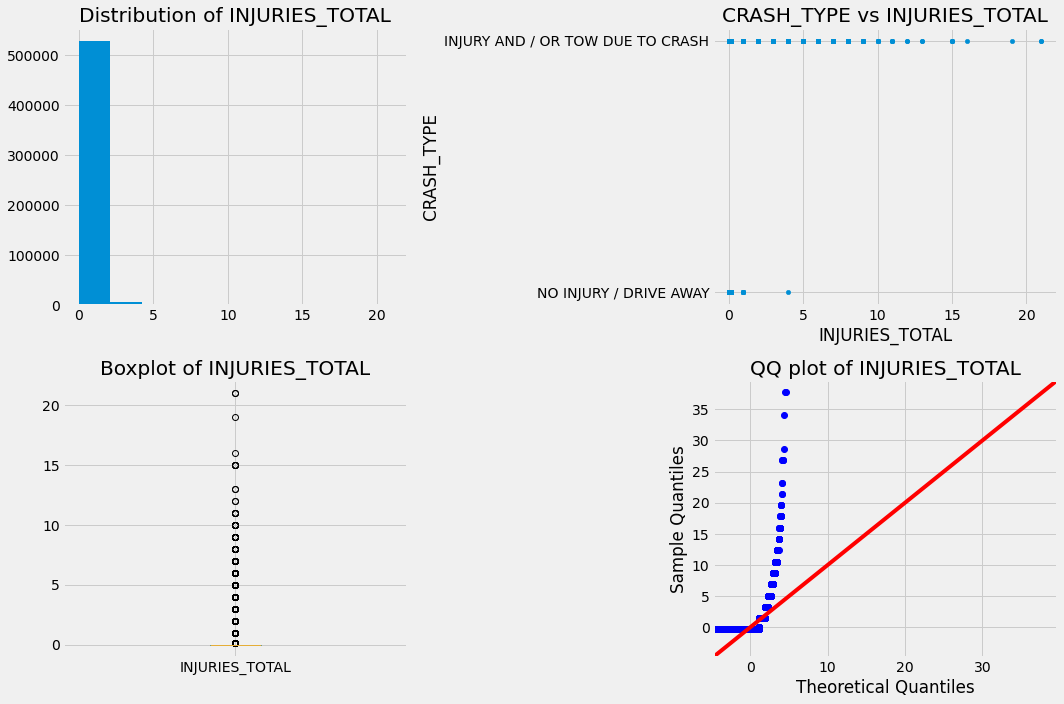

In [22]:
col_summary(df_crashes_clean, num_col="INJURIES_TOTAL")

> **Observations**
> - Maybe useful for modeling by engineering features

> **Actions**
> - Keep the column `INJURIES_TOTAL`

Column Name: INJURIES_FATAL
Number of unique values: 6
There are 533607 duplicates
There are 0 null values
There are 531991 zeros


Value Counts Percentage 
 0.0                     100.0
0.0010835151710902379     0.0
1.0                       0.0
2.0                       0.0
3.0                       0.0
4.0                       0.0
Name: INJURIES_FATAL, dtype: float64


Descriptive Metrics: 
 count              533,613.0
mean    0.001083515171090238
std     0.035602534771029544
min                      0.0
25%                      0.0
50%                      0.0
75%                      0.0
max                      4.0
Name: INJURIES_FATAL, dtype: float64


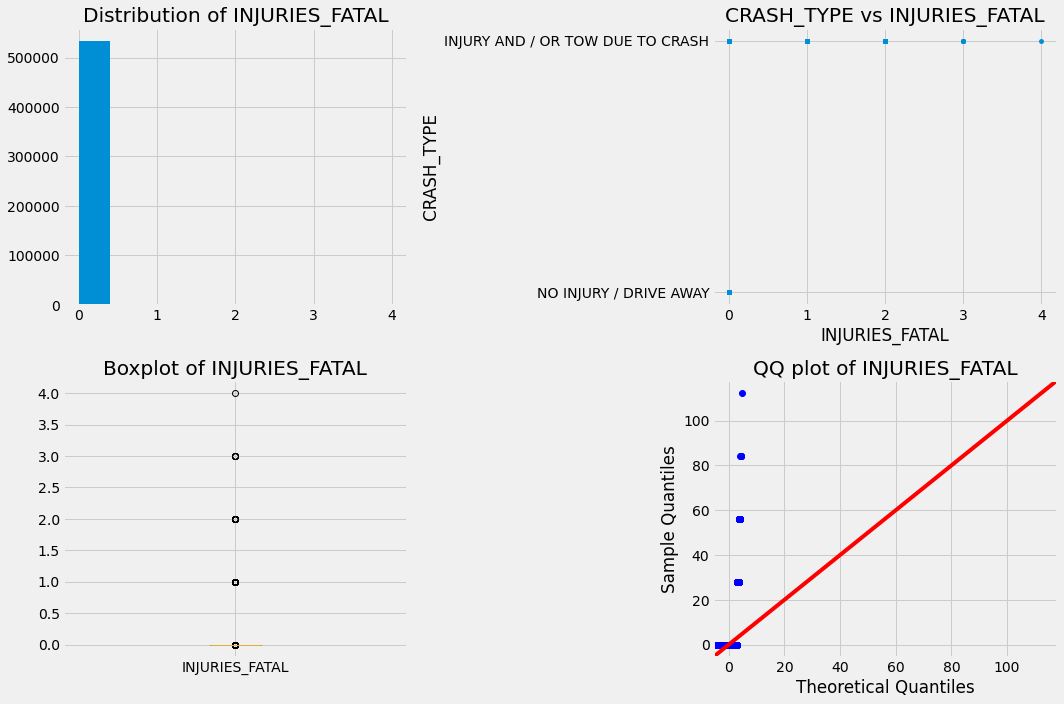

In [23]:
col_summary(df_crashes_clean, num_col="INJURIES_FATAL")

> **Observations**
> - Seems to be useful for modeling

> **Actions**
> - Keep the column `INJURIES_FATAL`

Column Name: INJURIES_INCAPACITATING
Number of unique values: 9
There are 533604 duplicates
There are 0 null values
There are 523546 zeros


Value Counts Percentage 
 0.0                    98.0
1.0                     1.0
0.019676034597371772    0.0
2.0                     0.0
3.0                     0.0
4.0                     0.0
5.0                     0.0
6.0                     0.0
7.0                     0.0
Name: INJURIES_INCAPACITATING, dtype: float64


Descriptive Metrics: 
 count              533,613.0
mean    0.019676034597371776
std      0.16395317797622694
min                      0.0
25%                      0.0
50%                      0.0
75%                      0.0
max                      7.0
Name: INJURIES_INCAPACITATING, dtype: float64


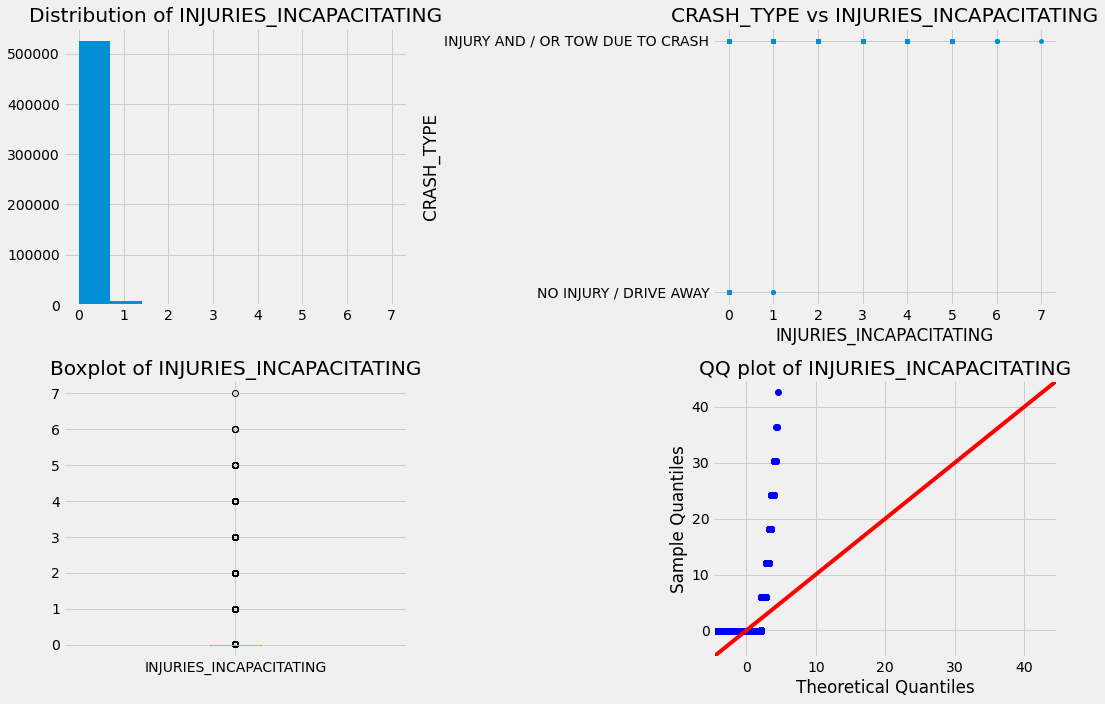

In [24]:
col_summary(df_crashes_clean, num_col="INJURIES_INCAPACITATING")

> **Observations**
> - `INJURIES INCAPACITATING` has many zeros and needs to evaluated for outliers.

> **Actions**
> - Check for outliers in the column.
> - Keep the column.

Column Name: INJURIES_NON_INCAPACITATING
Number of unique values: 18
There are 533595 duplicates
There are 0 null values
There are 491937 zeros


Value Counts Percentage 
 0.0                   92.0
1.0                    6.0
2.0                    1.0
3.0                    0.0
0.10063170624532887    0.0
4.0                    0.0
5.0                    0.0
6.0                    0.0
7.0                    0.0
8.0                    0.0
10.0                   0.0
11.0                   0.0
9.0                    0.0
21.0                   0.0
12.0                   0.0
18.0                   0.0
16.0                   0.0
14.0                   0.0
Name: INJURIES_NON_INCAPACITATING, dtype: float64


Descriptive Metrics: 
 count             533,613.0
mean    0.10063170624532888
std     0.40967550668233826
min                     0.0
25%                     0.0
50%                     0.0
75%                     0.0
max                    21.0
Name: INJURIES_NON_INCAPACITATING, dtype: f

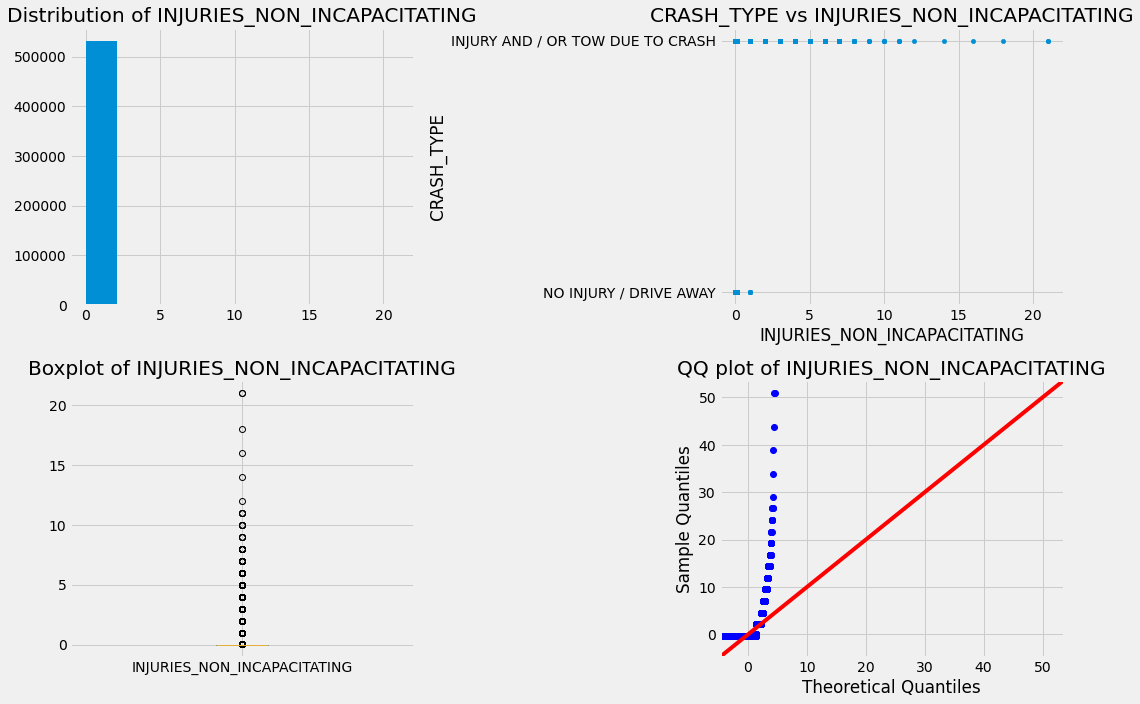

In [25]:
col_summary(df_crashes_clean, num_col="INJURIES_NON_INCAPACITATING")

> **Observations**
> - Doesnt seem useful for modeling

> **Actions**
> - Drop the column `INJURIES_NON_INCAPACITATING`

Column Name: INJURIES_REPORTED_NOT_EVIDENT
Number of unique values: 14
There are 533599 duplicates
There are 0 null values
There are 508655 zeros


Value Counts Percentage 
 0.0                   95.0
1.0                    3.0
2.0                    1.0
0.05883280816335728    0.0
3.0                    0.0
4.0                    0.0
5.0                    0.0
6.0                    0.0
7.0                    0.0
8.0                    0.0
9.0                    0.0
10.0                   0.0
15.0                   0.0
11.0                   0.0
Name: INJURIES_REPORTED_NOT_EVIDENT, dtype: float64


Descriptive Metrics: 
 count             533,613.0
mean    0.05883280816335727
std     0.31134111932104425
min                     0.0
25%                     0.0
50%                     0.0
75%                     0.0
max                    15.0
Name: INJURIES_REPORTED_NOT_EVIDENT, dtype: float64


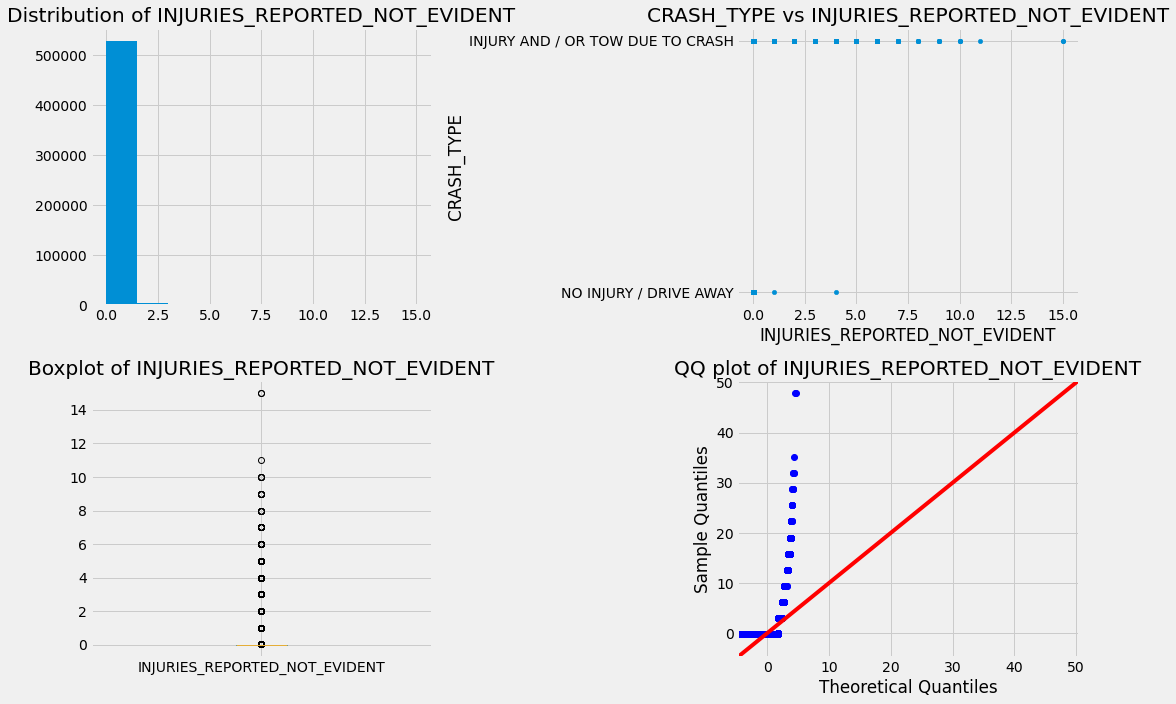

In [26]:
col_summary(df_crashes_clean, num_col="INJURIES_REPORTED_NOT_EVIDENT")

> **Observations**
> about 95% of the values are 0 and the data schema does not clearly state what it means, I will drop this column from analysis.

> **Actions**
> - Drop `INJURIES_REPORTED_NOT_EVIDENT`

Column Name: INJURIES_NO_INDICATION
Number of unique values: 44
There are 533569 duplicates
There are 0 null values
There are 10350 zeros


Value Counts Percentage 
 2.0                 46.0
1.0                 30.0
3.0                 13.0
4.0                  5.0
5.0                  2.0
0.0                  2.0
6.0                  1.0
7.0                  0.0
2.019732369874898    0.0
8.0                  0.0
9.0                  0.0
10.0                 0.0
11.0                 0.0
12.0                 0.0
14.0                 0.0
13.0                 0.0
16.0                 0.0
15.0                 0.0
17.0                 0.0
20.0                 0.0
21.0                 0.0
30.0                 0.0
37.0                 0.0
18.0                 0.0
19.0                 0.0
22.0                 0.0
27.0                 0.0
26.0                 0.0
28.0                 0.0
42.0                 0.0
36.0                 0.0
31.0                 0.0
40.0                 0.0
29.0     

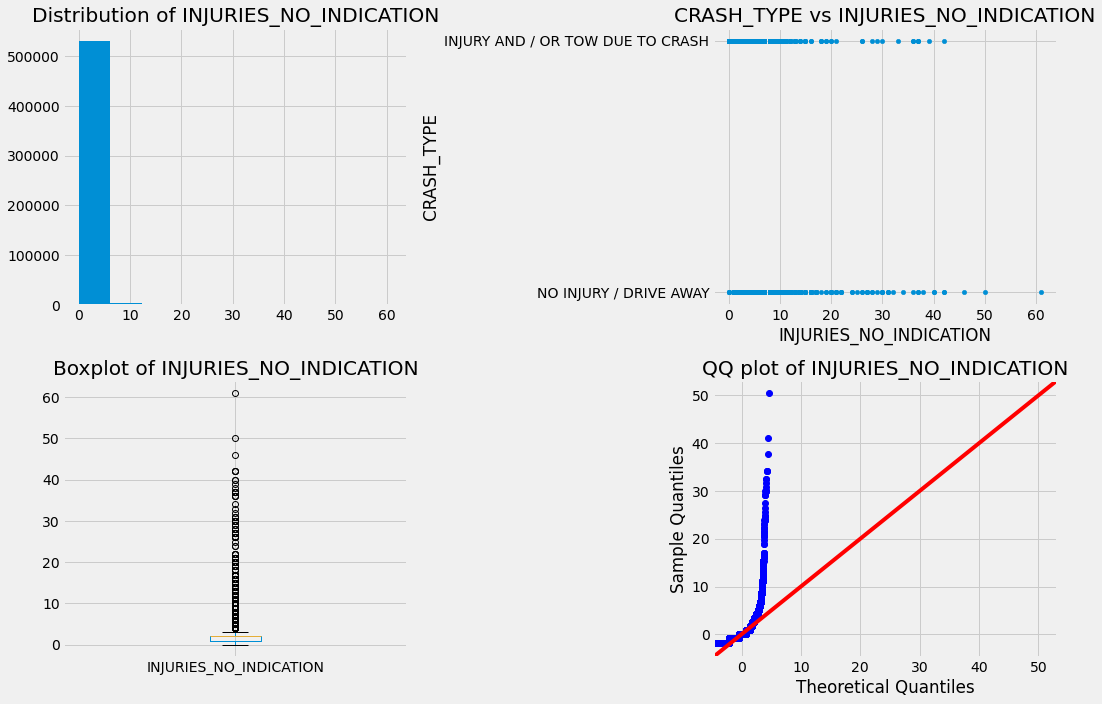

In [27]:
col_summary(df_crashes_clean, num_col="INJURIES_NO_INDICATION")

> **Observations**
> - Column seems to useful for classification

> **Actions**
> - Keep the column

Column Name: INJURIES_UNKNOWN
Number of unique values: 1
There are 533612 duplicates
There are 0 null values
There are 533613 zeros


Value Counts Percentage 
 0.0   100.0
Name: INJURIES_UNKNOWN, dtype: float64


Descriptive Metrics: 
 count   533,613.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: INJURIES_UNKNOWN, dtype: float64


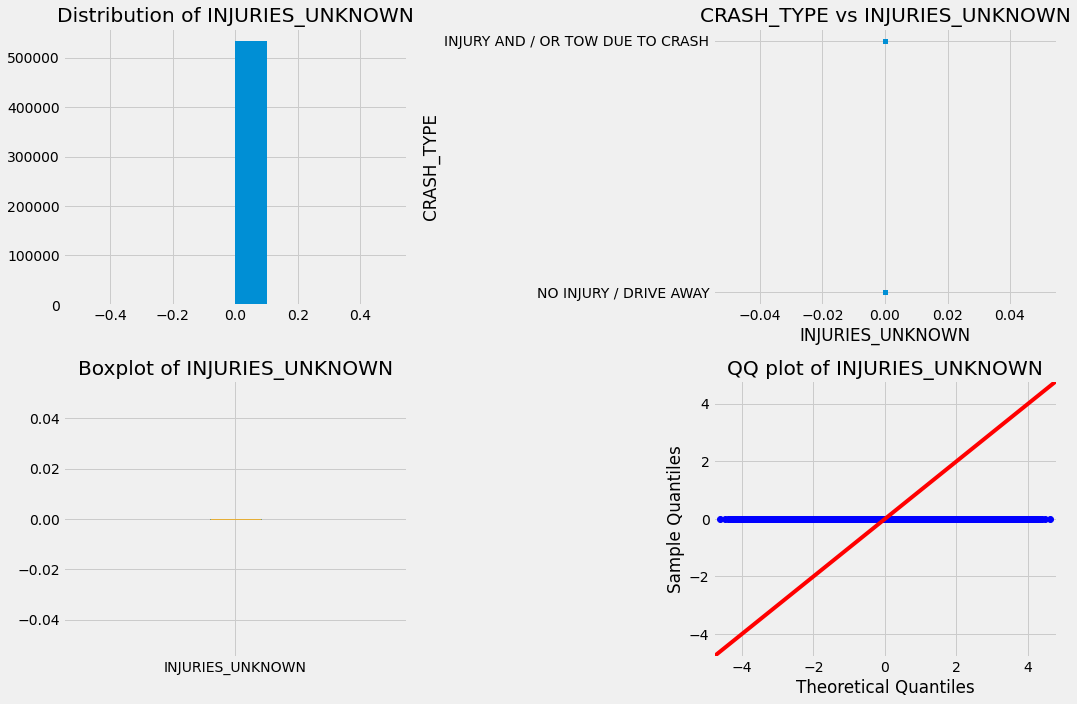

In [28]:
col_summary(df_crashes_clean, num_col="INJURIES_UNKNOWN")

> **Observations**
> - Doesnt seem to be a useful column

> **Actions**
> - Drop `INJURIES_UNKNOWN`

Column Name: CRASH_HOUR
Number of unique values: 24
There are 533589 duplicates
There are 0 null values
There are 11063 zeros


Value Counts Percentage 
 16                 8.0
15                 8.0
17                 8.0
14   7.000000000000001
18                 6.0
13                 6.0
12                 6.0
8                  5.0
11                 5.0
9                  5.0
10                 5.0
19                 5.0
7                  4.0
20                 4.0
21                 3.0
22                 3.0
23                 3.0
6                  2.0
0                  2.0
1                  2.0
2                  2.0
5                  1.0
3                  1.0
4                  1.0
Name: CRASH_HOUR, dtype: float64


Descriptive Metrics: 
 count            533,613.0
mean    13.249231184397681
std      5.517232054949403
min                    0.0
25%                    9.0
50%                   14.0
75%                   17.0
max                   23.0
Name: CRASH_HOUR, dt

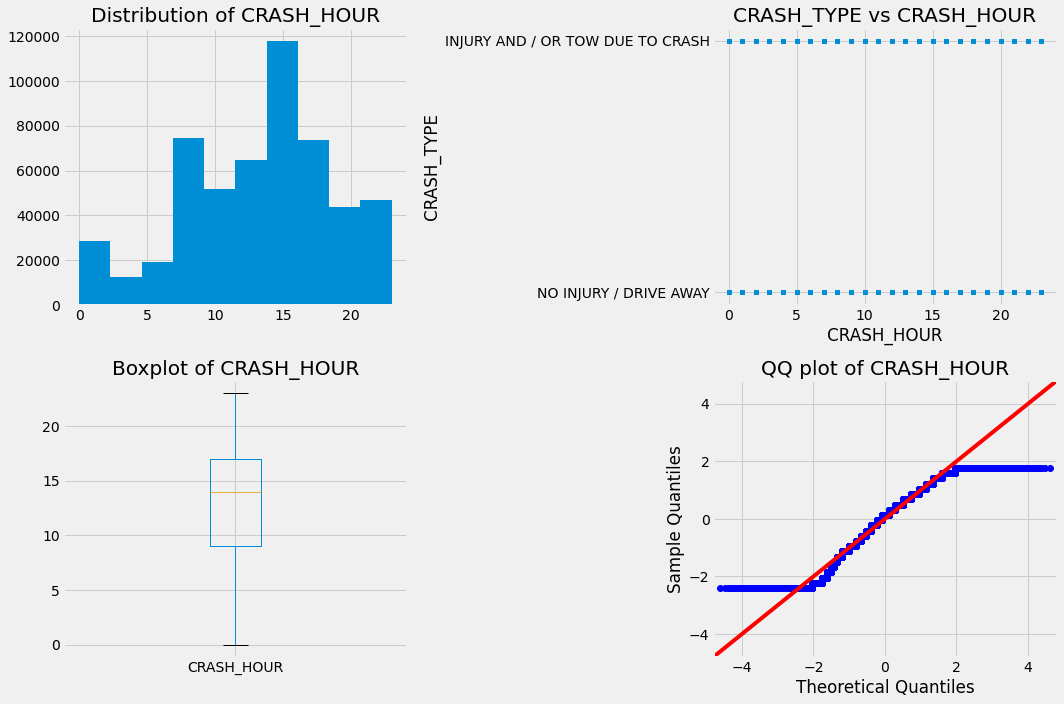

In [29]:
col_summary(df_crashes_clean, num_col="CRASH_HOUR")

> **Observations**
> - Seems useful for modeling

> **Actions**
> - Keep the column

Column Name: CRASH_DAY_OF_WEEK
Number of unique values: 7
There are 533606 duplicates
There are 0 null values
There are 0 zeros


Value Counts Percentage 
 6                 16.0
7                 15.0
5   14.000000000000002
3   14.000000000000002
4   14.000000000000002
2   14.000000000000002
1                 12.0
Name: CRASH_DAY_OF_WEEK, dtype: float64


Descriptive Metrics: 
 count           533,613.0
mean    4.125532923673149
std      1.97793398152501
min                   1.0
25%                   2.0
50%                   4.0
75%                   6.0
max                   7.0
Name: CRASH_DAY_OF_WEEK, dtype: float64


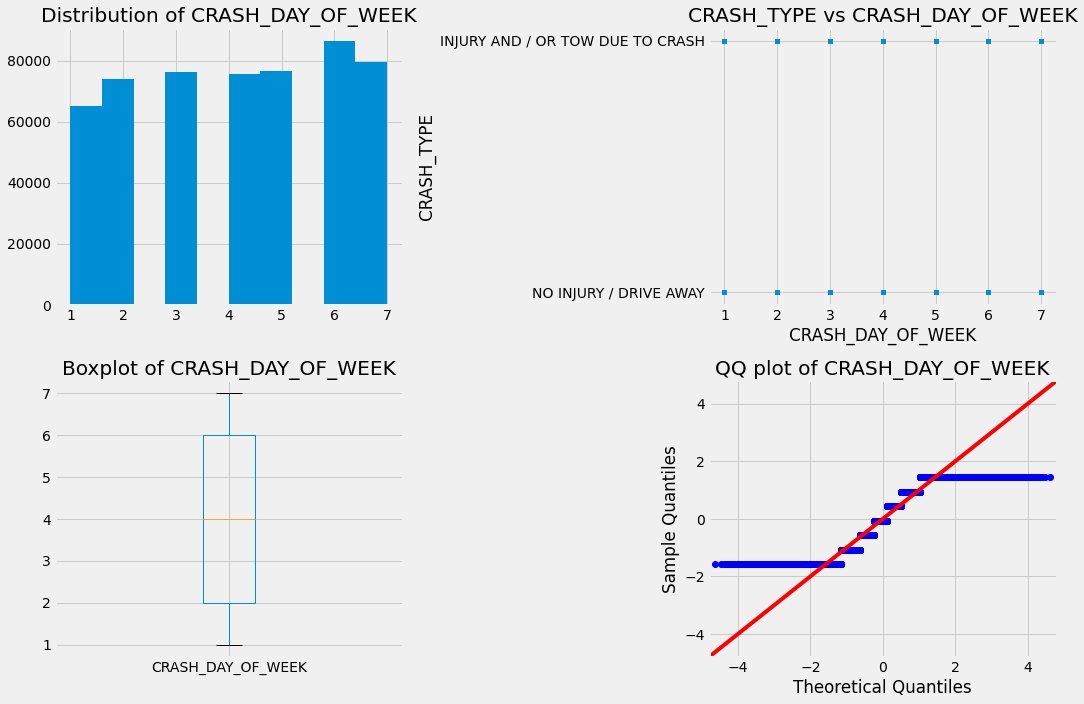

In [30]:
col_summary(df_crashes_clean, num_col="CRASH_DAY_OF_WEEK")

> **Observations**
> - Doesnt seem to be useful

> **Actions**
> - Drop `CRASH_DAY_OF_WEEK`

Column Name: CRASH_MONTH
Number of unique values: 12
There are 533601 duplicates
There are 0 null values
There are 0 zeros


Value Counts Percentage 
 7                  9.0
6                  9.0
8                  9.0
5                  9.0
10                 9.0
12                 8.0
9                  8.0
11                 8.0
1                  8.0
3                  8.0
2                  8.0
4    7.000000000000001
Name: CRASH_MONTH, dtype: float64


Descriptive Metrics: 
 count           533,613.0
mean    6.595834434318504
std     3.389520115976073
min                   1.0
25%                   4.0
50%                   7.0
75%                  10.0
max                  12.0
Name: CRASH_MONTH, dtype: float64


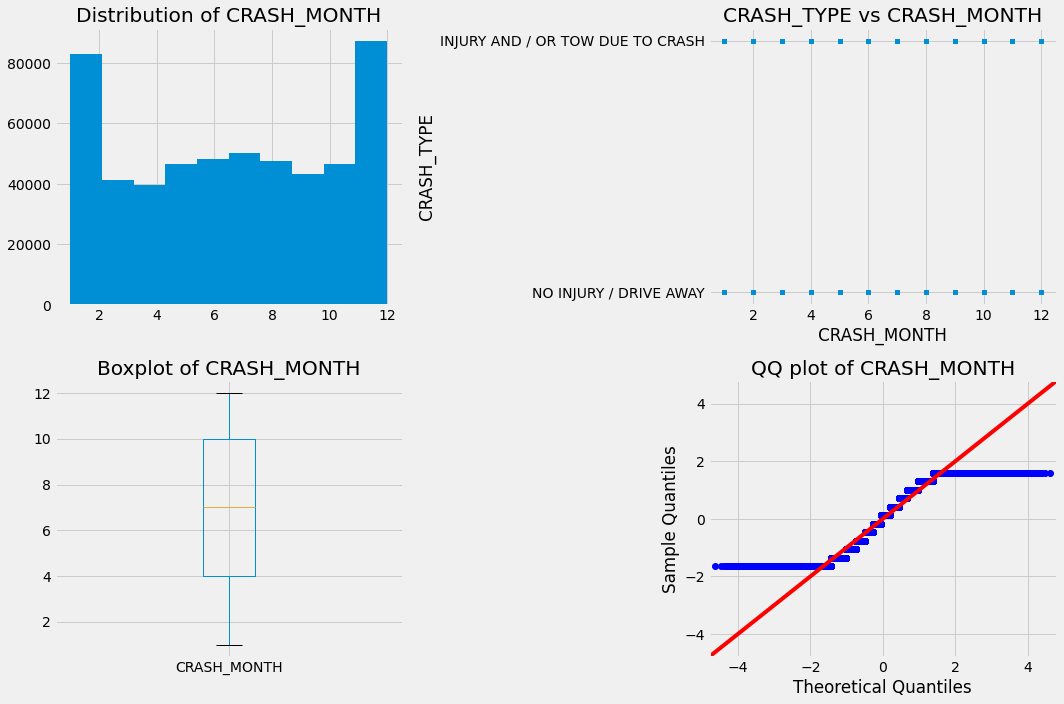

In [31]:
col_summary(df_crashes_clean, num_col="CRASH_MONTH")

> **Observations**
> - Doesnt seem to be useful

> **Actions**
> - Drop `CRASH_MONTH`

Column Name: LATITUDE
Number of unique values: 226462
There are 307151 duplicates
There are 0 null values
There are 3081 zeros


Value Counts Percentage 
 0.0                  1.0
41.976201139000004   0.0
41.751460603000005   0.0
41.791420282         0.0
41.722257273000004   0.0
                      ..
41.713529385         0.0
41.684149414000004   0.0
41.681025124         0.0
41.68694248          0.0
42.000060675         0.0
Name: LATITUDE, Length: 226462, dtype: float64


Descriptive Metrics: 
 count            533,613.0
mean     41.61569626170536
std      3.172531407071622
min                    0.0
25%            41.78031747
50%           41.874654272
75%     41.923797791999995
max           42.022779861
Name: LATITUDE, dtype: float64


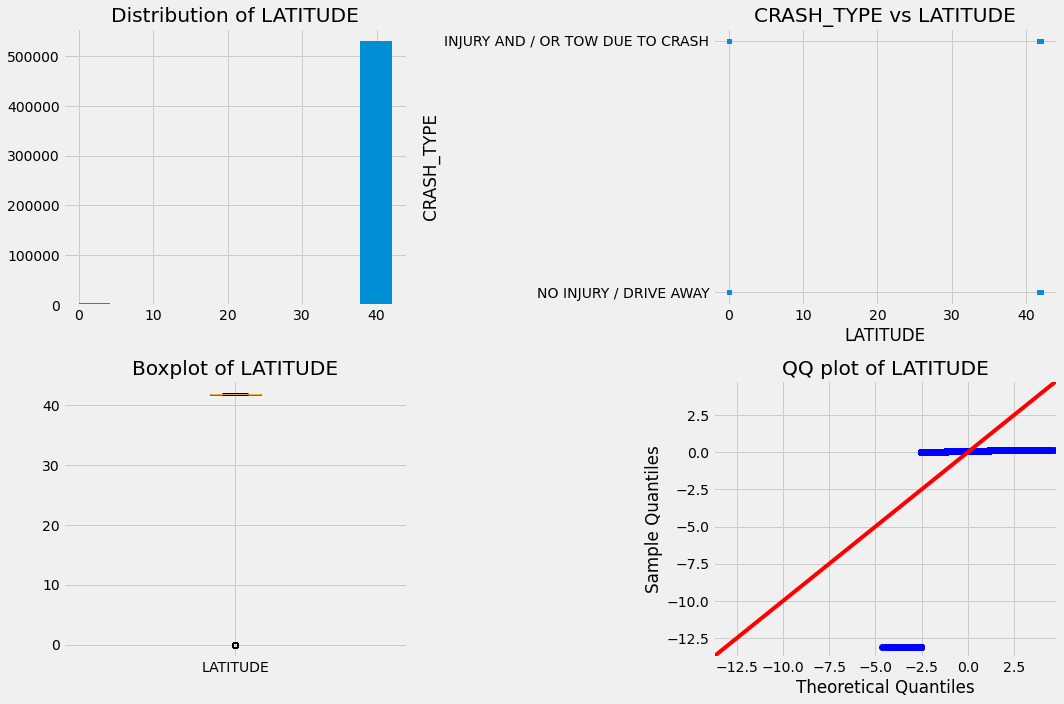

In [32]:
col_summary(df_crashes_clean, num_col="LATITUDE")

> **Observations**
> - Latitude should be a categorical as it is an identifier

> **Actions**
> - Recast `LATITUDE` as a categorical feature

Column Name: LONGITUDE
Number of unique values: 226440
There are 307173 duplicates
There are 0 null values
There are 3081 zeros


Value Counts Percentage 
 0.0                  1.0
-87.905309125        0.0
-87.58597199299999   0.0
-87.58014776899999   0.0
-87.585275565        0.0
                      ..
-87.696262158        0.0
-87.80691731799999   0.0
-87.67134047         0.0
-87.740695279        0.0
-87.551456265        0.0
Name: LONGITUDE, Length: 226440, dtype: float64


Descriptive Metrics: 
 count            533,613.0
mean    -87.17201151702875
std      6.643308410037887
min           -87.93587692
25%          -87.720961428
50%     -87.67277405600001
75%          -87.632362725
max                    0.0
Name: LONGITUDE, dtype: float64


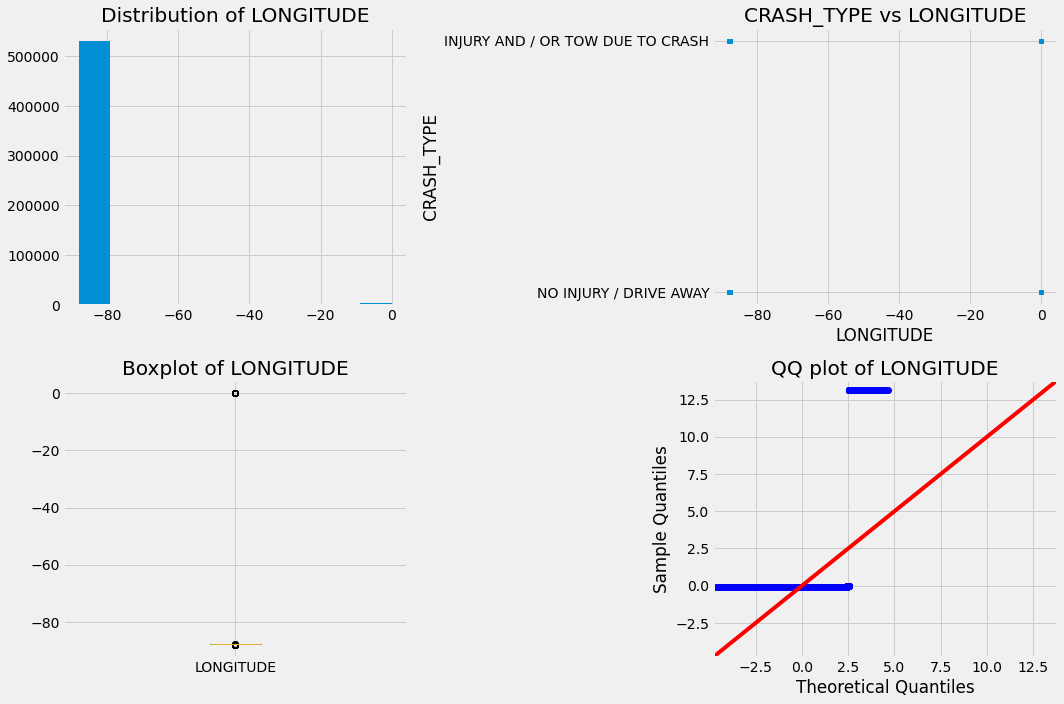

In [33]:
col_summary(df_crashes_clean, num_col="LONGITUDE")

> **OBSERVATION**
> - `LONGITUDE` seems to be a categorical variable as it is an identifier.

> **Action**
> - Recast `LONGITUDE` as a categorical variable/

Column Name: CRASH_RECORD_ID


Number of unique values: 533613


There are 0 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 686d76407fb9a67e9f1ef689872f70f29bd0342d9338303427807d51000bd41492a4e95b5280053a302884ca6e490c2d2c2f37cfa4dfce2759643fe8da3a36fc    1
417e225f9b9349ae798b38f6ca6b529046f0de055414fd5e7964a933541c7e9c614f6e8aad5e9c2f31e2441382eb6b43e6f37a9e7c0d79725f70223fe14eb887    1
905a61b639bce3ff15b291c13c56993ee864b17c4ee7b3509d4d6eeb2da02fa3dd0197dd87f583b0413d70342dd73cbce8d16a1c96c023fc313e4ccbbee92e33    1
85b16bb510960dd46afdcdf6e87c10b73a09a805bc6634c7424d6c301f552cb1cc810eecd5d5d5e908ac3e2b1cefc5adfd015e6cec645156be51ac5df6df53ff    1
98463cdef966572eb730ca853791a8dba703211d9db6813cb39d9d0fd6b16ebcdc93f51f645942ff7d7df046646dddf9a771e375d4e3a063f29630b8092c2c22    1
                                                                                                                                   ..
17cceca8575ce501476ac41dcc6d1f4014

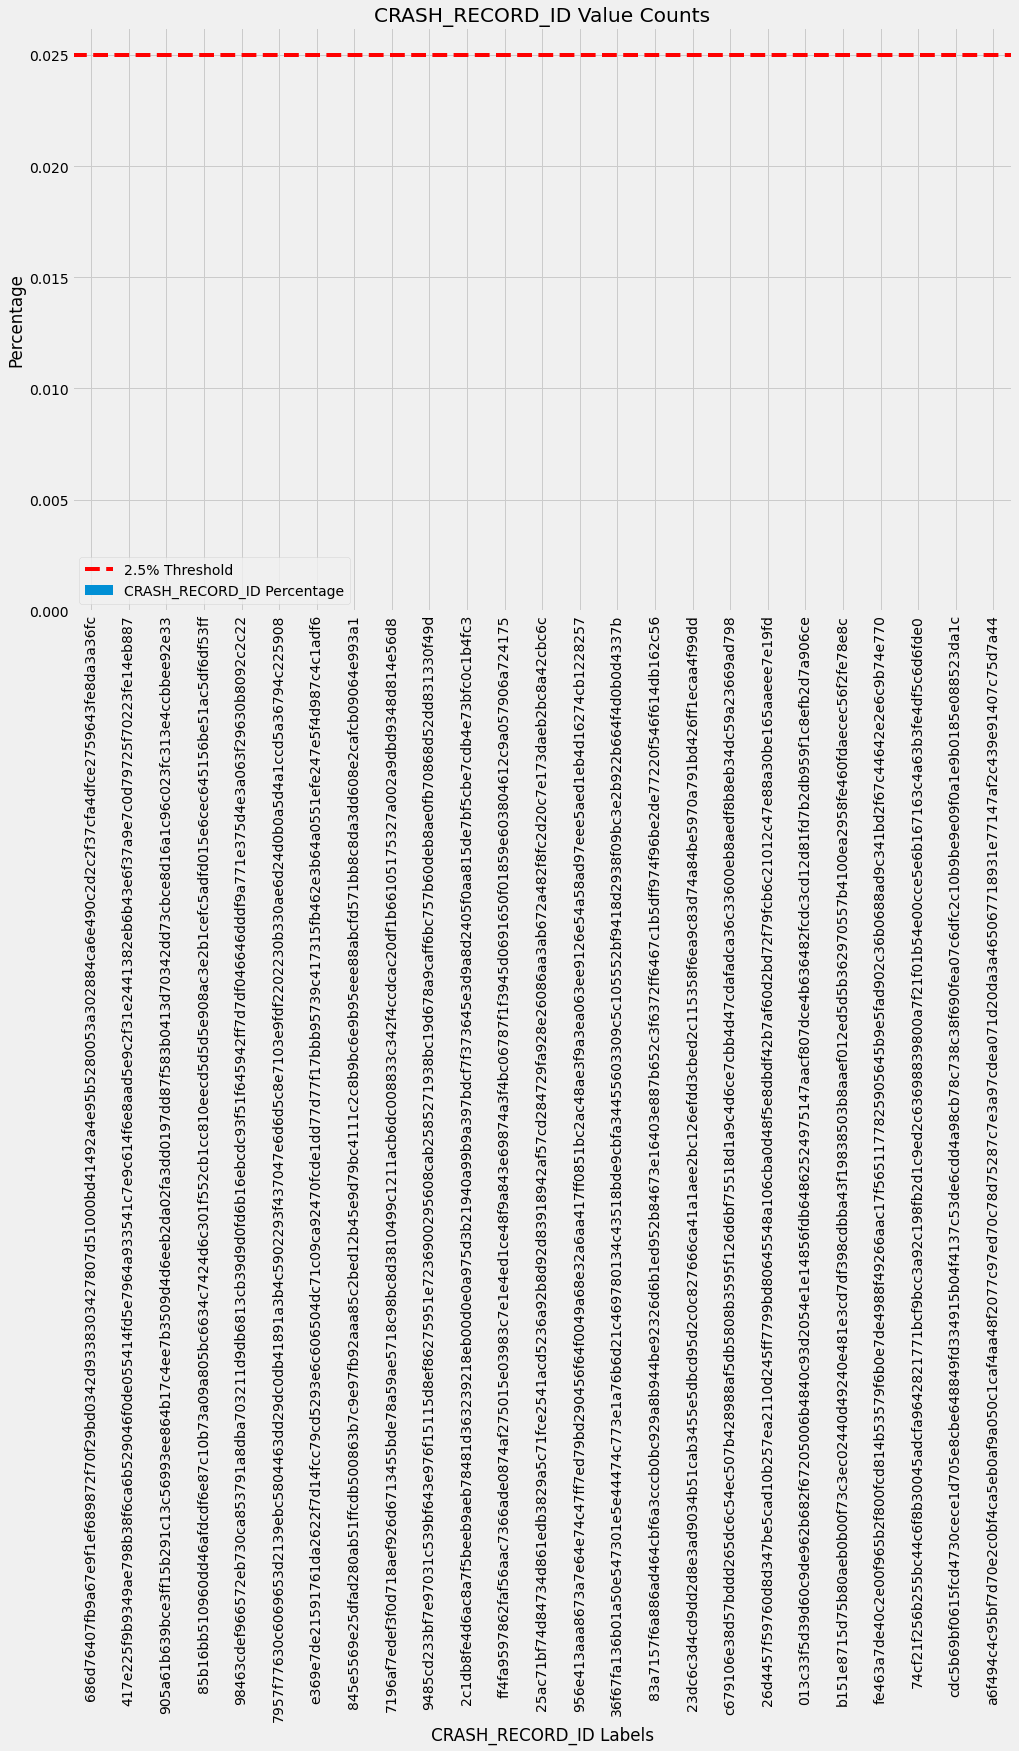

In [34]:
col_summary(df_crashes_clean, cat_cols = ["CRASH_RECORD_ID"])

Column Name: RD_NO


Number of unique values: 529262


There are 4351 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing     4352
JD322663       1
JD464455       1
JE163638       1
JE174819       1
            ... 
JB309859       1
JE175381       1
JA393989       1
JB417996       1
JA143374       1
Name: RD_NO, Length: 529262, dtype: int64




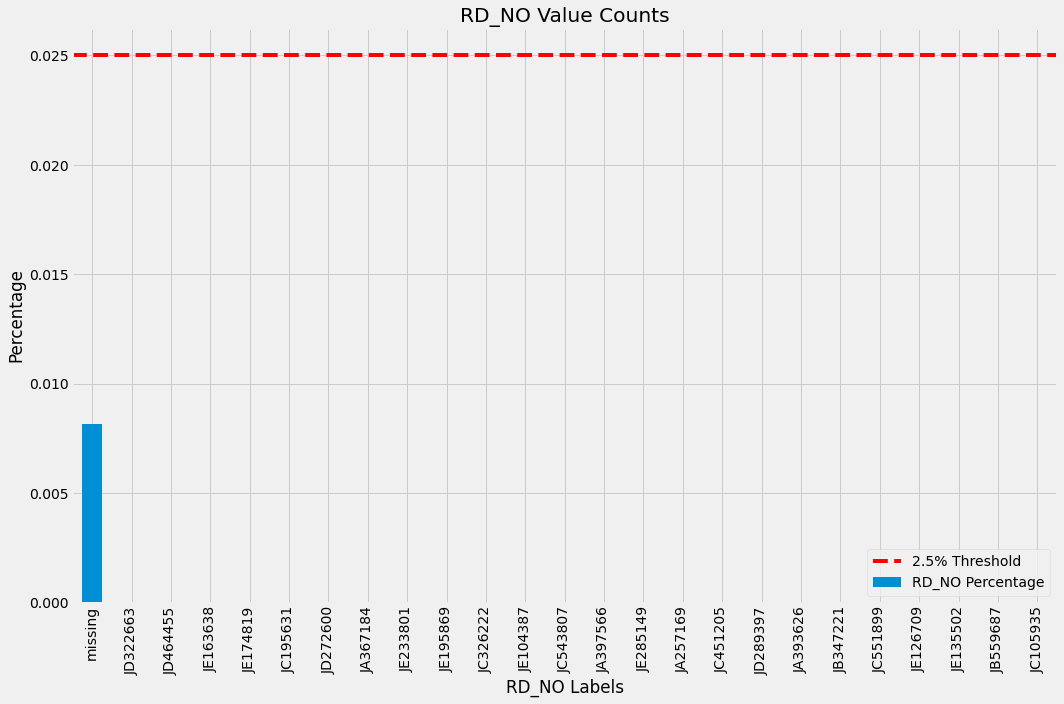

In [35]:
col_summary(df_crashes_clean, cat_cols = ["RD_NO"])

Column Name: CRASH_DATE


Number of unique values: 348095


There are 185518 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 12/29/2020 05:00:00 PM    30
11/10/2017 10:30:00 AM    27
11/10/2017 10:00:00 AM    20
01/12/2019 02:30:00 PM    20
02/04/2021 02:00:00 PM    18
                          ..
02/28/2019 05:53:00 PM     1
04/03/2021 02:58:00 AM     1
03/17/2021 04:35:00 PM     1
10/14/2020 12:17:00 AM     1
07/07/2018 07:15:00 PM     1
Name: CRASH_DATE, Length: 348095, dtype: int64




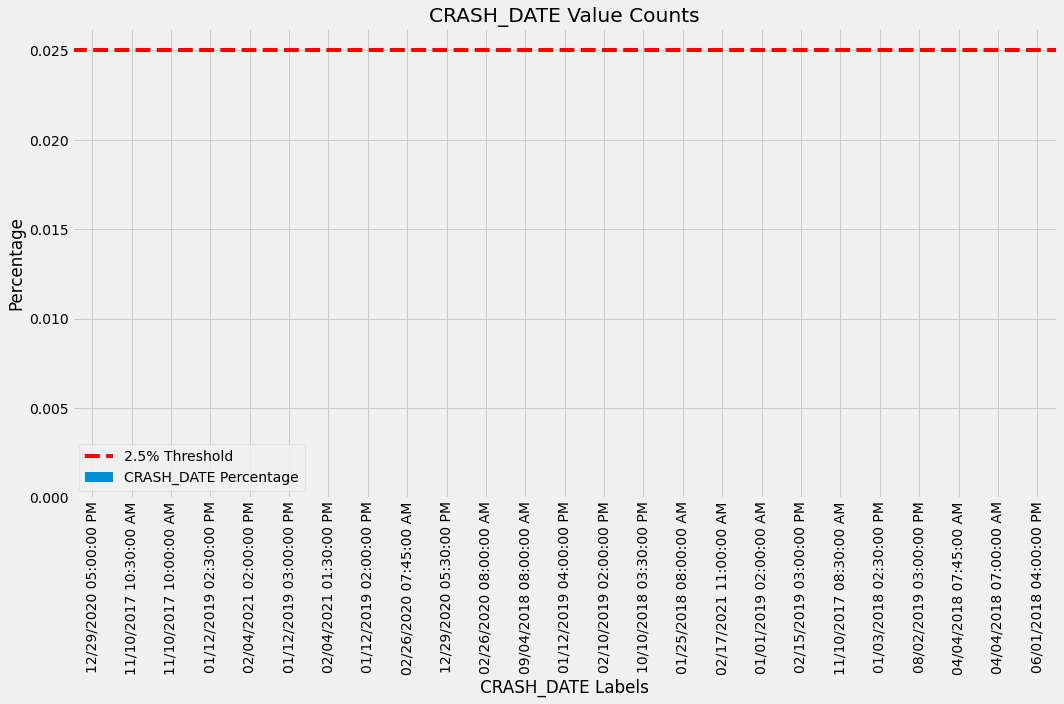

Column Name: CRASH_DATE_EST_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    493171
Y           35167
N            5275
Name: CRASH_DATE_EST_I, dtype: int64




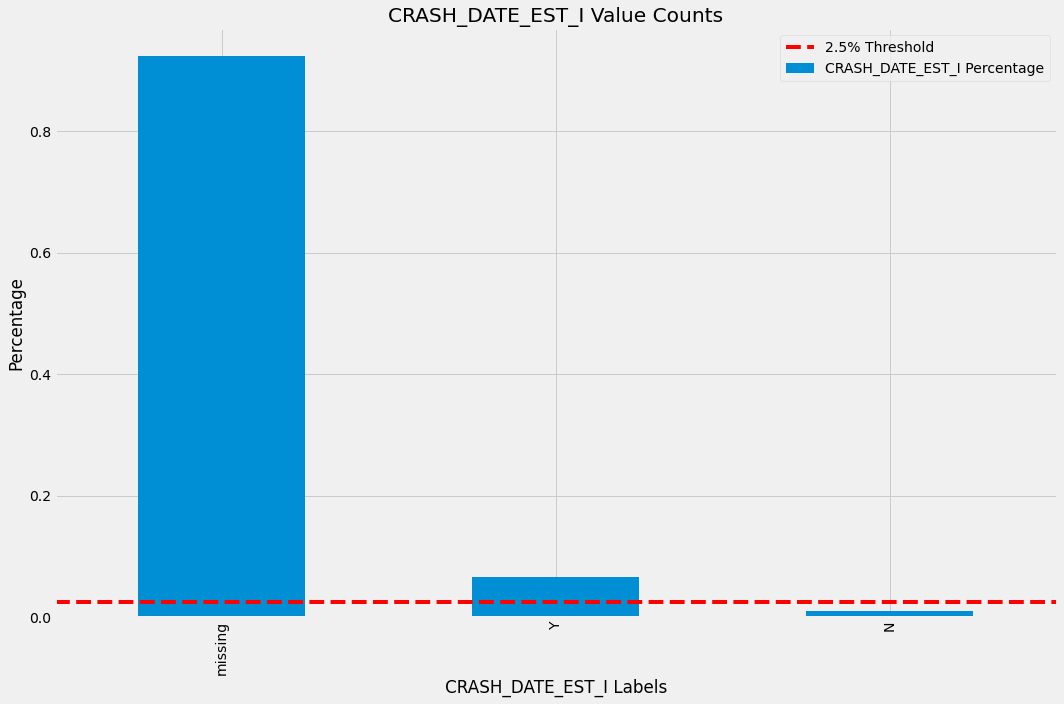

In [36]:
col_summary(df_crashes_clean, cat_cols = ["CRASH_DATE", "CRASH_DATE_EST_I"])

Column Name: TRAFFIC_CONTROL_DEVICE


Number of unique values: 19


There are 533594 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 NO CONTROLS                 307617
TRAFFIC SIGNAL              148124
STOP SIGN/FLASHER            52848
UNKNOWN                      17261
OTHER                         3257
LANE USE MARKING              1226
YIELD                          753
OTHER REG. SIGN                547
OTHER WARNING SIGN             470
RAILROAD CROSSING GATE         345
PEDESTRIAN CROSSING SIGN       237
POLICE/FLAGMAN                 196
SCHOOL ZONE                    175
DELINEATORS                    169
FLASHING CONTROL SIGNAL        164
OTHER RAILROAD CROSSING        124
RR CROSSING SIGN                58
NO PASSING                      25
BICYCLE CROSSING SIGN           17
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64




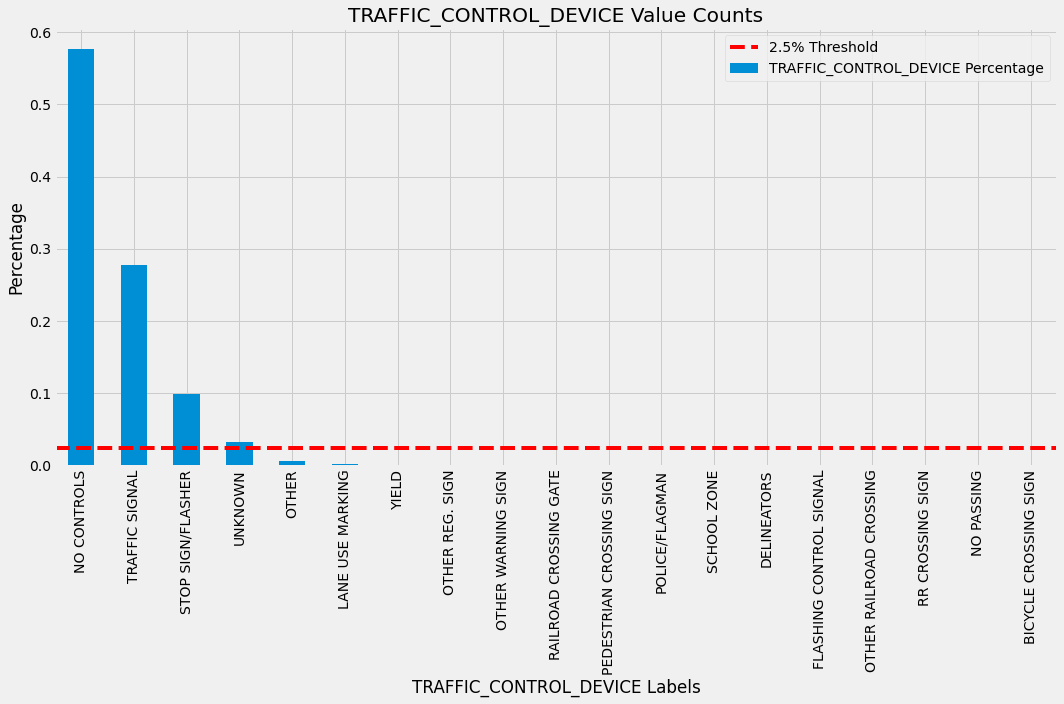

In [37]:
col_summary(df_crashes_clean, cat_cols=["TRAFFIC_CONTROL_DEVICE"])

Column Name: DEVICE_CONDITION


Number of unique values: 8


There are 533605 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 NO CONTROLS                 310825
FUNCTIONING PROPERLY        184424
UNKNOWN                      29420
OTHER                         4139
FUNCTIONING IMPROPERLY        2760
NOT FUNCTIONING               1759
WORN REFLECTIVE MATERIAL       223
MISSING                         63
Name: DEVICE_CONDITION, dtype: int64




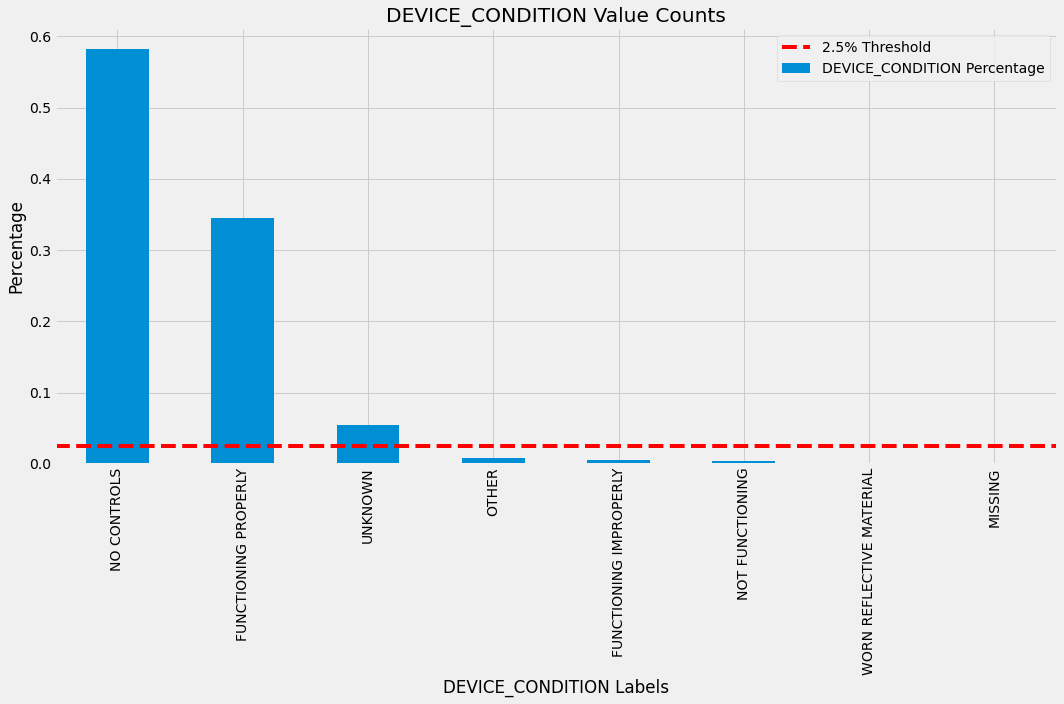

Column Name: WEATHER_CONDITION


Number of unique values: 12


There are 533601 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 CLEAR                       423755
RAIN                         46200
UNKNOWN                      23467
SNOW                         20312
CLOUDY/OVERCAST              15769
OTHER                         1649
FOG/SMOKE/HAZE                 841
SLEET/HAIL                     722
FREEZING RAIN/DRIZZLE          626
BLOWING SNOW                   166
SEVERE CROSS WIND GATE         104
BLOWING SAND, SOIL, DIRT         2
Name: WEATHER_CONDITION, dtype: int64




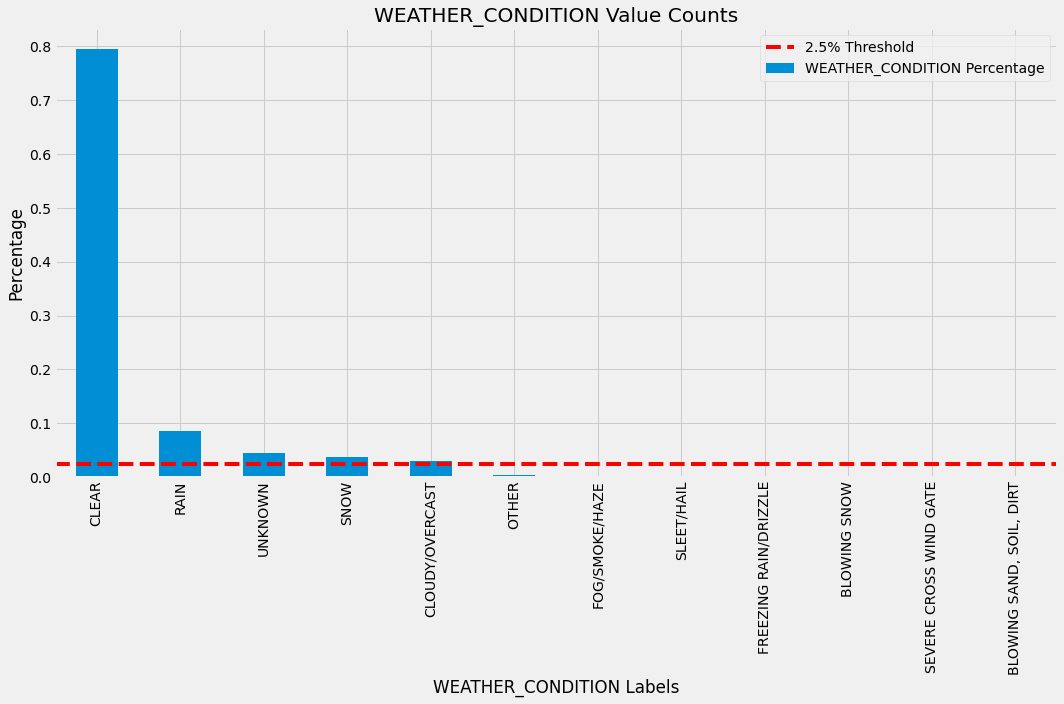

Column Name: LIGHTING_CONDITION


Number of unique values: 6


There are 533607 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 DAYLIGHT                  347660
DARKNESS, LIGHTED ROAD    114589
DARKNESS                   26353
UNKNOWN                    19732
DUSK                       16122
DAWN                        9157
Name: LIGHTING_CONDITION, dtype: int64




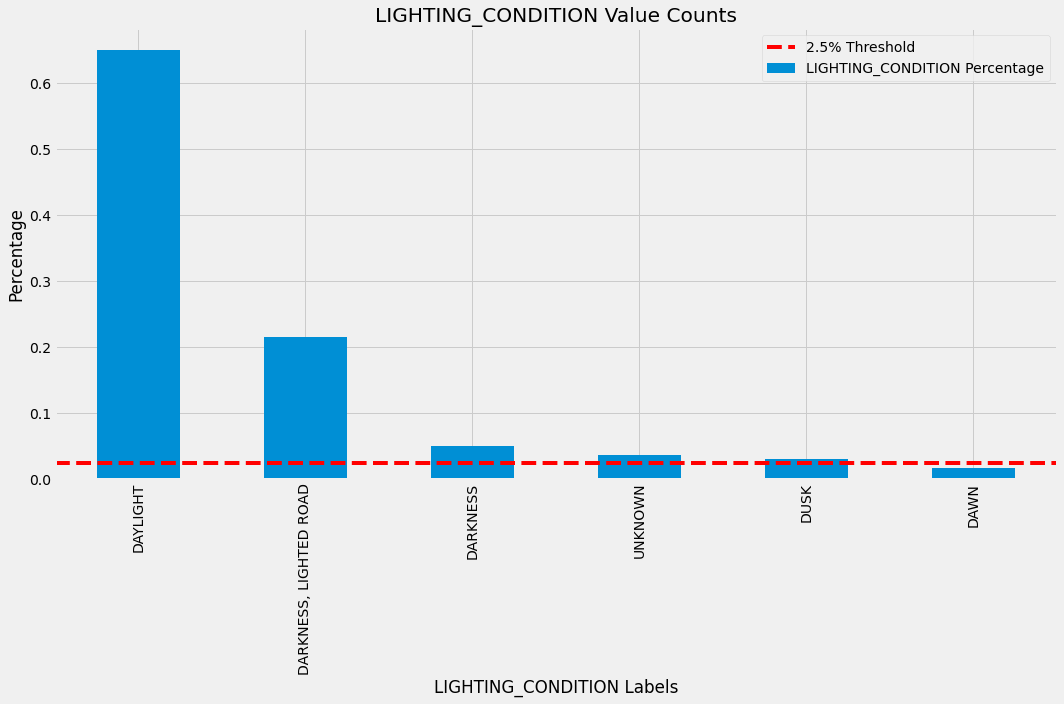

In [38]:
col_summary(df_crashes_clean, cat_cols=["DEVICE_CONDITION", "WEATHER_CONDITION", "LIGHTING_CONDITION"])

Column Name: FIRST_CRASH_TYPE


Number of unique values: 18


There are 533595 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 REAR END                        125539
PARKED MOTOR VEHICLE            124116
SIDESWIPE SAME DIRECTION         81656
TURNING                          74497
ANGLE                            56628
FIXED OBJECT                     24787
PEDESTRIAN                       12158
PEDALCYCLIST                      7829
SIDESWIPE OPPOSITE DIRECTION      7815
OTHER OBJECT                      5130
HEAD ON                           4612
REAR TO FRONT                     3479
REAR TO SIDE                      2136
OTHER NONCOLLISION                1730
REAR TO REAR                       781
ANIMAL                             371
OVERTURNED                         317
TRAIN                               32
Name: FIRST_CRASH_TYPE, dtype: int64




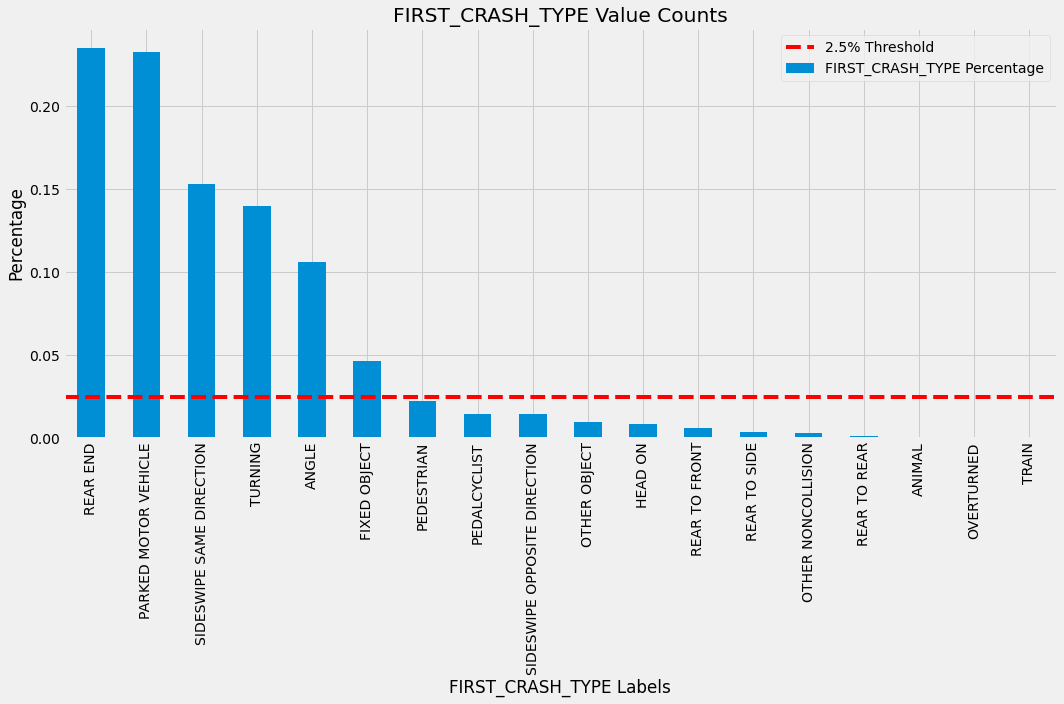

Column Name: TRAFFICWAY_TYPE


Number of unique values: 20


There are 533593 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 NOT DIVIDED                        236579
DIVIDED - W/MEDIAN (NOT RAISED)     92828
ONE-WAY                             70672
PARKING LOT                         37638
DIVIDED - W/MEDIAN BARRIER          31604
FOUR WAY                            19742
OTHER                               14998
ALLEY                                8785
UNKNOWN                              5803
CENTER TURN LANE                     4425
T-INTERSECTION                       4179
DRIVEWAY                             1836
RAMP                                 1679
UNKNOWN INTERSECTION TYPE            1150
FIVE POINT, OR MORE                   492
Y-INTERSECTION                        482
TRAFFIC ROUTE                         360
NOT REPORTED                          161
ROUNDABOUT                            127
L-INTERSECTION                         

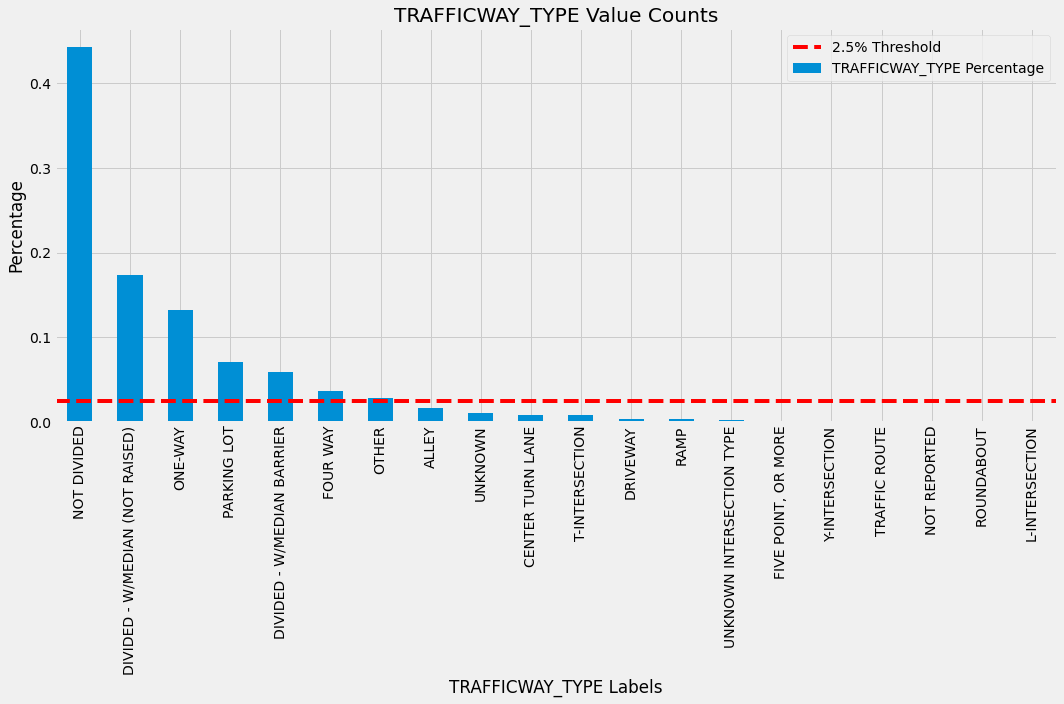

Column Name: REPORT_TYPE


Number of unique values: 4


There are 533609 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 NOT ON SCENE (DESK REPORT)    301541
ON SCENE                      218519
missing                        13313
AMENDED                          240
Name: REPORT_TYPE, dtype: int64




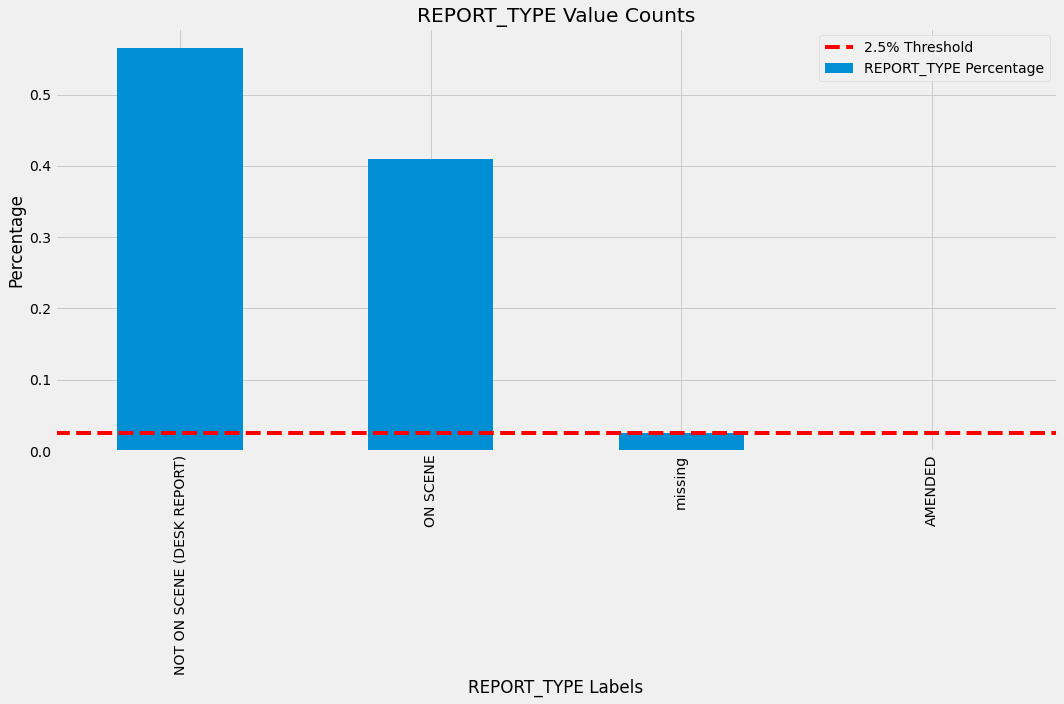

Column Name: CRASH_TYPE


Number of unique values: 2


There are 533611 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 NO INJURY / DRIVE AWAY              398581
INJURY AND / OR TOW DUE TO CRASH    135032
Name: CRASH_TYPE, dtype: int64




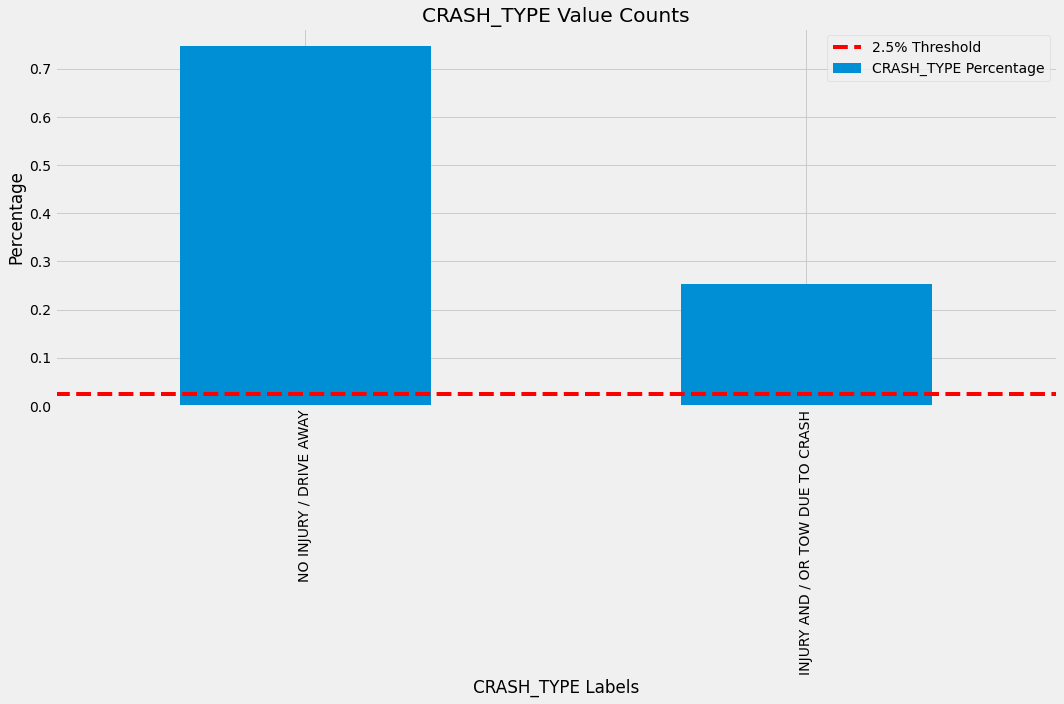

In [39]:
col_summary(df_crashes_clean, cat_cols=['FIRST_CRASH_TYPE',
 'TRAFFICWAY_TYPE','REPORT_TYPE', 'CRASH_TYPE'])

Column Name: LANE_CNT


Number of unique values: 61


There are 533552 duplicates


There are 0 null values


There are 1013 zeros


Value Counts Percentage 
 missing    334646
2.0         79498
4.0         43204
1.0         28416
2           11638
            ...  
45.0            1
44.0            1
433,634         1
24.0            1
14              1
Name: LANE_CNT, Length: 61, dtype: int64




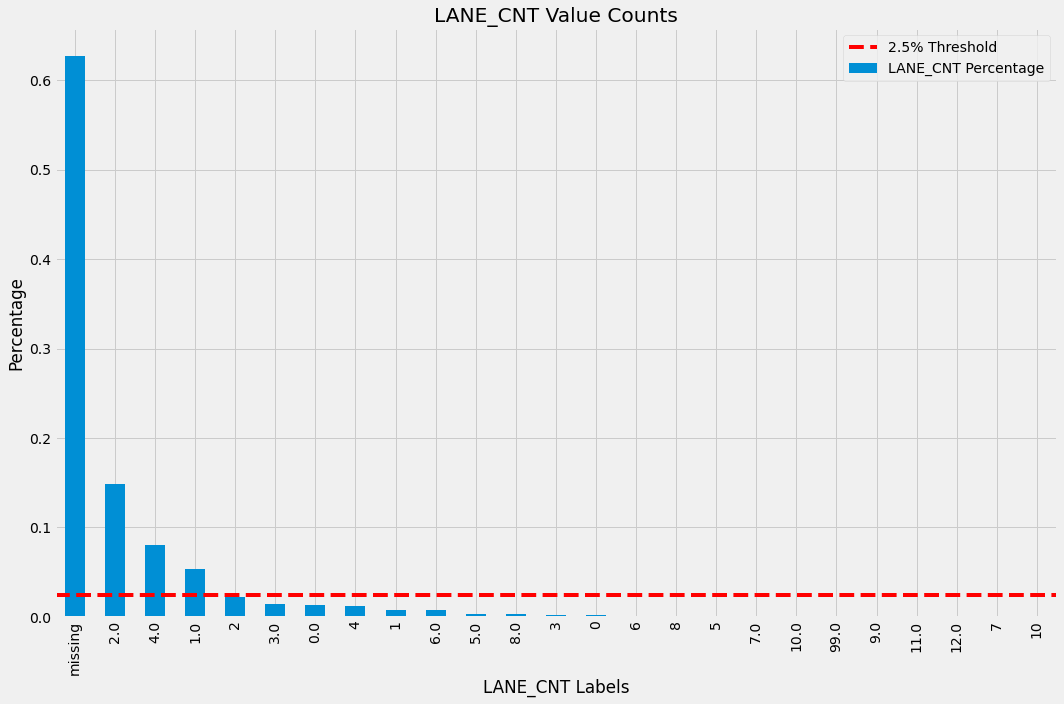

Column Name: ALIGNMENT


Number of unique values: 6


There are 533607 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 STRAIGHT AND LEVEL       520146
STRAIGHT ON GRADE          6738
CURVE, LEVEL               4067
STRAIGHT ON HILLCREST      1618
CURVE ON GRADE              792
CURVE ON HILLCREST          252
Name: ALIGNMENT, dtype: int64




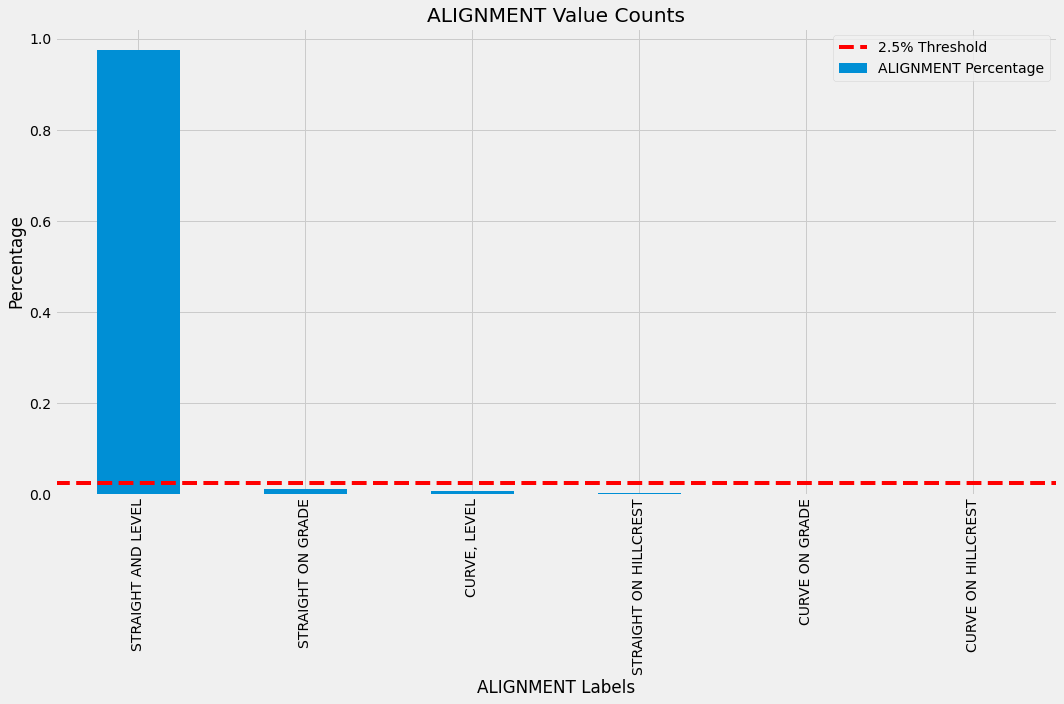

Column Name: ROADWAY_SURFACE_COND


Number of unique values: 7


There are 533606 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 DRY                400665
WET                 71239
UNKNOWN             35862
SNOW OR SLUSH       20427
ICE                  3928
OTHER                1263
SAND, MUD, DIRT       229
Name: ROADWAY_SURFACE_COND, dtype: int64




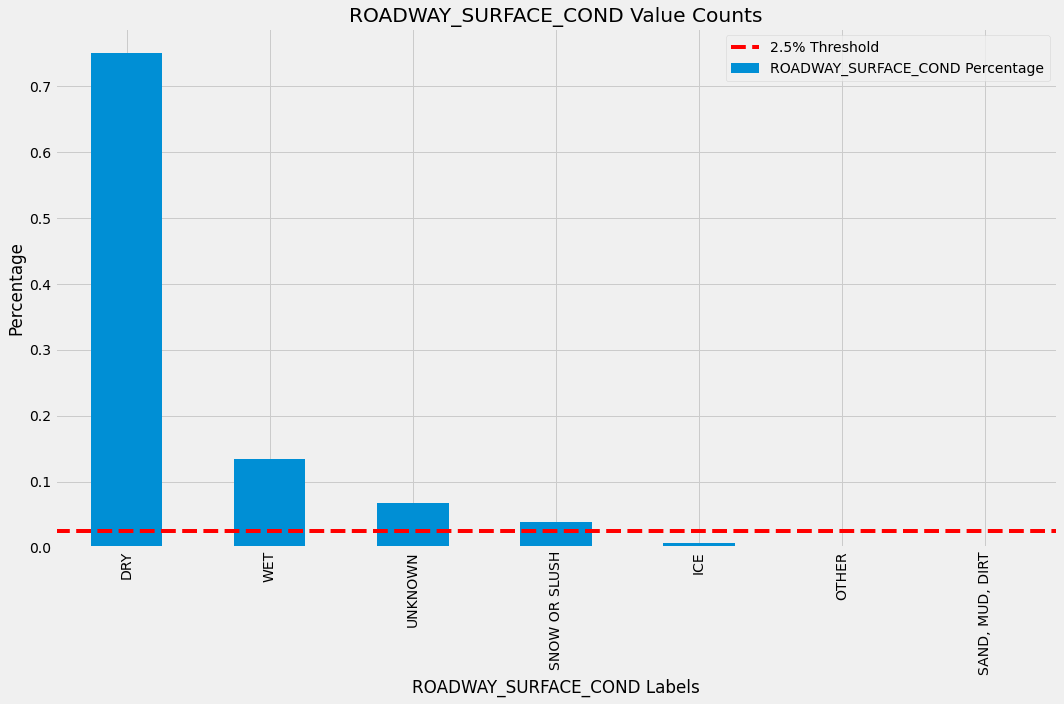

Column Name: ROAD_DEFECT


Number of unique values: 7


There are 533606 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 NO DEFECTS           442293
UNKNOWN               79843
RUT, HOLES             4694
OTHER                  3005
WORN SURFACE           2187
SHOULDER DEFECT        1139
DEBRIS ON ROADWAY       452
Name: ROAD_DEFECT, dtype: int64




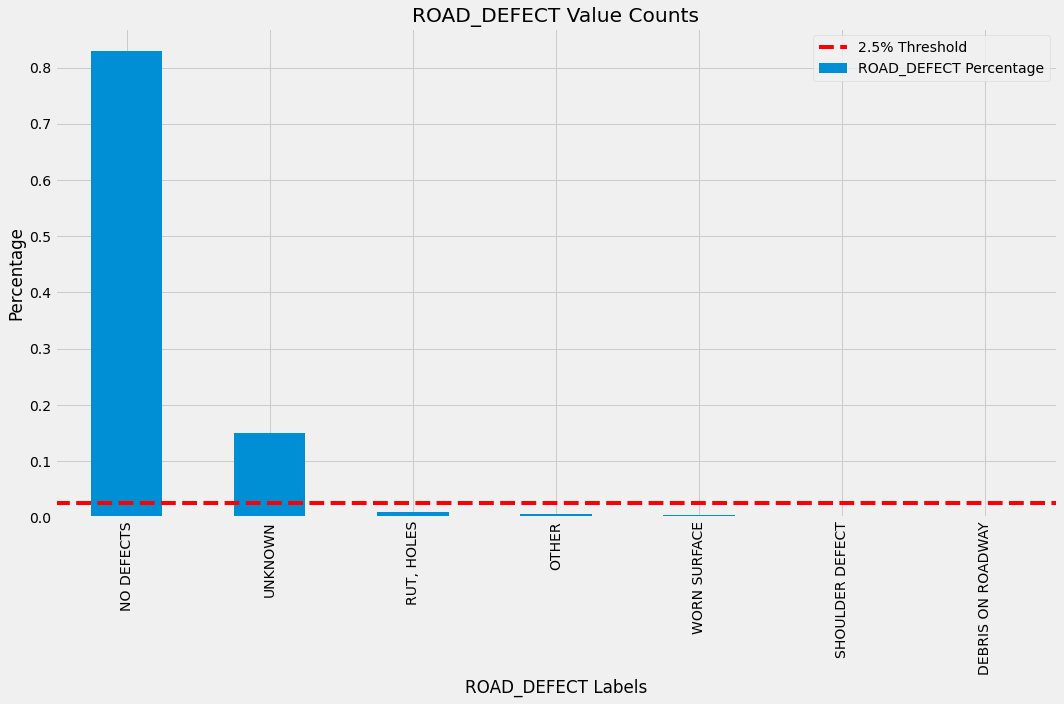

In [40]:
 col_summary(df_crashes_clean, cat_cols=['LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
 'ROAD_DEFECT'])

Column Name: INTERSECTION_RELATED_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    412702
Y          115203
N            5708
Name: INTERSECTION_RELATED_I, dtype: int64




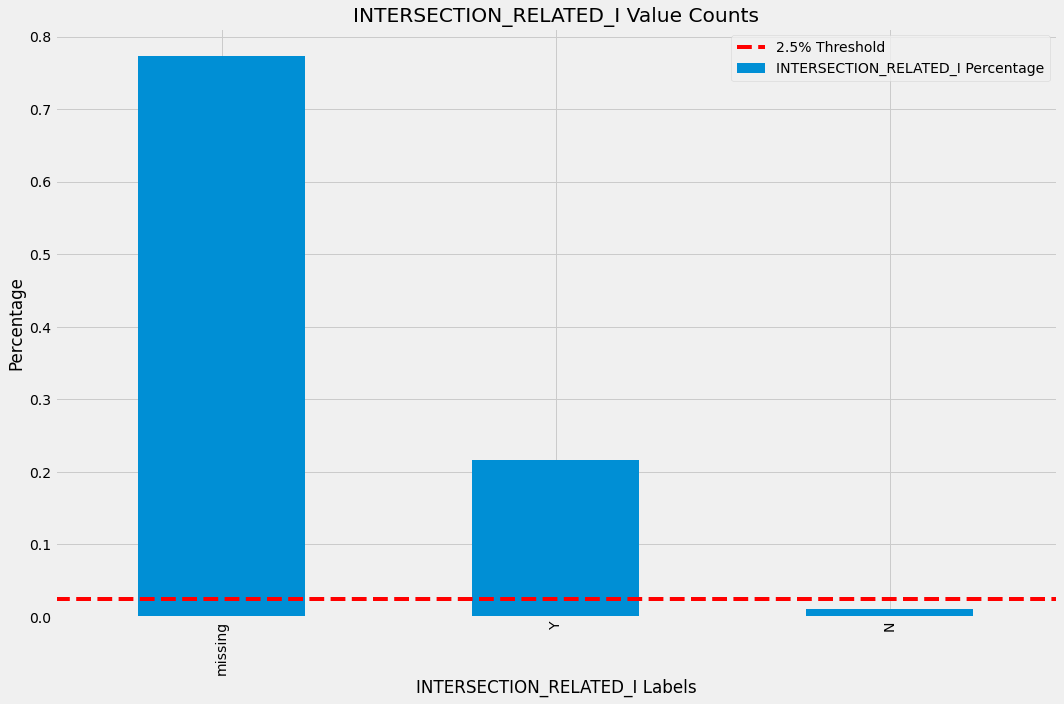

Column Name: NOT_RIGHT_OF_WAY_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    508370
Y           23014
N            2229
Name: NOT_RIGHT_OF_WAY_I, dtype: int64




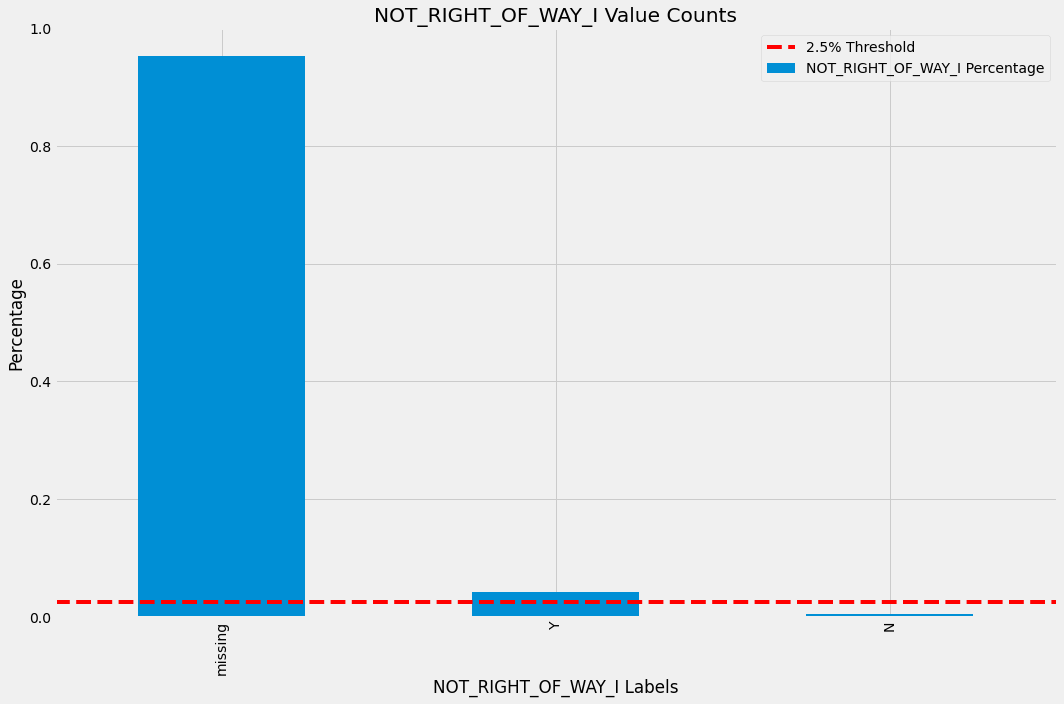

Column Name: HIT_AND_RUN_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    373279
Y          153424
N            6910
Name: HIT_AND_RUN_I, dtype: int64




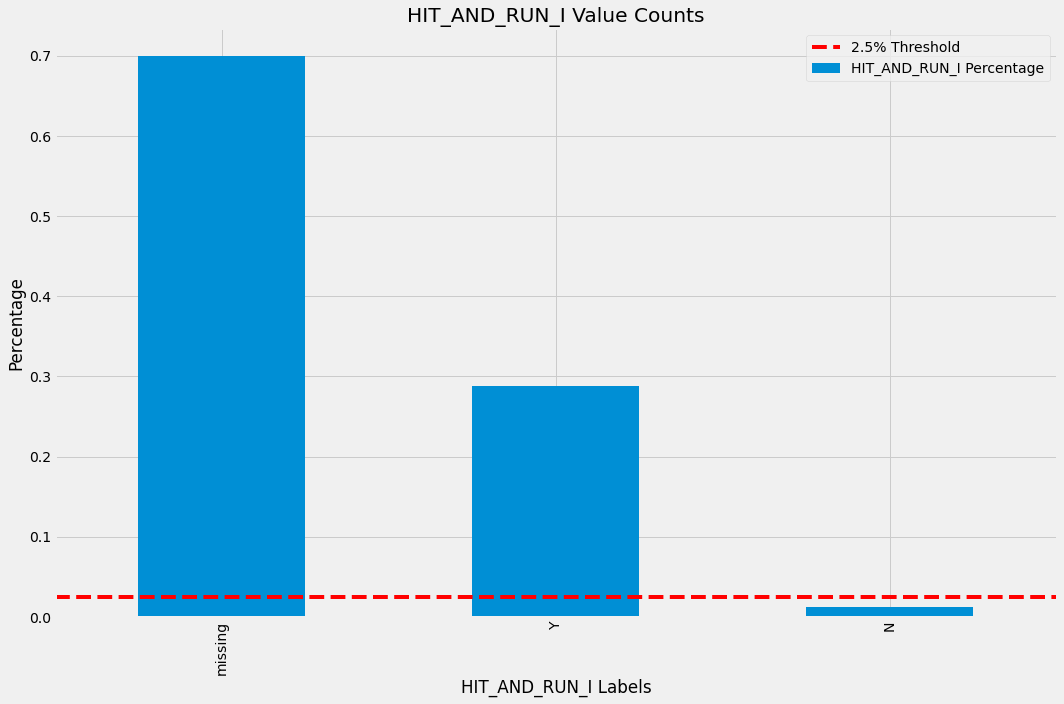

In [41]:
col_summary(df_crashes_clean, cat_cols=['INTERSECTION_RELATED_I',
 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I'])

Column Name: DAMAGE


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 OVER $1,500      312779
$501 - $1,500    153690
$500 OR LESS      67144
Name: DAMAGE, dtype: int64




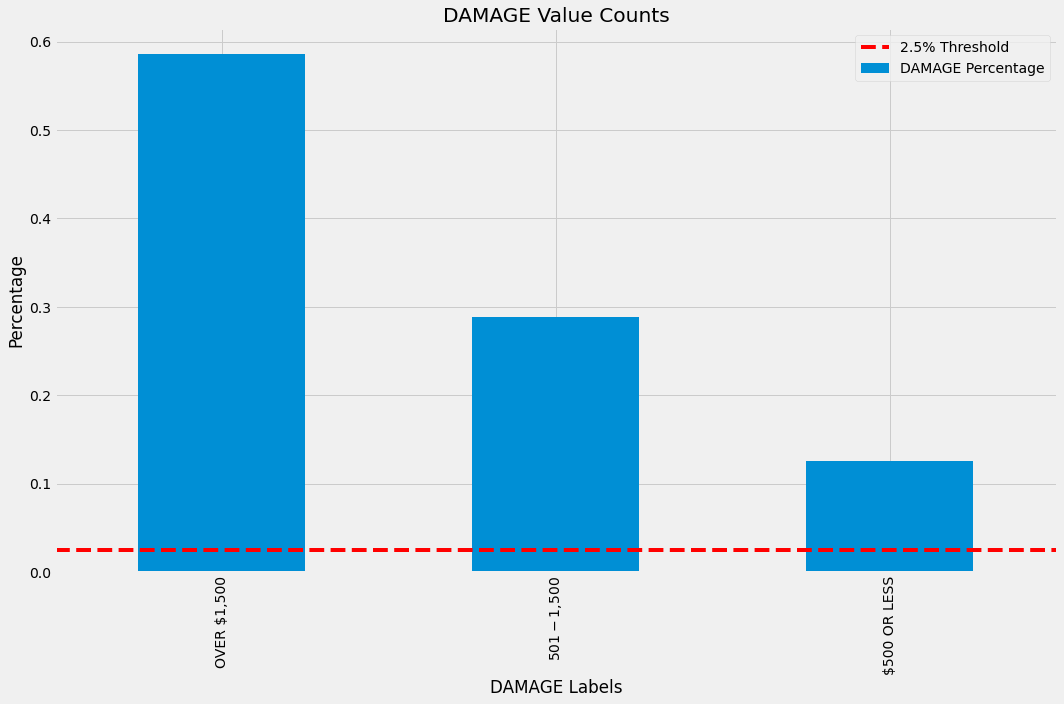

Column Name: DATE_POLICE_NOTIFIED


Number of unique values: 409107


There are 124506 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 02/26/2020 08:30:00 AM    12
10/12/2020 04:00:00 PM    12
09/13/2019 05:00:00 PM    11
06/30/2018 09:30:00 PM    11
02/14/2020 05:00:00 PM    11
                          ..
11/12/2017 07:55:00 AM     1
09/05/2016 12:30:00 AM     1
10/29/2018 01:15:00 PM     1
08/25/2019 01:46:00 PM     1
08/01/2021 05:35:00 PM     1
Name: DATE_POLICE_NOTIFIED, Length: 409107, dtype: int64




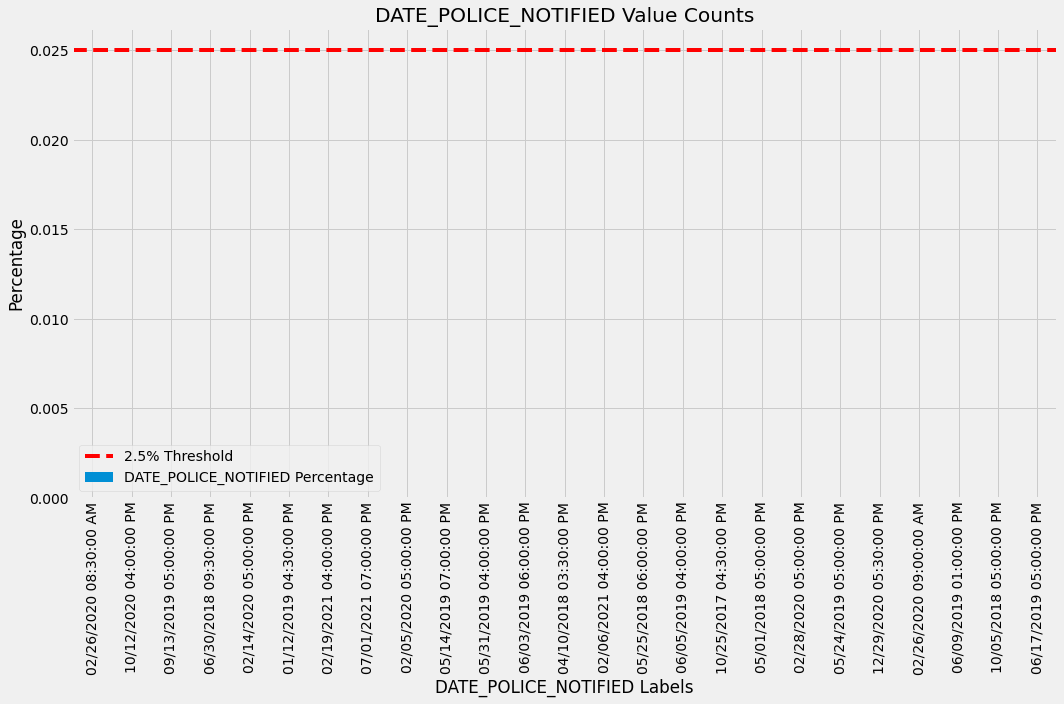

In [42]:
col_summary(df_crashes_clean, cat_cols=['DAMAGE', 'DATE_POLICE_NOTIFIED'])

Column Name: PRIM_CONTRIBUTORY_CAUSE


Number of unique values: 40


There are 533573 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 UNABLE TO DETERMINE                                                                 199424
FAILING TO YIELD RIGHT-OF-WAY                                                        58275
FOLLOWING TOO CLOSELY                                                                55591
NOT APPLICABLE                                                                       28615
IMPROPER OVERTAKING/PASSING                                                          25379
FAILING TO REDUCE SPEED TO AVOID CRASH                                               23090
IMPROPER BACKING                                                                     22966
IMPROPER LANE USAGE                                                                  20358
IMPROPER TURNING/NO SIGNAL                                                           17638
DRIVING SK

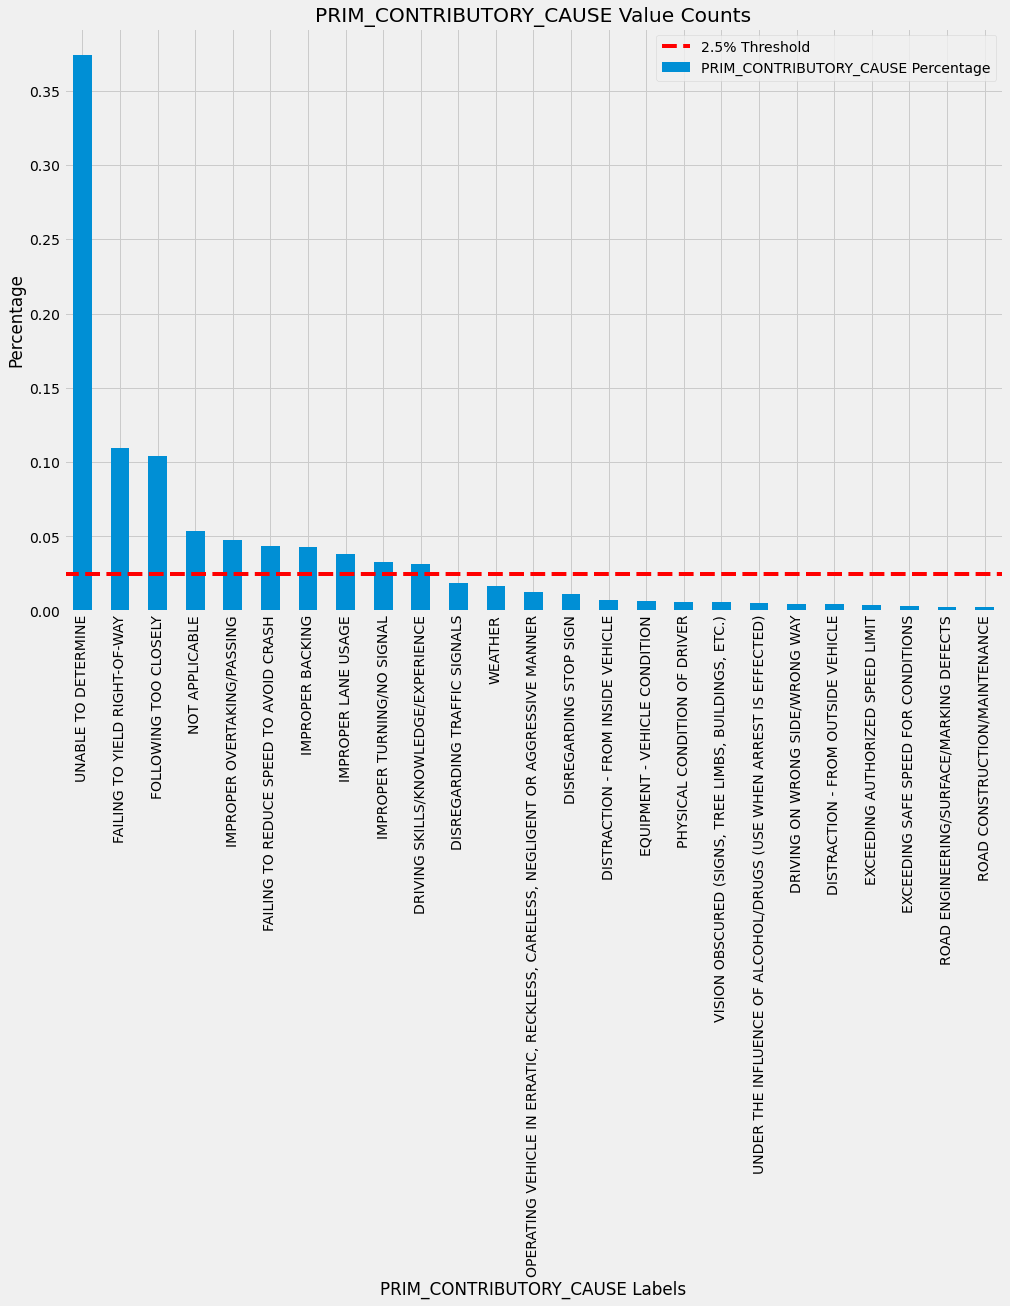

Column Name: SEC_CONTRIBUTORY_CAUSE


Number of unique values: 40


There are 533573 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 NOT APPLICABLE                                                                      216916
UNABLE TO DETERMINE                                                                 191275
FAILING TO REDUCE SPEED TO AVOID CRASH                                               21767
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  16615
FAILING TO YIELD RIGHT-OF-WAY                                                        15991
FOLLOWING TOO CLOSELY                                                                14460
IMPROPER OVERTAKING/PASSING                                                           7888
IMPROPER LANE USAGE                                                                   7648
WEATHER                                                                               6511
IMPROPER TU

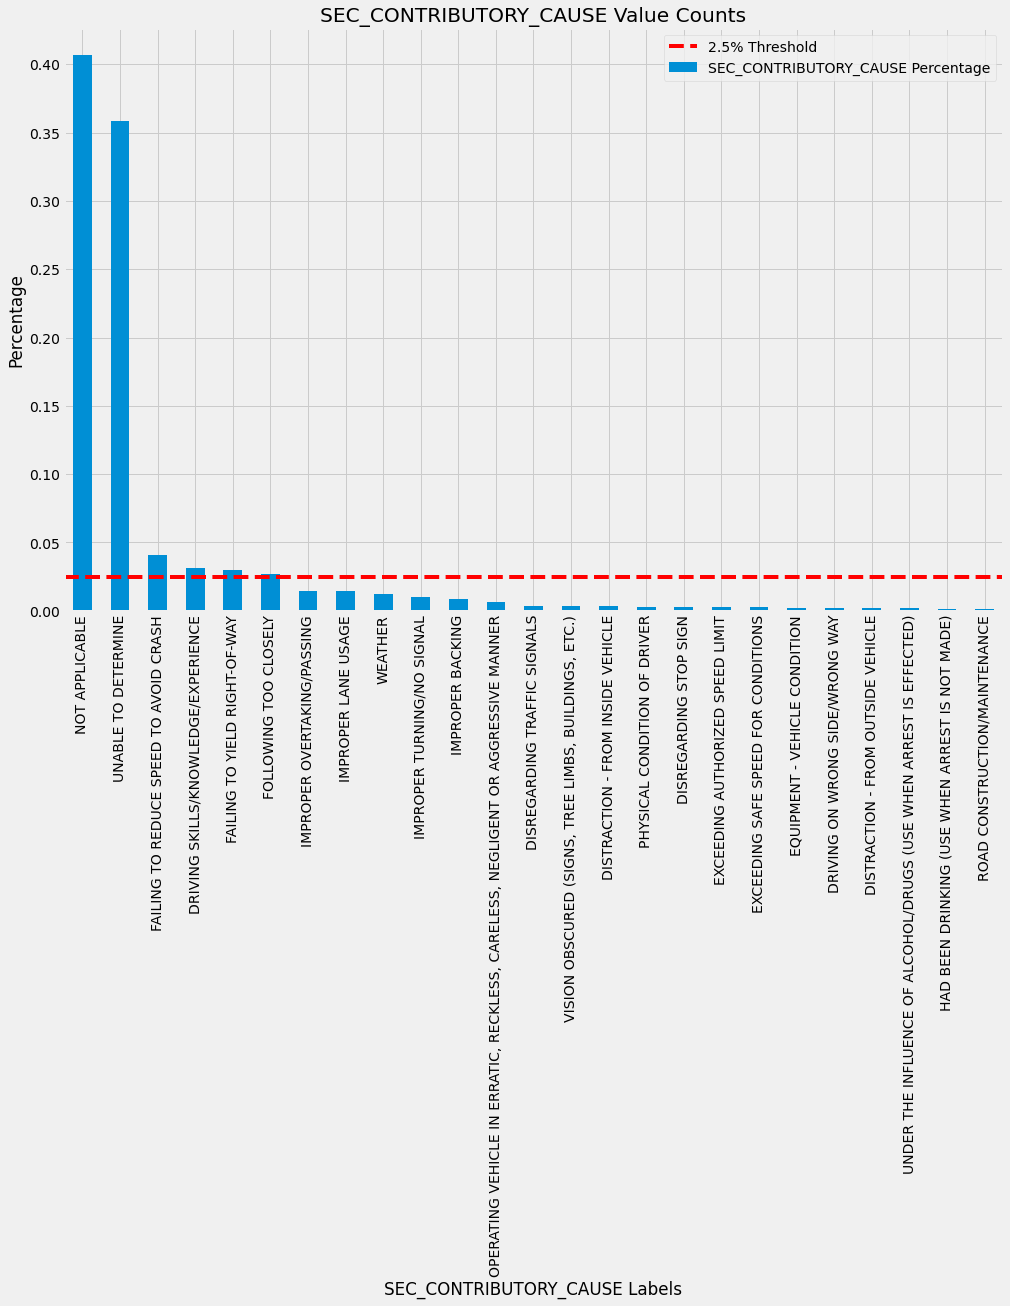

In [43]:
col_summary(df_crashes_clean, cat_cols=["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"])

Column Name: STREET_DIRECTION


Number of unique values: 5


There are 533608 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 W          189912
S          178751
N          127591
E           37356
missing         3
Name: STREET_DIRECTION, dtype: int64




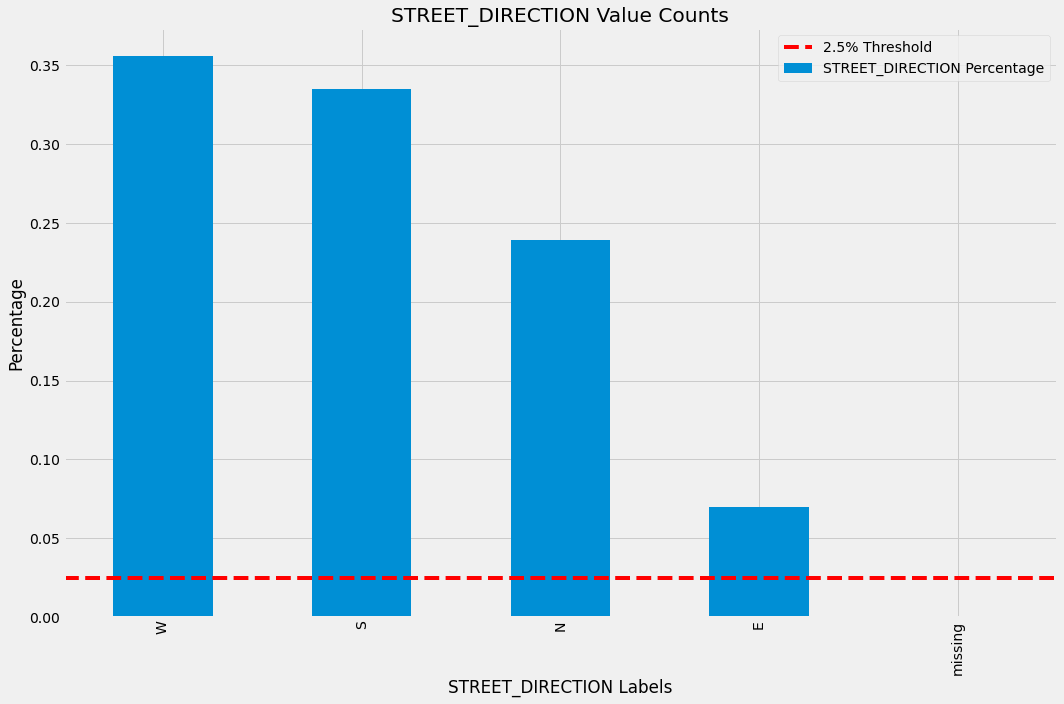

Column Name: STREET_NAME


Number of unique values: 1585


There are 532028 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 WESTERN AVE                 14599
PULASKI RD                  12691
CICERO AVE                  11668
ASHLAND AVE                 11579
HALSTED ST                  10324
                            ...  
MENARD DR                       1
WALTER BURLEY GRIFFIN PL        1
KENOSHA AVE                     1
CASTLE ISLAND AVE               1
GOVERNORS PKWY                  1
Name: STREET_NAME, Length: 1585, dtype: int64




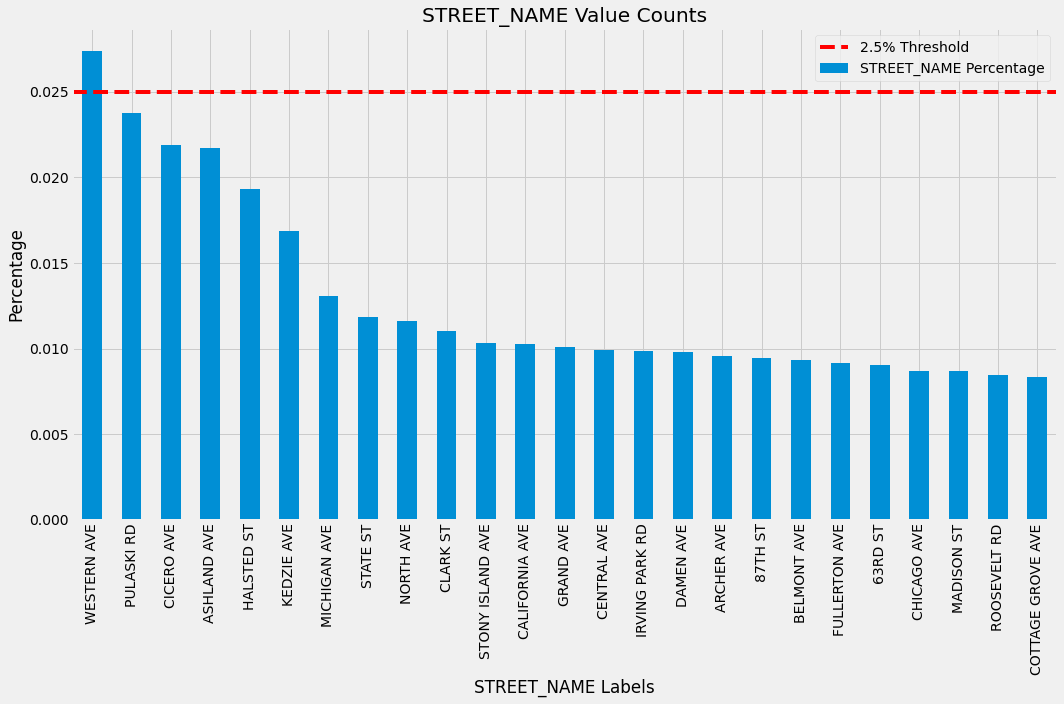

In [44]:
col_summary(df_crashes_clean, cat_cols=['STREET_DIRECTION', 'STREET_NAME'])

Column Name: PHOTOS_TAKEN_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    526952
Y            5159
N            1502
Name: PHOTOS_TAKEN_I, dtype: int64




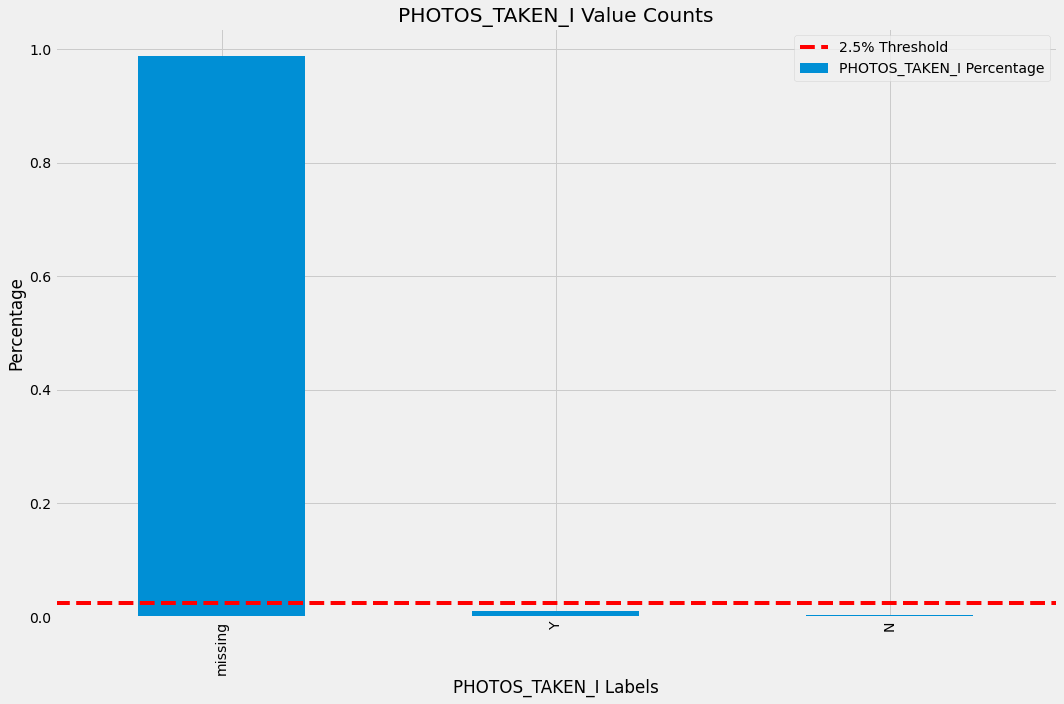

Column Name: STATEMENTS_TAKEN_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    522762
Y            8859
N            1992
Name: STATEMENTS_TAKEN_I, dtype: int64




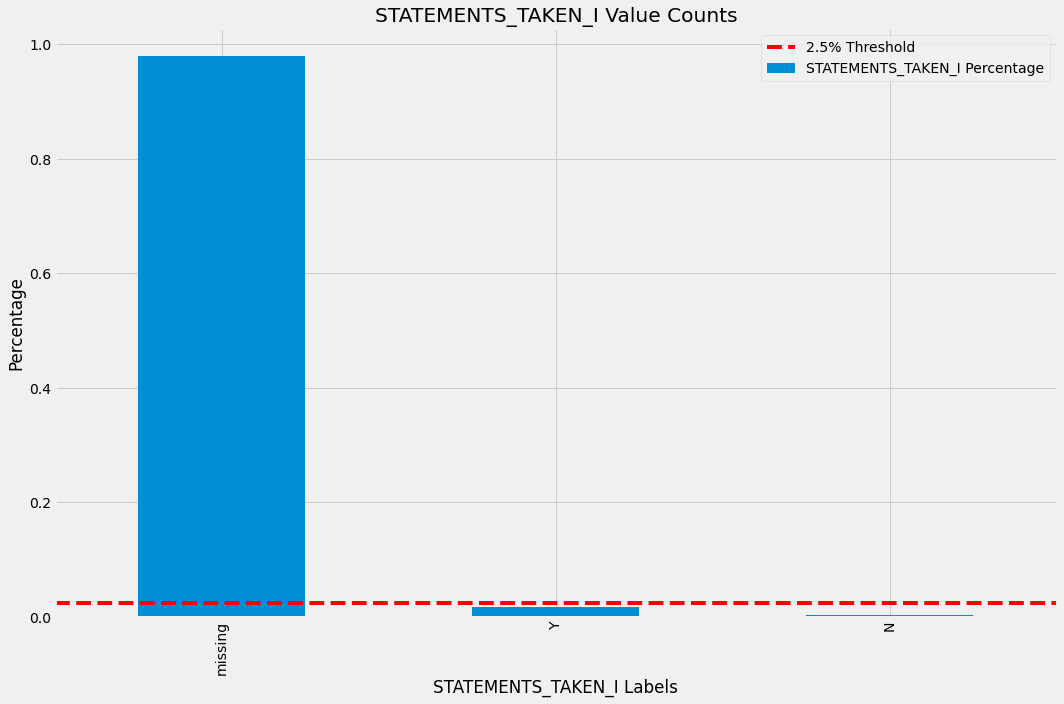

Column Name: DOORING_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    531899
Y            1171
N             543
Name: DOORING_I, dtype: int64




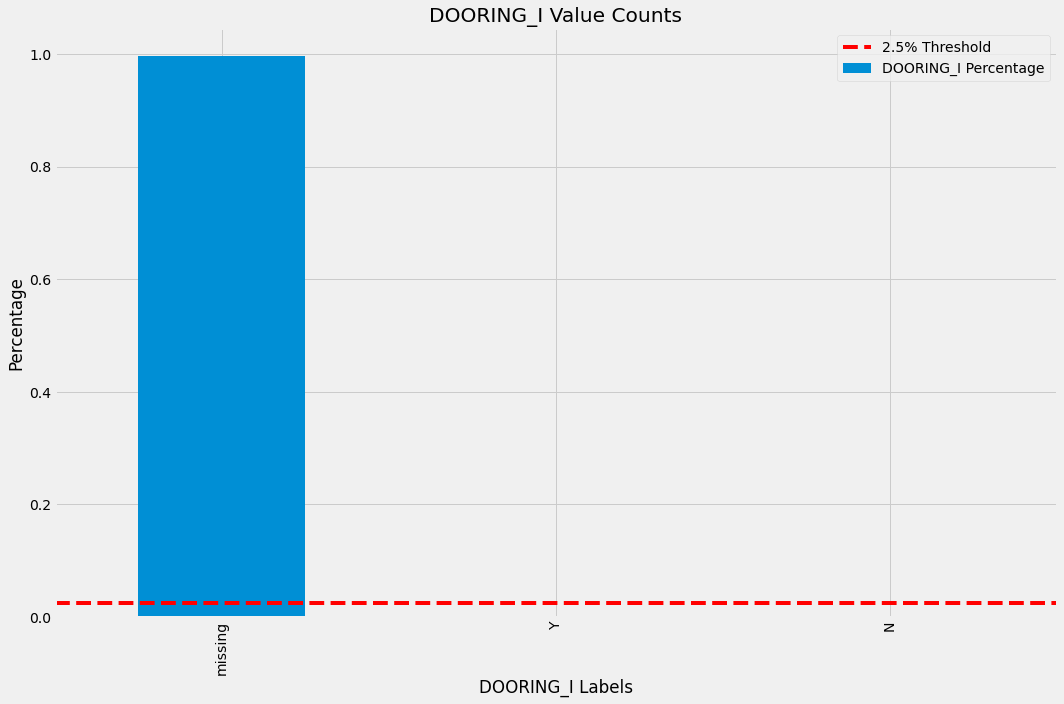

Column Name: WORK_ZONE_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    530250
Y            2659
N             704
Name: WORK_ZONE_I, dtype: int64




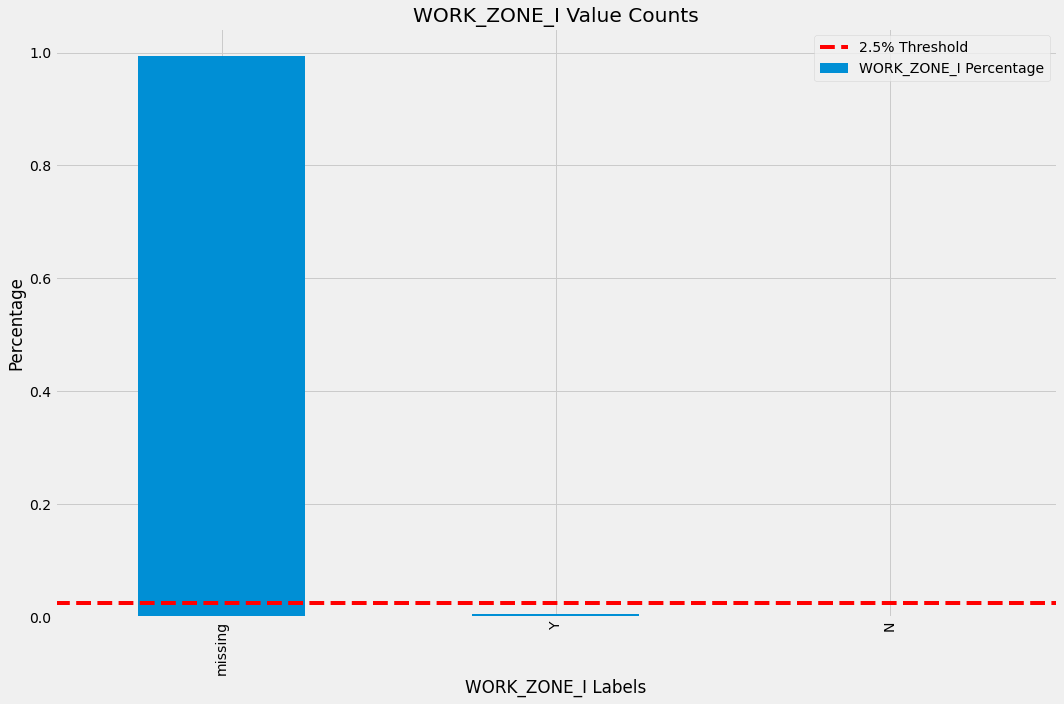

Column Name: WORK_ZONE_TYPE


Number of unique values: 5


There are 533608 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing         530954
CONSTRUCTION      1876
UNKNOWN            348
MAINTENANCE        269
UTILITY            166
Name: WORK_ZONE_TYPE, dtype: int64




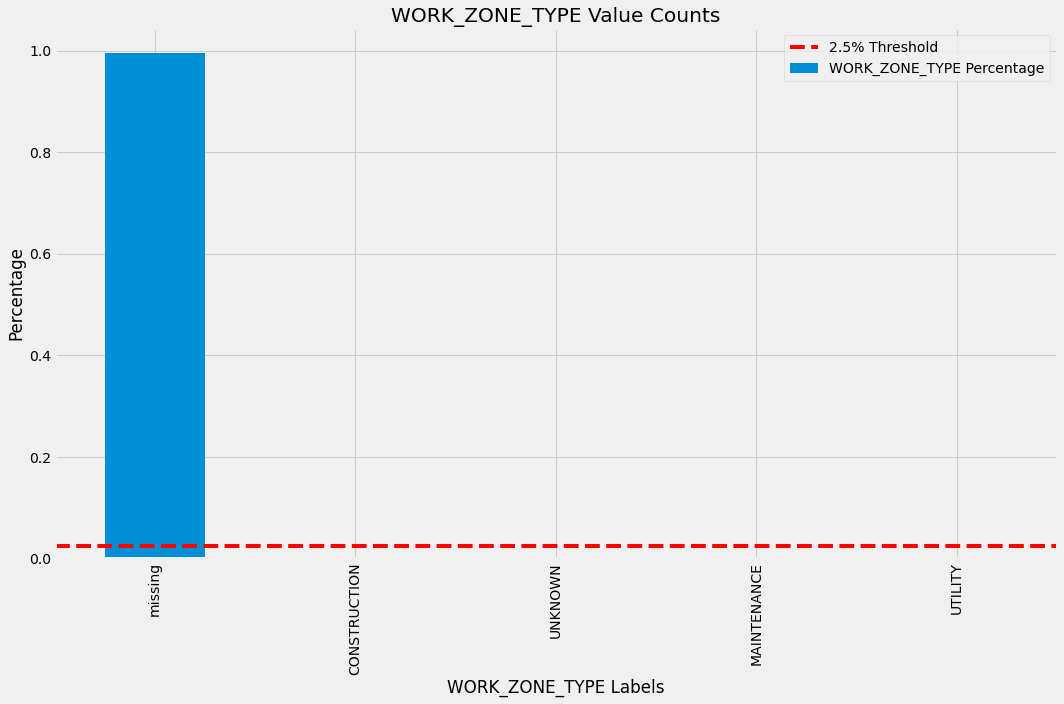

Column Name: WORKERS_PRESENT_I


Number of unique values: 3


There are 533610 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing    532783
Y             741
N              89
Name: WORKERS_PRESENT_I, dtype: int64




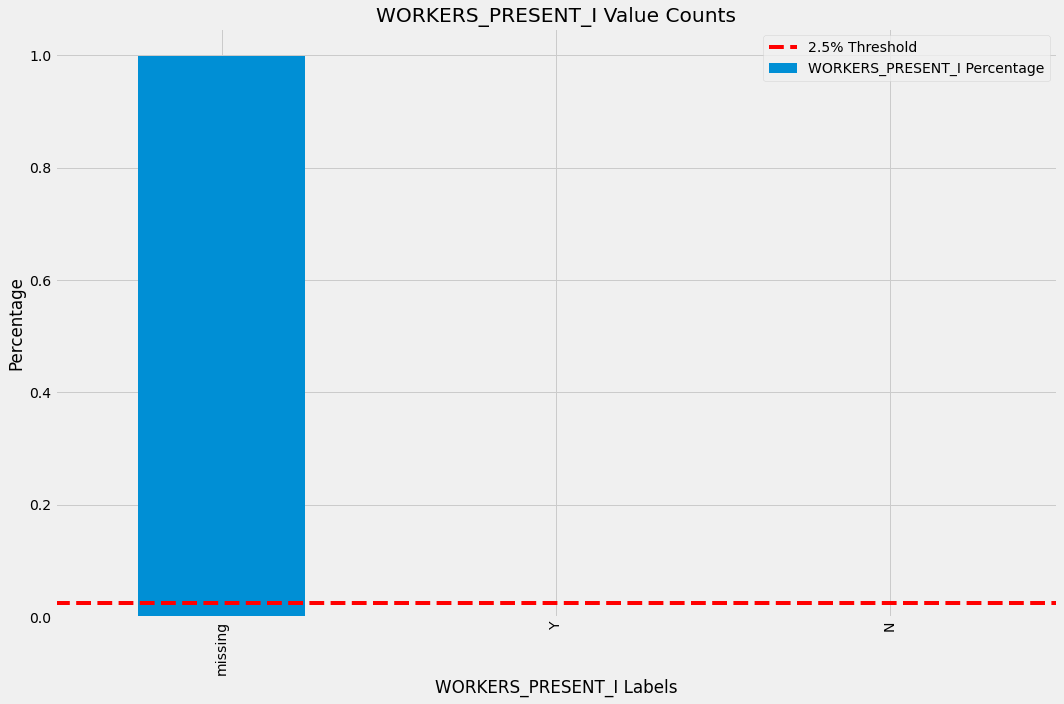

In [45]:
col_summary(df_crashes_clean, cat_cols=['PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 
 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I'])

Column Name: MOST_SEVERE_INJURY


Number of unique values: 6


There are 533607 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 NO INDICATION OF INJURY     462684
NONINCAPACITATING INJURY     38951
REPORTED, NOT EVIDENT        21451
INCAPACITATING INJURY         8894
missing                       1098
FATAL                          535
Name: MOST_SEVERE_INJURY, dtype: int64




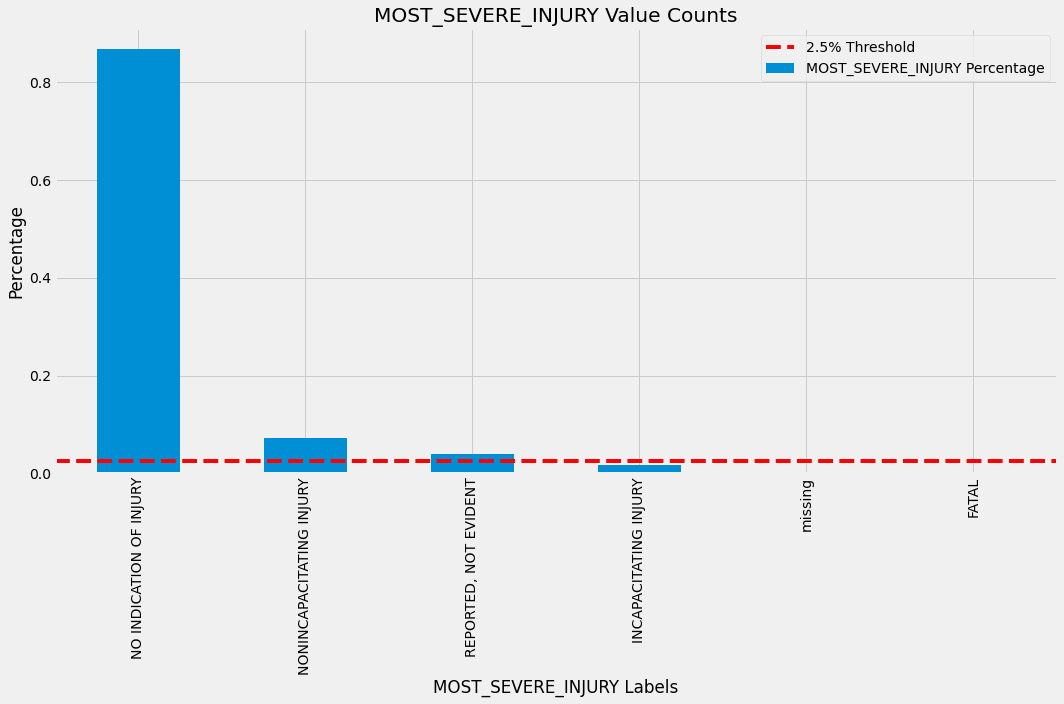

In [46]:
col_summary(df_crashes_clean, cat_cols=["MOST_SEVERE_INJURY"])

Column Name: LOCATION


Number of unique values: 226566


There are 307047 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 missing                                     3049
POINT (-87.905309125103 41.976201139024)     712
POINT (-87.585971992965 41.751460603167)     383
POINT (-87.580147768689 41.791420282098)     364
POINT (-87.585275565077 41.722257273006)     299
                                            ... 
POINT (-87.773502083628 41.88413562824)        1
POINT (-87.667191782816 41.882264266143)       1
POINT (-87.725598946273 41.966555705469)       1
POINT (-87.659839694374 41.899246970564)       1
POINT (-87.611161989864 41.751725575636)       1
Name: LOCATION, Length: 226566, dtype: int64




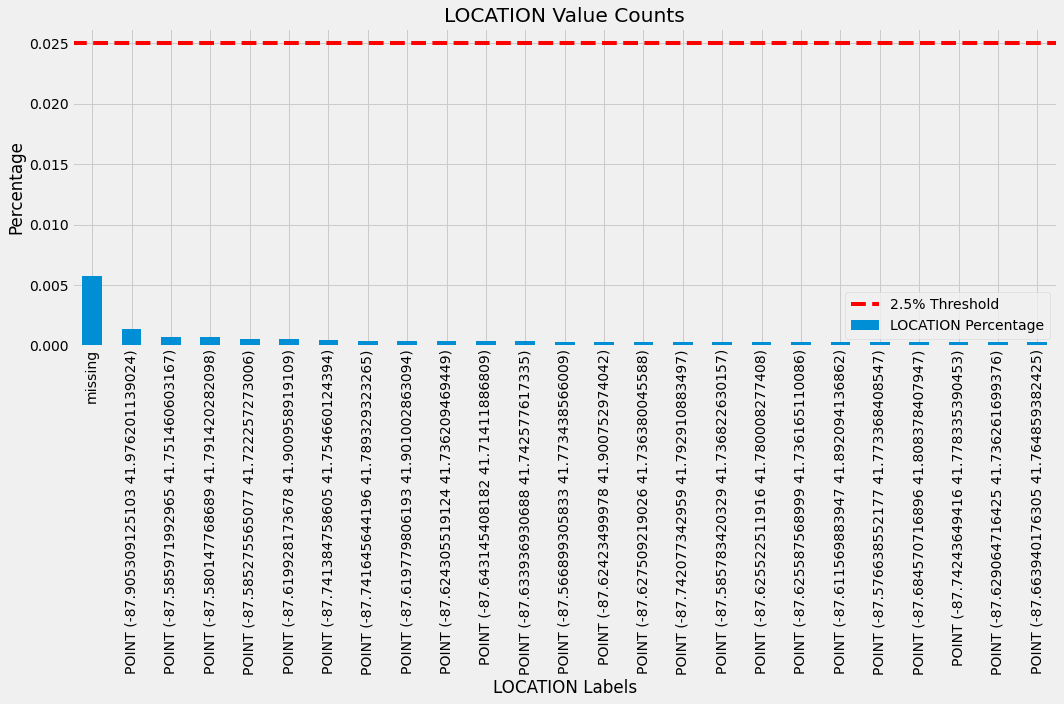

In [47]:
col_summary(df_crashes_clean, cat_cols=["LOCATION"])

-----------------------------------------------------
**Feature evaluation done**



> **Summary of actions to take**
>- recast `STREET_NO` as a string
>- recast  `BEAT_OF_OCCURRENCE` as a string
>- recast `LATITUDE` as a string
>- recast `LONGITUDE` as a string
>- drop `INJURIES_REPORTED_NOT_EVIDENT` column
>- drop `INJURIES_UNKNOWN` column
>- drop `CRASH_DAY_OF_WEEK` column
>- drop ` CRASH_MONTH` column
>- drop `CRASH_DATE` column
>- drop `CRASH_RECORD_ID` column
>- drop `INTERSECTION_RELATED_I` column
>- drop `STREET_DIRECTION` column
>- drop `STREET_NAME` column
>- drop `PHOTOS_TAKEN_I` column
>- drop `STATEMENTS_TAKEN_I` column
>- drop `WORK_ZONE_I` column
>- drop `WORK_ZONE_TYPE` column
>- drop `WORKERS_PRESENT_I` column
>- drop `LANE_CNT` column
>- drop `ALIGNMENT` column

## Data type Recasting

In [48]:
df_crashes_clean.dtypes

CRASH_RECORD_ID                   object
RD_NO                             object
CRASH_DATE_EST_I                  object
CRASH_DATE                        object
POSTED_SPEED_LIMIT                 int64
TRAFFIC_CONTROL_DEVICE            object
DEVICE_CONDITION                  object
WEATHER_CONDITION                 object
LIGHTING_CONDITION                object
FIRST_CRASH_TYPE                  object
TRAFFICWAY_TYPE                   object
LANE_CNT                          object
ALIGNMENT                         object
ROADWAY_SURFACE_COND              object
ROAD_DEFECT                       object
REPORT_TYPE                       object
CRASH_TYPE                        object
INTERSECTION_RELATED_I            object
NOT_RIGHT_OF_WAY_I                object
HIT_AND_RUN_I                     object
DAMAGE                            object
DATE_POLICE_NOTIFIED              object
PRIM_CONTRIBUTORY_CAUSE           object
SEC_CONTRIBUTORY_CAUSE            object
STREET_NO       

In [49]:
#convert STREET_NO to categorical
df_crashes_clean["STREET_NO"] = df_crashes_clean["STREET_NO"].astype(str)

In [50]:
#Convert BEAT_OF_OCCURRENCE to categorical
df_crashes_clean["BEAT_OF_OCCURRENCE"] = df_crashes_clean["BEAT_OF_OCCURRENCE"].astype(str)

In [51]:
# Convert LATITUDE to categorical
df_crashes_clean["LATITUDE"] = df_crashes_clean["LATITUDE"].astype(str)

In [52]:
df_crashes_clean["LONGITUDE"] = df_crashes_clean["LONGITUDE"].astype(str)

In [53]:
df_crashes_clean["CRASH_DATE_YR"] = pd.to_datetime(df_crashes_clean["CRASH_DATE"]).dt.year

In [54]:
df_crashes_clean["CRASH_TYPE"] = df_crashes_clean["CRASH_TYPE"].map(lambda x: x.replace("NO INJURY / DRIVE AWAY", "DRIVE AWAY (NO INJURY)"))
df_crashes_clean["CRASH_TYPE"] = df_crashes_clean["CRASH_TYPE"].map(lambda x: x.replace("INJURY AND / OR TOW DUE TO CRASH","TOW BY CRASH(INJURY)"))

In [55]:
df_crashes_clean

CRASH_RECORD_ID     RD_NO  \
0       4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...  JC343143   
1       009e9e67203442370272e1a13d6ee51a4155dac65e583d...  JA329216   
2       ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...  JD292400   
3       f8960f698e870ebdc60b521b2a141a5395556bc3704191...  JD293602   
4       8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...  JD290451   
...                                                   ...       ...   
533608  9a9db62f3334a1fad706f97c5a4ebb8485668447c176e2...  JE299347   
533609  db31327d28803316b8f44f0ec86d6e76a248934f3d1bfc...  JE295652   
533610  d51aae396db49981c7ee26ceb54dfcab3c4b06d0cc5d7d...  JE298826   
533611  6f9abc7e7f54095cef0fa17e16e6f72eb14f8d17d3b572...  JE300245   
533612  bc361965fe506c50f7899493c79b1f7d011376f753acaa...  JE300060   

       CRASH_DATE_EST_I              CRASH_DATE  POSTED_SPEED_LIMIT  \
0               missing  07/10/2019 05:56:00 PM                  35   
1               missing  06/30/2017 04:00:00 PM                  35   
2               missing  07/10/2020 10:25:00 AM                  30   
3               missing  07/11/2020 01:00:00 AM                  30   
4               missing  07/08/2020 02:00:00 PM                  20   
...                 ...                     ...                 ...   
533608          missing  07/12/2021 06:37:00 PM                  10   
533609          missing  07/07/2021 09:25:00 PM                  30   
533610          missing  07/12/2021 10:00:00 AM                  30   
533611          missing  07/13/2021 04:15:00 PM                  15   
533612          missing  07/13/2021 11:30:00 AM                  30   

       TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0                 NO CONTROLS           NO CONTROLS             CLEAR   
1           STOP SIGN/FLASHER  FUNCTIONING PROPERLY             CLEAR   
2              TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
3                 NO CONTROLS           NO CONTROLS             CLEAR   
4                 NO CONTROLS           NO CONTROLS             CLEAR   
...                       ...                   ...               ...   
533608            NO CONTROLS           NO CONTROLS             CLEAR   
533609         TRAFFIC SIGNAL  FUNCTIONING PROPERLY           UNKNOWN   
533610            NO CONTROLS           NO CONTROLS             CLEAR   
533611            NO CONTROLS           NO CONTROLS             CLEAR   
533612            NO CONTROLS           NO CONTROLS             CLEAR   

       LIGHTING_CONDITION          FIRST_CRASH_TYPE  \
0                DAYLIGHT                   TURNING   
1                DAYLIGHT                   TURNING   
2                DAYLIGHT                  REAR END   
3                DARKNESS      PARKED MOTOR VEHICLE   
4                DAYLIGHT      PARKED MOTOR VEHICLE   
...                   ...                       ...   
533608           DAYLIGHT      PARKED MOTOR VEHICLE   
533609            UNKNOWN  SIDESWIPE SAME DIRECTION   
533610           DAYLIGHT              REAR TO SIDE   
533611           DAYLIGHT      PARKED MOTOR VEHICLE   
533612           DAYLIGHT  SIDESWIPE SAME DIRECTION   

                        TRAFFICWAY_TYPE LANE_CNT           ALIGNMENT  \
0                               ONE-WAY  missing  STRAIGHT AND LEVEL   
1                           NOT DIVIDED      4.0  STRAIGHT AND LEVEL   
2                              FOUR WAY  missing  STRAIGHT AND LEVEL   
3       DIVIDED - W/MEDIAN (NOT RAISED)  missing  STRAIGHT AND LEVEL   
4                              DRIVEWAY  missing  STRAIGHT AND LEVEL   
...                                 ...      ...                 ...   
533608                      PARKING LOT  missing  STRAIGHT AND LEVEL   
533609                      NOT DIVIDED  missing  STRAIGHT AND LEVEL   
533610                          ONE-WAY  missing  STRAIGHT AND LEVEL   
533611                      NOT DIVIDED  missing  STRAIGHT AND LEVEL   
533612

## Feature/Row Drop

In [56]:
df_crashes_clean = df_crashes_clean.drop(columns=["RD_NO","CRASH_DAY_OF_WEEK", "CRASH_MONTH", "CRASH_RECORD_ID", "INTERSECTION_RELATED_I",
                                            "STREET_DIRECTION", "STREET_NAME", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
                                            "WORK_ZONE_I", "WORK_ZONE_TYPE", "WORKERS_PRESENT_I", "LANE_CNT", "ALIGNMENT", "CRASH_DATE_EST_I", "CRASH_DATE",
                                                 "NOT_RIGHT_OF_WAY_I", "HIT_AND_RUN_I", "DATE_POLICE_NOTIFIED", "DOORING_I", "INJURIES_UNKNOWN", "LOCATION"], axis=1)
df_crashes_clean

POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
0                       35            NO CONTROLS           NO CONTROLS   
1                       35      STOP SIGN/FLASHER  FUNCTIONING PROPERLY   
2                       30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
3                       30            NO CONTROLS           NO CONTROLS   
4                       20            NO CONTROLS           NO CONTROLS   
...                    ...                    ...                   ...   
533608                  10            NO CONTROLS           NO CONTROLS   
533609                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
533610                  30            NO CONTROLS           NO CONTROLS   
533611                  15            NO CONTROLS           NO CONTROLS   
533612                  30            NO CONTROLS           NO CONTROLS   

       WEATHER_CONDITION LIGHTING_CONDITION          FIRST_CRASH_TYPE  \
0                  CLEAR           DAYLIGHT                   TURNING   
1                  CLEAR           DAYLIGHT                   TURNING   
2                  CLEAR           DAYLIGHT                  REAR END   
3                  CLEAR           DARKNESS      PARKED MOTOR VEHICLE   
4                  CLEAR           DAYLIGHT      PARKED MOTOR VEHICLE   
...                  ...                ...                       ...   
533608             CLEAR           DAYLIGHT      PARKED MOTOR VEHICLE   
533609           UNKNOWN            UNKNOWN  SIDESWIPE SAME DIRECTION   
533610             CLEAR           DAYLIGHT              REAR TO SIDE   
533611             CLEAR           DAYLIGHT      PARKED MOTOR VEHICLE   
533612             CLEAR           DAYLIGHT  SIDESWIPE SAME DIRECTION   

                        TRAFFICWAY_TYPE ROADWAY_SURFACE_COND ROAD_DEFECT  \
0                               ONE-WAY                  DRY  NO DEFECTS   
1                           NOT DIVIDED                  DRY  NO DEFECTS   
2                              FOUR WAY                  DRY  NO DEFECTS   
3       DIVIDED - W/MEDIAN (NOT RAISED)                  DRY  NO DEFECTS   
4                              DRIVEWAY                  DRY  NO DEFECTS   
...                                 ...                  ...         ...   
533608                      PARKING LOT                  DRY  NO DEFECTS   
533609                      NOT DIVIDED              UNKNOWN     UNKNOWN   
533610                          ONE-WAY                  DRY  NO DEFECTS   
533611                      NOT DIVIDED                  DRY  NO DEFECTS   
533612  DIVIDED - W/MEDIAN (NOT RAISED)                  DRY  NO DEFECTS   

                       REPORT_TYPE              CRASH_TYPE        DAMAGE  \
0                         ON SCENE  DRIVE AWAY (NO INJURY)   OVER $1,500   
1                         ON SCENE    TOW BY CRASH(INJURY)   OVER $1,500   
2                         ON SCENE  DRIVE AWAY (NO INJURY)   OVER $1,500   
3       NOT ON SCENE (DESK REPORT)  DRIVE AWAY (NO INJURY)  $500 OR LESS   
4                         ON SCENE  DRIVE AWAY (NO INJURY)   OVER $1,500   
...                            ...                     ...           ...   
533608                    ON SCENE  DRIVE AWAY (NO INJURY)  $500 OR LESS   
533609  NOT ON SCENE (DESK REPORT)  DRIVE AWAY (NO INJURY)  $500 OR LESS   
533610  NOT ON SCENE (DESK REPORT)    TOW BY CRASH(INJURY)   OVER $1,500   
533611  NOT ON SCENE (DESK REPORT)  DRIVE AWAY (NO INJURY)   OVER $1,500   
533612  NOT ON SCENE (DESK REPORT)  DRIVE AWAY (NO INJURY)   OVER $1,500   

              PRIM_CONTRIBUTORY_CAUSE         SEC_CONTRIBUTORY_CAUSE  \
0                    IMPROPER BACKING            UNABLE TO DETERMINE   
1       FAILING TO YIELD RIGHT-OF-WAY                 NOT APPLICABLE   
2       FAILING TO YIELD RIGHT-OF-WAY  FAILING TO YIELD RIGHT-OF-WAY   
3                 UNABLE TO DETERMINE            UNABLE TO DETERMINE   
4                 UNABLE TO DETERMINE       

## Feature Selection

In [57]:
df_crashes_clean = drop_quasi_const(df_crashes_clean)
df_crashes_clean

POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
0                       35            NO CONTROLS           NO CONTROLS   
1                       35      STOP SIGN/FLASHER  FUNCTIONING PROPERLY   
2                       30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
3                       30            NO CONTROLS           NO CONTROLS   
4                       20            NO CONTROLS           NO CONTROLS   
...                    ...                    ...                   ...   
533608                  10            NO CONTROLS           NO CONTROLS   
533609                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
533610                  30            NO CONTROLS           NO CONTROLS   
533611                  15            NO CONTROLS           NO CONTROLS   
533612                  30            NO CONTROLS           NO CONTROLS   

       WEATHER_CONDITION LIGHTING_CONDITION          FIRST_CRASH_TYPE  \
0                  CLEAR           DAYLIGHT                   TURNING   
1                  CLEAR           DAYLIGHT                   TURNING   
2                  CLEAR           DAYLIGHT                  REAR END   
3                  CLEAR           DARKNESS      PARKED MOTOR VEHICLE   
4                  CLEAR           DAYLIGHT      PARKED MOTOR VEHICLE   
...                  ...                ...                       ...   
533608             CLEAR           DAYLIGHT      PARKED MOTOR VEHICLE   
533609           UNKNOWN            UNKNOWN  SIDESWIPE SAME DIRECTION   
533610             CLEAR           DAYLIGHT              REAR TO SIDE   
533611             CLEAR           DAYLIGHT      PARKED MOTOR VEHICLE   
533612             CLEAR           DAYLIGHT  SIDESWIPE SAME DIRECTION   

                        TRAFFICWAY_TYPE ROADWAY_SURFACE_COND ROAD_DEFECT  \
0                               ONE-WAY                  DRY  NO DEFECTS   
1                           NOT DIVIDED                  DRY  NO DEFECTS   
2                              FOUR WAY                  DRY  NO DEFECTS   
3       DIVIDED - W/MEDIAN (NOT RAISED)                  DRY  NO DEFECTS   
4                              DRIVEWAY                  DRY  NO DEFECTS   
...                                 ...                  ...         ...   
533608                      PARKING LOT                  DRY  NO DEFECTS   
533609                      NOT DIVIDED              UNKNOWN     UNKNOWN   
533610                          ONE-WAY                  DRY  NO DEFECTS   
533611                      NOT DIVIDED                  DRY  NO DEFECTS   
533612  DIVIDED - W/MEDIAN (NOT RAISED)                  DRY  NO DEFECTS   

                       REPORT_TYPE              CRASH_TYPE        DAMAGE  \
0                         ON SCENE  DRIVE AWAY (NO INJURY)   OVER $1,500   
1                         ON SCENE    TOW BY CRASH(INJURY)   OVER $1,500   
2                         ON SCENE  DRIVE AWAY (NO INJURY)   OVER $1,500   
3       NOT ON SCENE (DESK REPORT)  DRIVE AWAY (NO INJURY)  $500 OR LESS   
4                         ON SCENE  DRIVE AWAY (NO INJURY)   OVER $1,500   
...                            ...                     ...           ...   
533608                    ON SCENE  DRIVE AWAY (NO INJURY)  $500 OR LESS   
533609  NOT ON SCENE (DESK REPORT)  DRIVE AWAY (NO INJURY)  $500 OR LESS   
533610  NOT ON SCENE (DESK REPORT)    TOW BY CRASH(INJURY)   OVER $1,500   
533611  NOT ON SCENE (DESK REPORT)  DRIVE AWAY (NO INJURY)   OVER $1,500   
533612  NOT ON SCENE (DESK REPORT)  DRIVE AWAY (NO INJURY)   OVER $1,500   

              PRIM_CONTRIBUTORY_CAUSE         SEC_CONTRIBUTORY_CAUSE  \
0                    IMPROPER BACKING            UNABLE TO DETERMINE   
1       FAILING TO YIELD RIGHT-OF-WAY                 NOT APPLICABLE   
2       FAILING TO YIELD RIGHT-OF-WAY  FAILING TO YIELD RIGHT-OF-WAY   
3                 UNABLE TO DETERMINE            UNABLE TO DETERMINE   
4                 UNABLE TO DETERMINE       

In [58]:
df_crashes_clean = rows_to_drop(df_crashes_clean,
                                y="PRIM_CONTRIBUTORY_CAUSE")

In [59]:
df_crashes_clean = rows_to_drop(df_crashes_clean,
                                y="SEC_CONTRIBUTORY_CAUSE")

In [60]:
df_crashes_clean = rows_to_drop_unknown(df_crashes_clean, y="LIGHTING_CONDITION")

## Feature Engineering

### `SEVERELY_INJURED`

In [61]:
df_crashes_clean["SEVERELY_INJURED"] = df_crashes_clean["INJURIES_TOTAL"] >=2
df_crashes_clean["SEVERELY_INJURED"].value_counts()

False    112252
True       6033
Name: SEVERELY_INJURED, dtype: int64

### `DEAD`

In [62]:
df_crashes_clean["DEAD"] = df_crashes_clean["INJURIES_TOTAL"] >= 5
df_crashes_clean["DEAD"].value_counts()

False    117949
True        336
Name: DEAD, dtype: int64

## Train-test Split

In [63]:
# Create train-test split
X = df_crashes_clean.drop(columns="CRASH_TYPE")
y = df_crashes_clean["CRASH_TYPE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82799, 29), (35486, 29), (82799,), (35486,))

In [65]:
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

In this section I will create new features which will improve the ability to gain insights into the data and help modeling.

# Data Exploration


In [66]:
# create data exploration df
df_explore = pd.concat([X_train_tf, X_test_tf], axis=0)
df_explore["CRASH_TYPE"] = pd.concat([y_train, y_test], axis=0)

In [67]:
df_explore

LIGHTING_CONDITION  \
107521                DAYLIGHT   
83409   DARKNESS, LIGHTED ROAD   
61500                 DAYLIGHT   
10517                 DAYLIGHT   
82852                 DAYLIGHT   
...                        ...   
46526                 DAYLIGHT   
38515   DARKNESS, LIGHTED ROAD   
26745                 DAYLIGHT   
31627                 DAYLIGHT   
70794                 DAYLIGHT   

                                   SEC_CONTRIBUTORY_CAUSE  \
107521                                            WEATHER   
83409                   DISTRACTION - FROM INSIDE VEHICLE   
61500                               FOLLOWING TOO CLOSELY   
10517              FAILING TO REDUCE SPEED TO AVOID CRASH   
82852   OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...   
...                                                   ...   
46526                                             WEATHER   
38515                       FAILING TO YIELD RIGHT-OF-WAY   
26745              FAILING TO REDUCE SPEED TO AVOID CRASH   
31627                          IMPROPER TURNING/NO SIGNAL   
70794                          IMPROPER TURNING/NO SIGNAL   

                   PRIM_CONTRIBUTORY_CAUSE  POSTED_SPEED_LIMIT  \
107521       FAILING TO YIELD RIGHT-OF-WAY                  30   
83409     EXCEEDING AUTHORIZED SPEED LIMIT                  10   
61500   DISTRACTION - FROM OUTSIDE VEHICLE                  35   
10517                  IMPROPER LANE USAGE                  30   
82852                FOLLOWING TOO CLOSELY                  30   
...                                    ...                 ...   
46526                              WEATHER                  30   
38515                  IMPROPER LANE USAGE                  30   
26745         PHYSICAL CONDITION OF DRIVER                  30   
31627        FAILING TO YIELD RIGHT-OF-WAY                  30   
70794           IMPROPER TURNING/NO SIGNAL                  30   

       TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION       WEATHER_CONDITION  \
107521            NO CONTROLS           NO CONTROLS                    RAIN   
83409             NO CONTROLS           NO CONTROLS                   CLEAR   
61500             NO CONTROLS           NO CONTROLS                   CLEAR   
10517             NO CONTROLS           NO CONTROLS                   CLEAR   
82852             NO CONTROLS           NO CONTROLS                   CLEAR   
...                       ...                   ...                     ...   
46526             NO CONTROLS           NO CONTROLS  SEVERE CROSS WIND GATE   
38515             NO CONTROLS           NO CONTROLS                   CLEAR   
26745             NO CONTROLS           NO CONTROLS                   CLEAR   
31627          TRAFFIC SIGNAL  FUNCTIONING PROPERLY                    RAIN   
70794          TRAFFIC SIGNAL  FUNCTIONING PROPERLY                 UNKNOWN   

                FIRST_CRASH_TYPE                  TRAFFICWAY_TYPE  \
107521  SIDESWIPE SAME DIRECTION                          ONE-WAY   
83409                      ANGLE                            ALLEY   
61500                   REAR END       DIVIDED - W/MEDIAN BARRIER   
10517       PARKED MOTOR VEHICLE                      NOT DIVIDED   
82852                   REAR END                      NOT DIVIDED   
...                          ...                              ...   
46526               OTHER OBJECT                      NOT DIVIDED   
38515   SIDESWIPE SAME DIRECTION  DIVIDED - W/MEDIAN (NOT RAISED)   
26745                   REAR END                      NOT DIVIDED   
31627                    TURNING                         FOUR WAY   
70794   SIDESWIPE SAME DIRECTION                      NOT DIVIDED   

       ROADWAY_SURFACE_COND ROAD_DEFECT                 REPORT_TYPE  \
107521        SNOW OR SLUSH  NO DEFECTS  NOT ON SCENE (DESK REPORT)   
83409                   DRY  NO DEFECTS  NOT ON SCENE (DESK REPORT)   
61500                   DRY  NO DEFECTS                    ON SCENE   
10517          

In [68]:
#Make a copy for linear assumptions check
df_explore_binary = df_explore.copy()

In [69]:
#Convert DEAD to 0 or 1
# df_explore["DEAD"] = df_explore["DEAD"].map({0:False, 1:True})

In [70]:
df_explore["CRASH_TYPE"].value_counts()

DRIVE AWAY (NO INJURY)    79501
TOW BY CRASH(INJURY)      38784
Name: CRASH_TYPE, dtype: int64

# Data Modeling

I will take 2 major steps in preprocessing the data for modeling:
1. Scale numerical data
2. Encode categorical data

## Model Preprocessing

In [71]:
#training columns
X_train_tf.columns

Index(['LIGHTING_CONDITION', 'SEC_CONTRIBUTORY_CAUSE',
       'PRIM_CONTRIBUTORY_CAUSE', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'DAMAGE', 'STREET_NO',
       'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'MOST_SEVERE_INJURY',
       'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
       'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
       'INJURIES_NO_INDICATION', 'CRASH_HOUR', 'LATITUDE', 'LONGITUDE',
       'CRASH_DATE_YR', 'SEVERELY_INJURED', 'DEAD'],
      dtype='object')

In [72]:
X_train_tf.drop(columns=["LATITUDE", "LONGITUDE"], axis=1, inplace=True)
X_test_tf.drop(columns=["LATITUDE", "LONGITUDE"], axis=1, inplace=True)

In [73]:
X_test_tf.drop("STREET_NO", axis=1, inplace=True)
X_train_tf.drop("STREET_NO", axis=1, inplace=True)

In [74]:
cat_cols = X_train_tf.select_dtypes(include="object").columns
num_cols = X_train_tf.select_dtypes(exclude="object").columns
num_cols

Index(['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'CRASH_HOUR',
       'CRASH_DATE_YR', 'SEVERELY_INJURED', 'DEAD'],
      dtype='object')

In [75]:
cat_cols

Index(['LIGHTING_CONDITION', 'SEC_CONTRIBUTORY_CAUSE',
       'PRIM_CONTRIBUTORY_CAUSE', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'DAMAGE',
       'BEAT_OF_OCCURRENCE', 'MOST_SEVERE_INJURY'],
      dtype='object')

In [76]:
ohe = OneHotEncoder(sparse=False, drop="first")
ohe.fit(X_train_tf[cat_cols])
train_ohe_df = pd.DataFrame(ohe.transform(X_train_tf[cat_cols]),
                           columns=ohe.get_feature_names(cat_cols),
                            index=X_train_tf.index)

test_ohe_df = pd.DataFrame(ohe.transform(X_test_tf[cat_cols]),
                           columns=ohe.get_feature_names(cat_cols),
                           index=X_test_tf.index)


In [77]:
test_ohe_df

LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD  LIGHTING_CONDITION_DAWN  \
28962                                         1.0                      0.0   
35519                                         0.0                      0.0   
100787                                        1.0                      0.0   
71140                                         0.0                      0.0   
114412                                        0.0                      0.0   
...                                           ...                      ...   
46526                                         0.0                      0.0   
38515                                         1.0                      0.0   
26745                                         0.0                      0.0   
31627                                         0.0                      0.0   
70794                                         0.0                      0.0   

        LIGHTING_CONDITION_DAYLIGHT  LIGHTING_CONDITION_DUSK  \
28962                           0.0                      0.0   
35519                           1.0                      0.0   
100787                          0.0                      0.0   
71140                           1.0                      0.0   
114412                          1.0                      0.0   
...                             ...                      ...   
46526                           1.0                      0.0   
38515                           0.0                      0.0   
26745                           1.0                      0.0   
31627                           1.0                      0.0   
70794                           1.0                      0.0   

        SEC_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT  \
28962                                                 0.0               
35519                                                 0.0               
100787                                                0.0               
71140                                                 0.0               
114412                                                0.0               
...                                                   ...               
46526                                                 0.0               
38515                                                 0.0               
26745                                                 0.0               
31627                                                 0.0               
70794                                                 0.0               

        SEC_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING  \
28962                                                 0.0          
35519                                                 0.0          
100787                                                0.0          
71140                                                 0.0          
114412                                                0.0          
...                                                   ...          
46526                                                 0.0          
38515                                                 0.0          
26745                                                 0.0          
31627                                                 0.0          
70794                                                 0.0          

        SEC_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS  \
28962                                                 0.0         
35519                                                 0.0         
100787                                                0.0         
71140                                                 0.0         
114412                                                0.0         
...                                                   ...         
46526                                                 0.0         
38515                                                 0.0         
26745

In [78]:
scaler = StandardScaler()
scaler.fit(X_train_tf[num_cols])

train_scale_df = pd.DataFrame(scaler.transform(X_train_tf[num_cols]),
                             columns=num_cols, index=X_train_tf.index)\

test_scale_df = pd.DataFrame(scaler.transform(X_test_tf[num_cols]),
                             columns=num_cols, index=X_test_tf.index)

In [79]:
test_scale_df

POSTED_SPEED_LIMIT            NUM_UNITS      INJURIES_TOTAL  \
28962  0.15328513149026546 -0.15195031898352457 -0.3774419405364637   
35519  0.15328513149026546 -0.15195031898352457  1.0956572218977136   
100787 0.15328513149026546 -0.15195031898352457  1.0956572218977136   
71140  0.15328513149026546 -0.15195031898352457 -0.3774419405364637   
114412 0.15328513149026546 -0.15195031898352457 -0.3774419405364637   
...                    ...                  ...                 ...   
46526  0.15328513149026546  -2.1531169265096612 -0.3774419405364637   
38515  0.15328513149026546 -0.15195031898352457 -0.3774419405364637   
26745  0.15328513149026546 -0.15195031898352457  1.0956572218977136   
31627  0.15328513149026546    1.849216288542612 -0.3774419405364637   
70794  0.15328513149026546 -0.15195031898352457 -0.3774419405364637   

              INJURIES_FATAL  INJURIES_INCAPACITATING  \
28962  -0.030612307555768183      -0.1395339711610922   
35519  -0.030612307555768183      -0.1395339711610922   
100787 -0.030612307555768183      -0.1395339711610922   
71140  -0.030612307555768183      -0.1395339711610922   
114412 -0.030612307555768183      -0.1395339711610922   
...                      ...                      ...   
46526  -0.030612307555768183      -0.1395339711610922   
38515  -0.030612307555768183      -0.1395339711610922   
26745  -0.030612307555768183      -0.1395339711610922   
31627  -0.030612307555768183      -0.1395339711610922   
70794  -0.030612307555768183      -0.1395339711610922   

        INJURIES_NON_INCAPACITATING  INJURIES_REPORTED_NOT_EVIDENT  \
28962           -0.2861272379857092            -0.2160703178581682   
35519           -0.2861272379857092              2.458953958706334   
100787           1.6992064141215049            -0.2160703178581682   
71140           -0.2861272379857092            -0.2160703178581682   
114412          -0.2861272379857092            -0.2160703178581682   
...                             ...                            ...   
46526           -0.2861272379857092            -0.2160703178581682   
38515           -0.2861272379857092            -0.2160703178581682   
26745           -0.2861272379857092              2.458953958706334   
31627           -0.2861272379857092            -0.2160703178581682   
70794           -0.2861272379857092            -0.2160703178581682   

        INJURIES_NO_INDICATION           CRASH_HOUR        CRASH_DATE_YR  \
28962      -0.9586539432892256   1.7472785454719515 -0.29111128719994295   
35519     -0.16268516506911596   0.6718726868455465   -1.603986009761319   
100787    -0.16268516506911596   0.6718726868455465 -0.29111128719994295   
71140       0.6332836131509936 -0.22429886200979116    1.021763435361433   
114412    -0.16268516506911596  -0.5827674815519261    1.021763435361433   
...                        ...                  ...                  ...   
46526     -0.16268516506911596  0.49263837707447894   0.3653260740807451   
38515     -0.16268516506911596   1.0303413063876814    1.021763435361433   
26745      -0.9586539432892256  -0.5827674815519261   0.3653260740807451   
31627       0.6332836131509936  -1.1204704108651287    1.021763435361433   
70794     -0.16268516506911596  -0.9412361010940612   0.3653260740807451   

           SEVERELY_INJURED                 DEAD  
28962  -0.23211692732986658 -0.05391671313318964  
35519  -0.23211692732986658 -0.05391671313318964  
100787 -0.23211692732986658 -0.05391671313318964  
71140  -0.23211692732986658 -0.05391671313318964  
114412 -0.23211692732986658 -0.05391671313318964  
...                     ...                  ...  
46526  -0.23211692732986658 -0.05391671313318964  
38515  -0.23211692732986658 -0.05391671313318964  
26745  -0.23211692732986658 -0.05391671313318964  
31627  -0.23211692732986658 -0.05391671313318964  
70794  -0.23211692732986658 -0.05391671313318964  

[35486 rows x 12 columns]

In [80]:
X_train_tf = pd.concat([train_ohe_df, train_scale_df], axis=1)
X_train_tf

LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD  LIGHTING_CONDITION_DAWN  \
107521                                        0.0                      0.0   
83409                                         1.0                      0.0   
61500                                         0.0                      0.0   
10517                                         0.0                      0.0   
82852                                         0.0                      0.0   
...                                           ...                      ...   
50057                                         0.0                      0.0   
98047                                         1.0                      0.0   
5192                                          0.0                      0.0   
77708                                         0.0                      0.0   
98539                                         1.0                      0.0   

        LIGHTING_CONDITION_DAYLIGHT  LIGHTING_CONDITION_DUSK  \
107521                          1.0                      0.0   
83409                           0.0                      0.0   
61500                           1.0                      0.0   
10517                           1.0                      0.0   
82852                           1.0                      0.0   
...                             ...                      ...   
50057                           1.0                      0.0   
98047                           0.0                      0.0   
5192                            1.0                      0.0   
77708                           1.0                      0.0   
98539                           0.0                      0.0   

        SEC_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT  \
107521                                                0.0               
83409                                                 0.0               
61500                                                 0.0               
10517                                                 0.0               
82852                                                 0.0               
...                                                   ...               
50057                                                 0.0               
98047                                                 0.0               
5192                                                  0.0               
77708                                                 0.0               
98539                                                 0.0               

        SEC_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING  \
107521                                                0.0          
83409                                                 0.0          
61500                                                 0.0          
10517                                                 0.0          
82852                                                 0.0          
...                                                   ...          
50057                                                 0.0          
98047                                                 0.0          
5192                                                  0.0          
77708                                                 0.0          
98539                                                 0.0          

        SEC_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS  \
107521                                                0.0         
83409                                                 0.0         
61500                                                 0.0         
10517                                                 0.0         
82852                                                 0.0         
...                                                   ...         
50057                                                 0.0         
98047                                                 0.0         
5192 

In [81]:
X_test_tf = pd.concat([test_ohe_df, test_scale_df], axis=1)
X_test_tf

LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD  LIGHTING_CONDITION_DAWN  \
28962                                         1.0                      0.0   
35519                                         0.0                      0.0   
100787                                        1.0                      0.0   
71140                                         0.0                      0.0   
114412                                        0.0                      0.0   
...                                           ...                      ...   
46526                                         0.0                      0.0   
38515                                         1.0                      0.0   
26745                                         0.0                      0.0   
31627                                         0.0                      0.0   
70794                                         0.0                      0.0   

        LIGHTING_CONDITION_DAYLIGHT  LIGHTING_CONDITION_DUSK  \
28962                           0.0                      0.0   
35519                           1.0                      0.0   
100787                          0.0                      0.0   
71140                           1.0                      0.0   
114412                          1.0                      0.0   
...                             ...                      ...   
46526                           1.0                      0.0   
38515                           0.0                      0.0   
26745                           1.0                      0.0   
31627                           1.0                      0.0   
70794                           1.0                      0.0   

        SEC_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT  \
28962                                                 0.0               
35519                                                 0.0               
100787                                                0.0               
71140                                                 0.0               
114412                                                0.0               
...                                                   ...               
46526                                                 0.0               
38515                                                 0.0               
26745                                                 0.0               
31627                                                 0.0               
70794                                                 0.0               

        SEC_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING  \
28962                                                 0.0          
35519                                                 0.0          
100787                                                0.0          
71140                                                 0.0          
114412                                                0.0          
...                                                   ...          
46526                                                 0.0          
38515                                                 0.0          
26745                                                 0.0          
31627                                                 0.0          
70794                                                 0.0          

        SEC_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS  \
28962                                                 0.0         
35519                                                 0.0         
100787                                                0.0         
71140                                                 0.0         
114412                                                0.0         
...                                                   ...         
46526                                                 0.0         
38515                                                 0.0         
26745

## Dummy Classifier

### Model Creation

In [82]:
#Converting target variable to 0s and 1s

# 0 means no injury and 1 means injury
y_train = y_train.map({"DRIVE AWAY (NO INJURY)":0,  "TOW BY CRASH(INJURY)":1})
y_test = y_test.map({"DRIVE AWAY (NO INJURY)":0, "TOW BY CRASH(INJURY)":1})

In [83]:
y_train.value_counts()

0    55663
1    27136
Name: CRASH_TYPE, dtype: int64

In [84]:
#create dummy classifier as a baseline
dummy = DummyClassifier()

#fit the dummy model
dummy.fit(X_train_tf, y_train)

DummyClassifier()

In [85]:
y_train.value_counts(normalize=True)

0    0.672266573267793
1   0.3277334267322069
Name: CRASH_TYPE, dtype: float64

CURRENT MODEL: Not Overfit (Recall)


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.67      0.67     23838
           1       0.33      0.33      0.33     11648

    accuracy                           0.56     35486
   macro avg       0.50      0.50      0.50     35486
weighted avg       0.56      0.56      0.56     35486

Test Graphs------------------------------------------------------


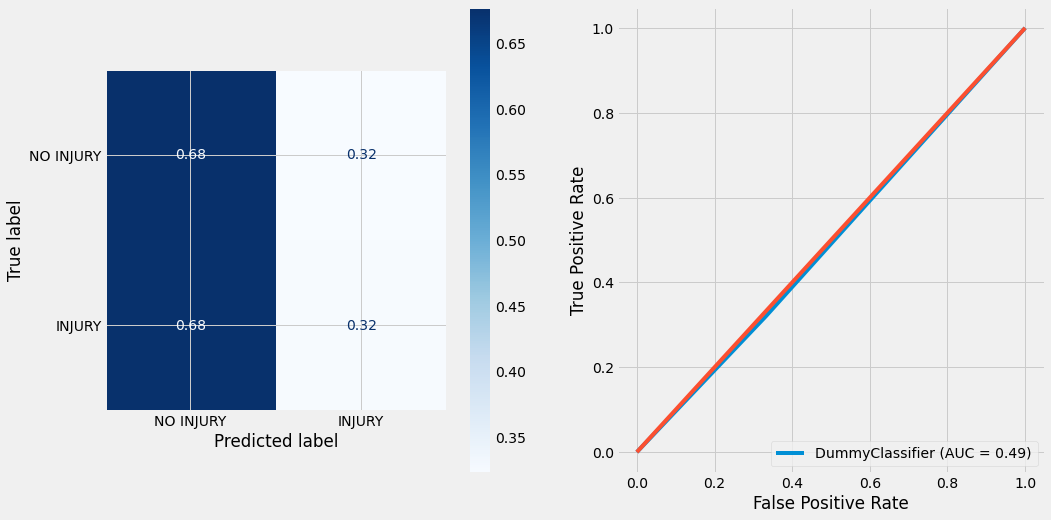

In [86]:
model_eval(dummy, X_train_tf, y_train, X_test_tf, y_test)

## Logistic Regression
First I will create a logistic regression model and check for the scores.|

### Linearity with Target

> **Observation**
> - The features seem to have a linear relationship with target

### Multicollinearity

<AxesSubplot:>

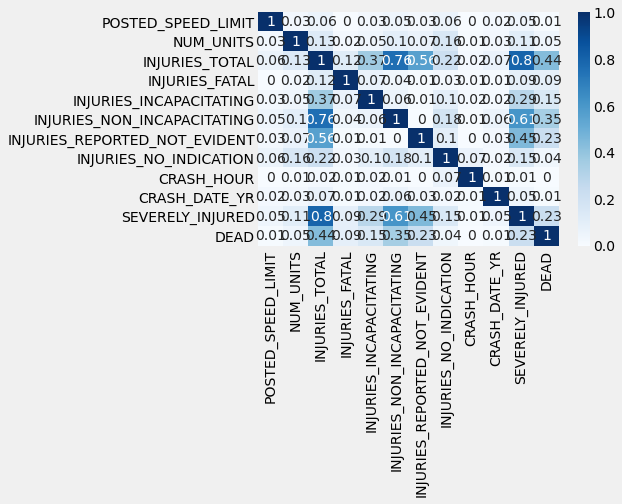

In [87]:
sns.heatmap(df_explore.corr().abs().round(2), annot=True, cmap="Blues")

> **Observation**
> - High correlation between `INJURIES_TOTAL` and `INJURIES_NON_INCAPACITATING` is observed.

> **Action** 
>- drop `INJURIES_NON_INCAPACITATING` column.

In [88]:
X_train_tf.drop("INJURIES_FATAL", axis=1, inplace=True)
X_test_tf.drop("INJURIES_FATAL", axis=1, inplace=True)

In [89]:
X_train_tf.drop("INJURIES_TOTAL", axis=1, inplace=True)
X_test_tf.drop("INJURIES_TOTAL", axis=1, inplace=True)

### Model 1

In [90]:
X_train_lr = X_train_tf.copy()
X_test_lr = X_test_tf.copy()
X_train_lr.shape, X_test_lr.shape

((82799, 455), (35486, 455))

In [91]:
lr1 = LogisticRegression()

In [92]:
lr1.fit(X_train_lr, y_train)

LogisticRegression()

In [93]:
y_test_pred = lr1.predict(X_test_lr)

In [94]:
lr1_score = accuracy_score(y_test, y_test_pred)
lr1_score

0.891450149354675

In [95]:
y_train.value_counts(normalize=True)

0    0.672266573267793
1   0.3277334267322069
Name: CRASH_TYPE, dtype: float64

### Model evaluation

MODEL EVAL VS PREVIOUS (TEST)


Previous Model Current Model Delta
Recall             0.33           0.8  0.47
F1                 0.32          0.83  0.51
Accuracy           0.56          0.89  0.33
AUC                 0.5          0.96  0.46



CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.81
Recall on Test: 0.8


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     23838
           1       0.86      0.80      0.83     11648

    accuracy                           0.89     35486
   macro avg       0.88      0.87      0.87     35486
weighted avg       0.89      0.89      0.89     35486

Test Graphs------------------------------------------------------


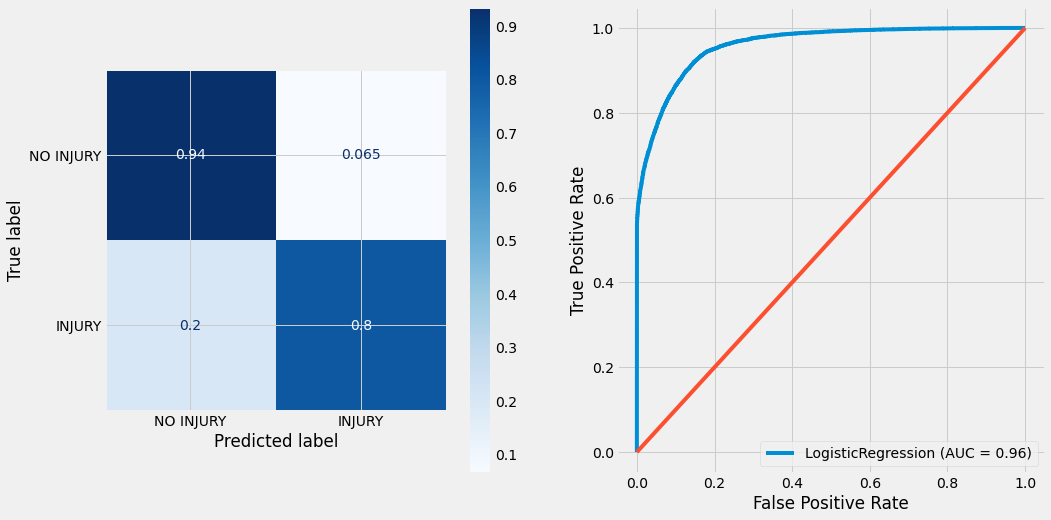

PREVIOUS MODEL


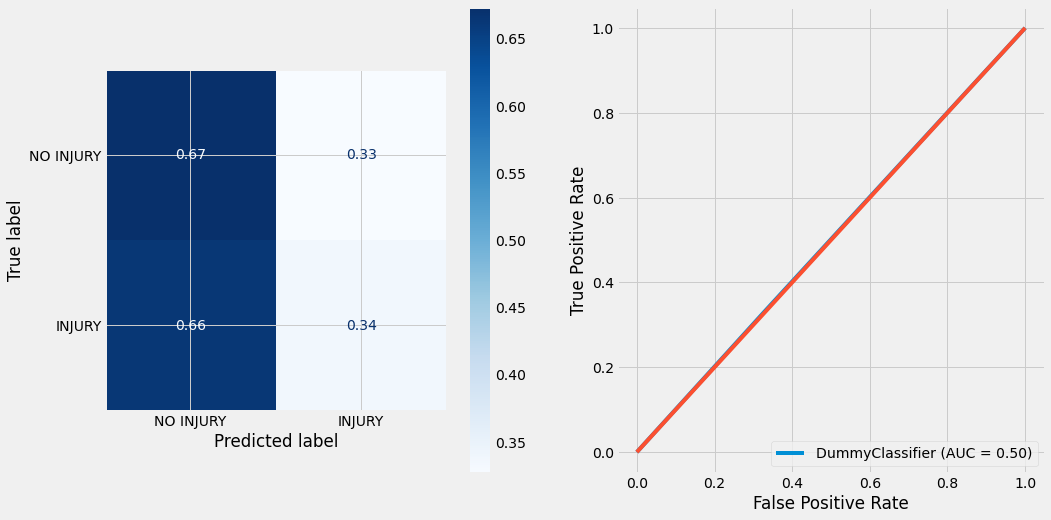

<Figure size 432x288 with 0 Axes>

In [96]:
model_eval(lr1, X_train_lr, y_train, X_test_lr, y_test, prev_model=dummy)

## Feature Selection


In [97]:
#create copy of training and test set for logistic regression
X_train_lr_sel = X_train_lr.copy()
X_test_lr_sel = X_test_lr.copy()

X_train_lr_sel.shape, X_test_lr_sel.shape

((82799, 455), (35486, 455))

In [98]:
#remove constant features
sel_const = DropConstantFeatures(tol=1, missing_values='raise')
#fit the model
sel_const.fit(X_train_lr_sel)

DropConstantFeatures()

In [99]:
len(sel_const.features_to_drop_)

0

In [100]:
#remove quasi-constant features
quasi_const = DropConstantFeatures(tol=0.998, missing_values='raise')
#fit the model
quasi_const.fit(X_train_lr_sel)

DropConstantFeatures(tol=0.998)

In [101]:
len(quasi_const.features_to_drop_)

95

In [102]:
X_train_lr_sel.shape, X_test_lr_sel.shape

((82799, 455), (35486, 455))

In [103]:
X_train_lr_sel = quasi_const.transform(X_train_lr)
X_test_lr_sel = quasi_const.transform(X_test_lr)

In [104]:
X_train_lr_sel.shape, X_test_lr_sel.shape

((82799, 360), (35486, 360))

In [105]:
dup = DropDuplicateFeatures(missing_values="raise")
dup.fit(X_train_lr_sel)

DropDuplicateFeatures(missing_values='raise')

In [106]:
dup.duplicated_feature_sets_

[]

### Model 2

In [107]:
lr_2 = LogisticRegression()
lr_2.fit(X_train_lr_sel, y_train)

LogisticRegression()

### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


Previous Model Current Model Delta
Recall              0.8           0.8   0.0
F1                 0.83          0.83   0.0
Accuracy           0.89          0.89   0.0
AUC                0.96          0.96   0.0



CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.81
Recall on Test: 0.8


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     23838
           1       0.86      0.80      0.83     11648

    accuracy                           0.89     35486
   macro avg       0.88      0.87      0.87     35486
weighted avg       0.89      0.89      0.89     35486

Test Graphs------------------------------------------------------


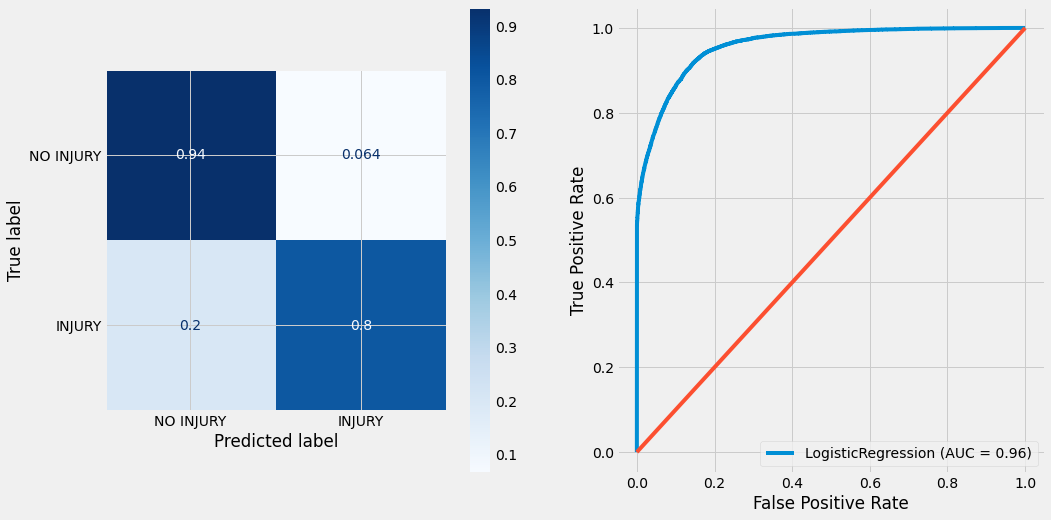

PREVIOUS MODEL


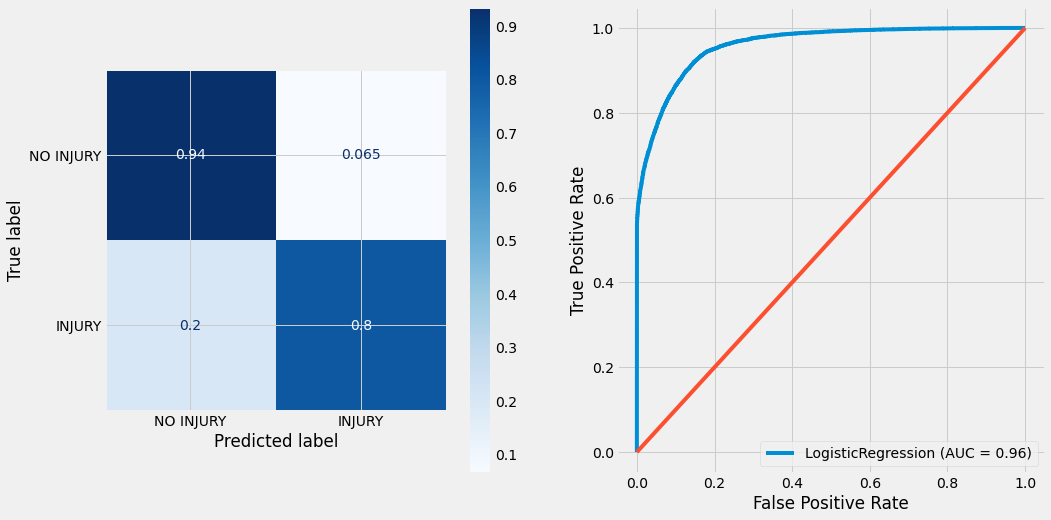

<Figure size 432x288 with 0 Axes>

In [108]:
model_eval(lr_2, X_train_lr_sel, y_train, X_test_lr_sel, y_test, 
               prev_model=lr1, prev_X_train=X_train_lr, prev_y_train=y_train,
               prev_X_test=X_test_lr, prev_y_test=y_test)

> **Observation**
> - Reducing the number of features didnt hurt the model.
> - About 21% of the features were removed.

### Model 3

In [109]:
lr_3 = LogisticRegression()

In [110]:
params_3 = {"C":[0.001, 0.01, 0.1, 1, 1e7, 1e8, 1e9, 1e12],
           "penalty":["l1", "l2"],
           "solver":["liblinear"]}

In [ ]:
lr_3_gridsearch = GridSearchCV(lr_3, params_3,
                               scoring="recall", n_jobs=-1, cv=5)
lr_3_gridsearch.fit(X_train_lr_sel, y_train)

### Model Evaluation

In [ ]:
lr_3_gridsearch.best_params_

In [ ]:
model_eval(lr_3_gridsearch.best_estimator_, X_train_lr_sel, y_train, X_test_lr_sel, y_test, prev_model=lr_2)

### Model 4

In [ ]:
lr_4 = LogisticRegression(class_weight="balanced")

In [ ]:
params_4 = {"C":[.01, 0.1, 1, 1e7, 1e8, 1e9, 1e10],
           "penalty":["l1", "l2"],
           "solver":["liblinear"]}

In [ ]:
lr_4_gridsearch = GridSearchCV(lr_4, params_4, scoring="recall", n_jobs=-1, cv=5)
lr_4_gridsearch.fit(X_train_lr_sel, y_train)

In [ ]:
lr_4_gridsearch.best_params_

### Model Evaluation

In [ ]:
model_eval(lr_4_gridsearch.best_estimator_, X_train_lr_sel,y_train,
          X_test_lr_sel,y_test,
           prev_model=lr_3_gridsearch.best_estimator_ )

## Random Forest

### Model 1

In [ ]:
X_train_dt = X_train_tf.copy()
X_test_dt = X_train_tf.copy()

In [ ]:
rf_1 = RandomForestClassifier()
rf_1.fit(X_train_df, y_train)

### Model Evaluation

In [ ]:
model_eval(rf_1, X_train_dt, y_train, X_test_dt, y_test,
          prev_model=lr_4_gridsearch.best_estimator,
          prev_X_train=X_train_lr_sel, prev_y_train=y_train,
          prev_X_test= X_test_lr_sel, prev_y_test=y_test)

In [ ]:
rf_1.estimators_[0].get_n_leaves

In [ ]:
depths = [m.get_depth() for m in rf_1.estimators_]
max(depths)

### Model 2

In [ ]:
rf_2 = RandomForestClassifier()

In [ ]:
params = [{"n_estimators":[100, 500, 1000],
          "criterion":["entropy", "gini"],
          "max_features":["auto", "log2"],
          "class_weight":["balanced"],
          "max_depth":[20, 35, 65],
          "min_samples_split":[2, 3],
          "min_samples_leaf":[1, 2, 3]}]

In [ ]:
rf_2_gridsearch = GridSearchCV(rf_2, params, scoring="recall", n_jobs=-1, cv=3)
rf_2_gridsearch.fit(X_train_dt, y_train)

### Model Evaluation

In [ ]:
rf_2_gridsearch.best_params_

In [ ]:
model_eval(rf_2_gridsearch.best_estimator_, X_train_dt, y_train, X_test_dt, y_test,
           prev_model=rf_1)

In [ ]:
rf_2_fi = rf_2_gridsearch.best_estimator_.feature importances

In [ ]:
rf_2_features = pd.DataFrame(data=rf_2_fi, index=X_train_df.columns,
                            columns=["Feature Importances"])
rf_2_features_sprted = rf_2_features[:10].sort_values("Feature Importances", ascending=False)

In [ ]:
rf_2_features_sorted

In [ ]:
fig, ax= plt.subplots(figasize=(10, 10))
sns.barplot(data=rf_2_features_sorted,
           x=rf_2_features_sorted["Feature Importances"],
           y = rf_2_features_sorted.index, orient="h", color="blue")

# Data Interpretation

>This dataset took a lot of cleaning, especially involving unknown values which were in the original dataset. After cleaning, a logistic regression and random forest classification was trained to predict civilians in Chicago being injured or not. Classification models were created and optimized for finding an injured civilian due to car crash. 

# Recommendations and Conclusions

In [ ]:
> I have 3 recommendations based on my work:
    1. 
    